In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc2


## Loading

In [2]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

In [3]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True,
  },
  "handle_imbalance": None,
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 64,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0000,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 128,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 300,
            "learning_rate": 0.001,
            "weight_decay": 0.0,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [5]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

# Heart

In [5]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

## Clients MNAR LR - Balanced

### Simple Averaging

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(319795, 25)
(54746, 25)
(54746, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 14:31:39.652 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:31:39.652 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 14:32:38.235 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:32:38.236 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 14:33:40.482 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:33:40.483 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 14:33:46.788 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 129.70961640001042


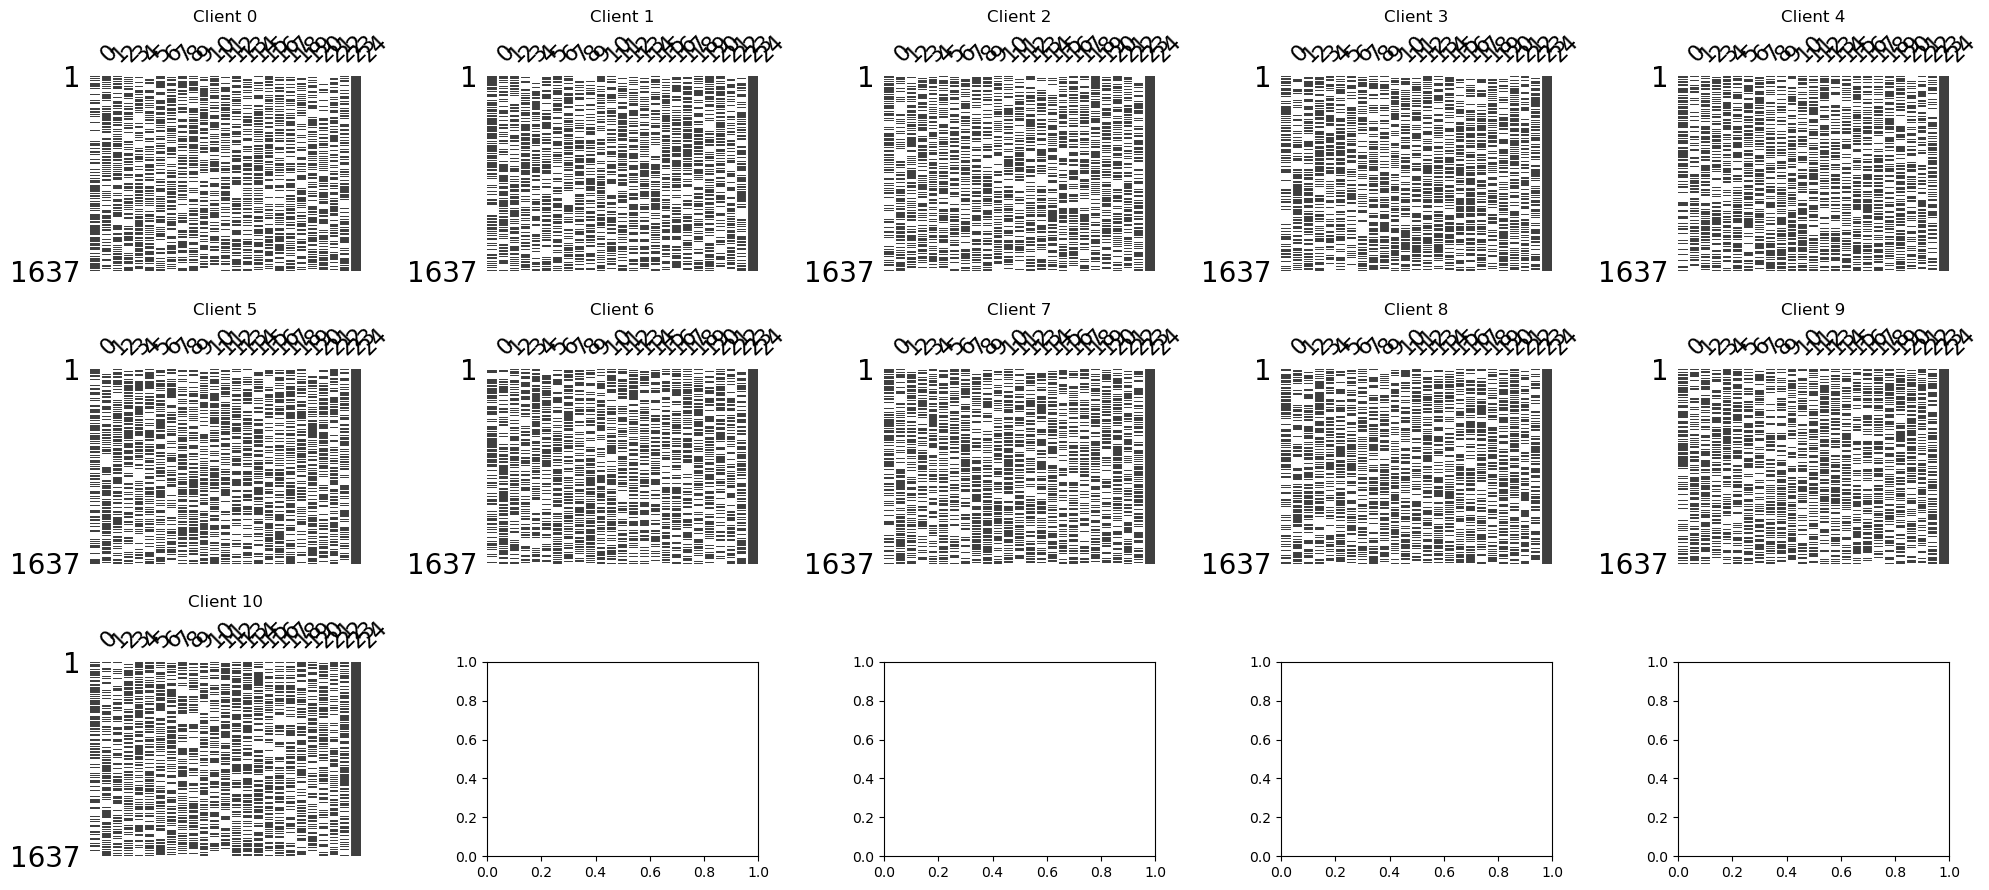

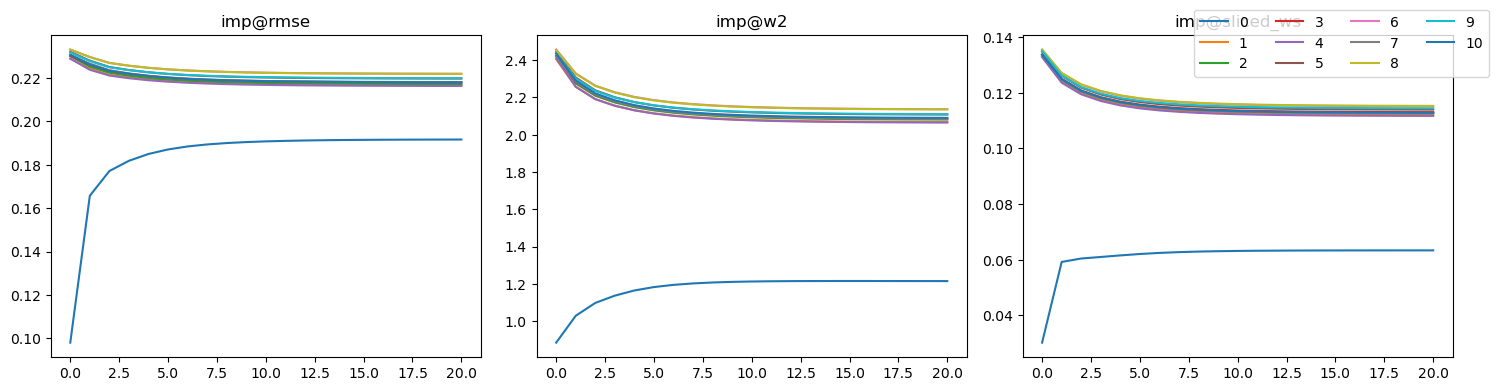

{'imp@rmse': 0.21634214402831575, 'imp@ws': 2.0175549716075336, 'imp@sliced_ws': 0.10884745887623519}


In [9]:
name = 'mnar_lr_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [11]:
pred_ret = NN_evaluation(
    rets['mnar_lr_heart_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-08-13 14:36:26.815 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.7065, test_f1: 0.6960 test_auroc: 0.7642 train_loss: 0.6501 val_accu: 0.6452 val_f1: 0.6423 test recall 0.6747 precision 0.7187 b-accu 0.7064
2023-08-13 14:36:26.976 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 1, test_accu: 0.7145, test_f1: 0.7123 test_auroc: 0.7750 train_loss: 0.6196 val_accu: 0.6535 val_f1: 0.6524 test recall 0.7098 precision 0.7149 b-accu 0.7145
2023-08-13 14:36:27.139 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.7175, test_f1: 0.7285 test_auroc: 0.7791 train_loss: 0.6158 val_accu: 0.6572 val_f1: 0.6571 test recall 0.7610 precision 0.6986 b-accu 0.7177
2023-08-13 14:36:27.292 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 3, test_accu: 0.7005, test_f1: 0.7271 test_aur

0.727 0.792554680874894 0.7476066144473454


### Ours

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(319795, 25)
(54746, 25)
(54746, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 14:38:18.653 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:38:18.653 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 14:39:17.693 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:39:17.694 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 14:40:24.656 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:40:24.657 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 14:40:31.358 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 135.27670319999743


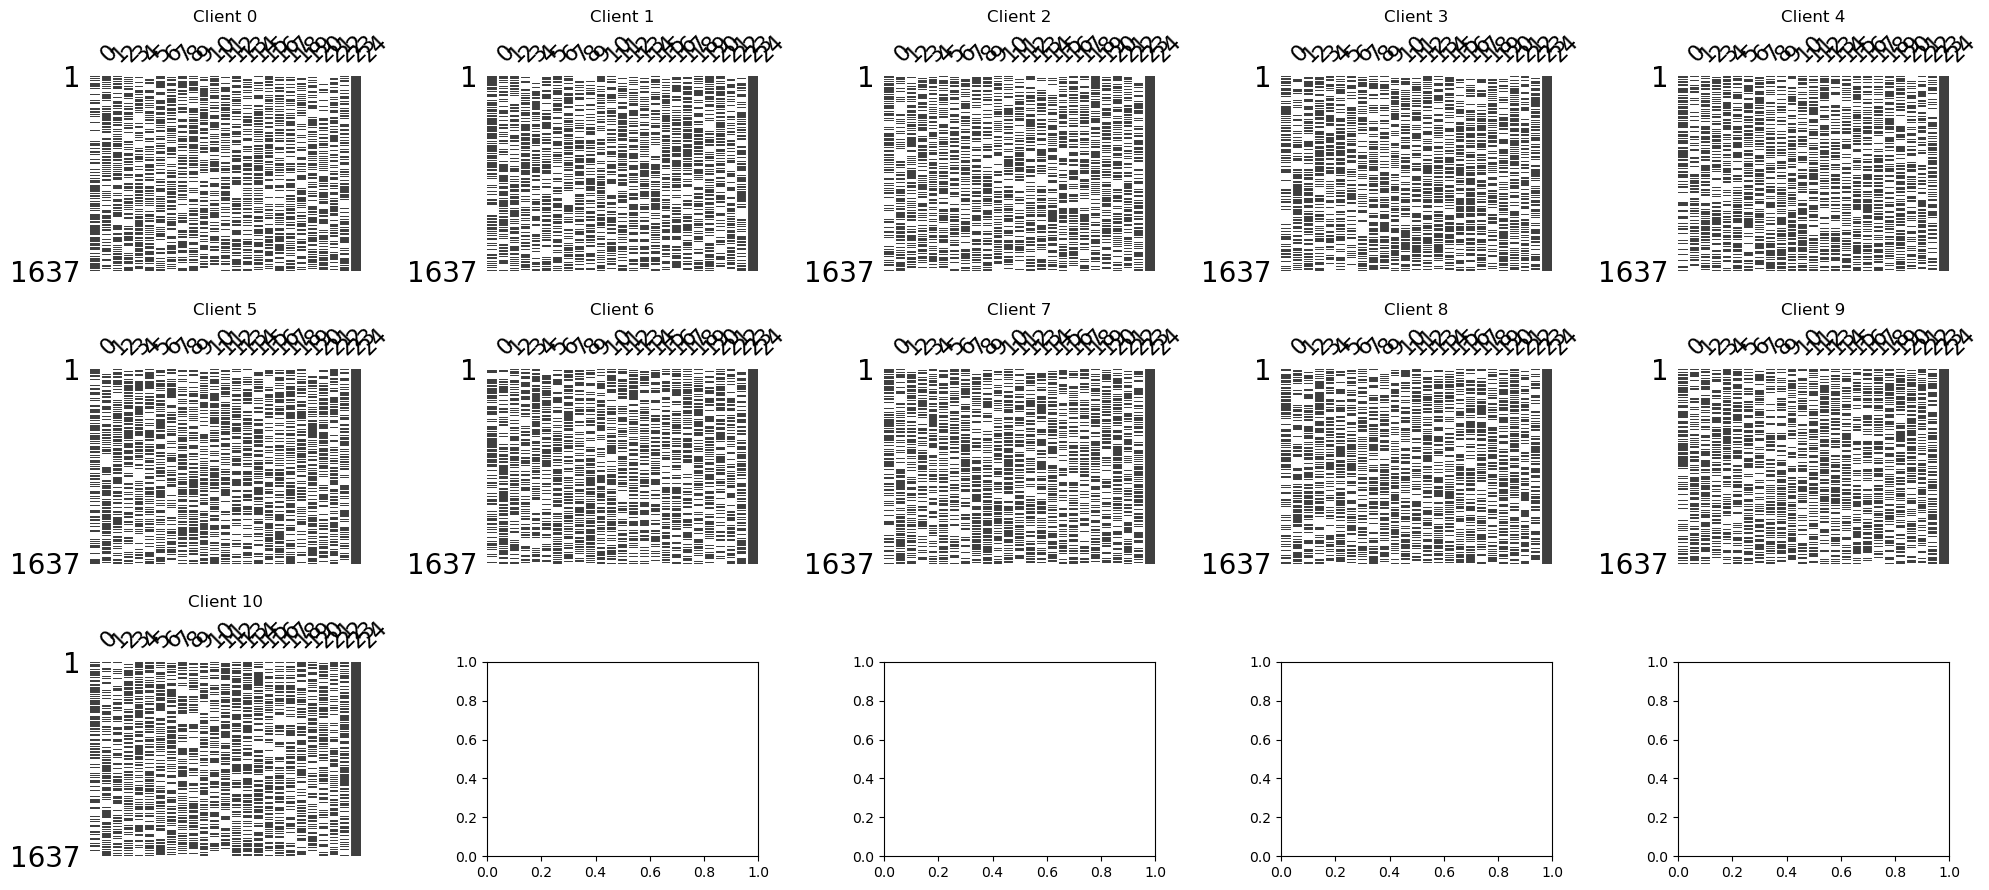

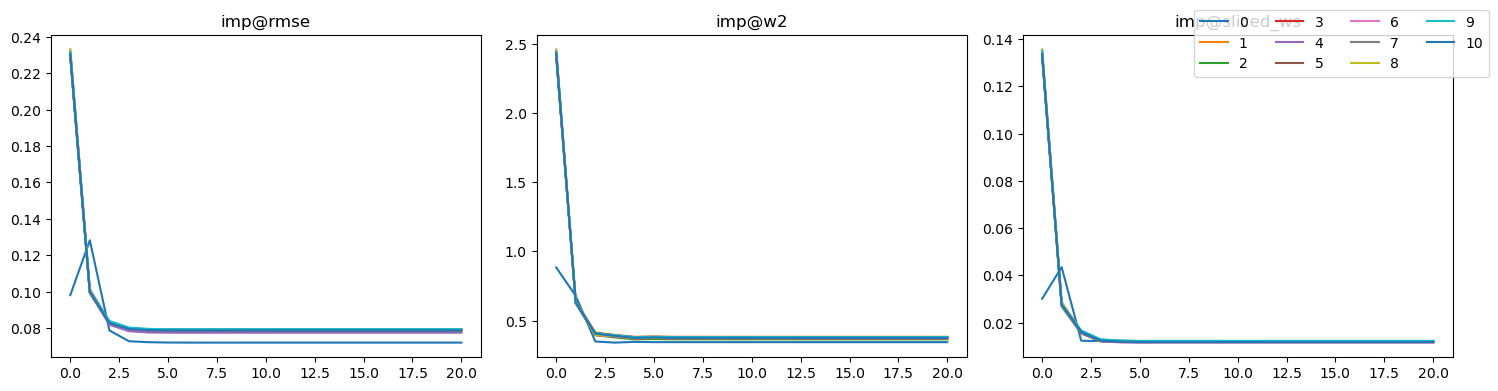

{'imp@rmse': 0.07811245333328495, 'imp@ws': 0.37363147256109586, 'imp@sliced_ws': 0.01200826178661046}


In [12]:
name = 'mnar_lr_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [14]:
pred_ret = NN_evaluation(
    rets['mnar_lr_heart_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-08-13 14:41:01.106 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.7465, test_f1: 0.7333 test_auroc: 0.8182 train_loss: 0.6099 val_accu: 0.7253 val_f1: 0.7246 test recall 0.6998 precision 0.7702 b-accu 0.7463
2023-08-13 14:41:09.584 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.7650, test_f1: 0.7773 test_auroc: 0.8382 train_loss: 0.5127 val_accu: 0.7478 val_f1: 0.7473 test recall 0.8233 precision 0.7361 b-accu 0.7652
2023-08-13 14:41:17.892 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.7545, test_f1: 0.7488 test_auroc: 0.8357 train_loss: 0.5014 val_accu: 0.7528 val_f1: 0.7524 test recall 0.7349 precision 0.7633 b-accu 0.7544
2023-08-13 14:41:25.994 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.7575, test_f1: 0.7600 tes

0.7695 0.8384044144706315 0.7853500231803431


## Clients MNAR RL Balanced

### SimpleAVG

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(319795, 25)
(54746, 25)
(54746, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 14:42:47.168 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:42:47.169 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 14:43:46.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:43:46.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 14:44:52.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:44:52.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 14:44:59.382 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 134.8136635999981


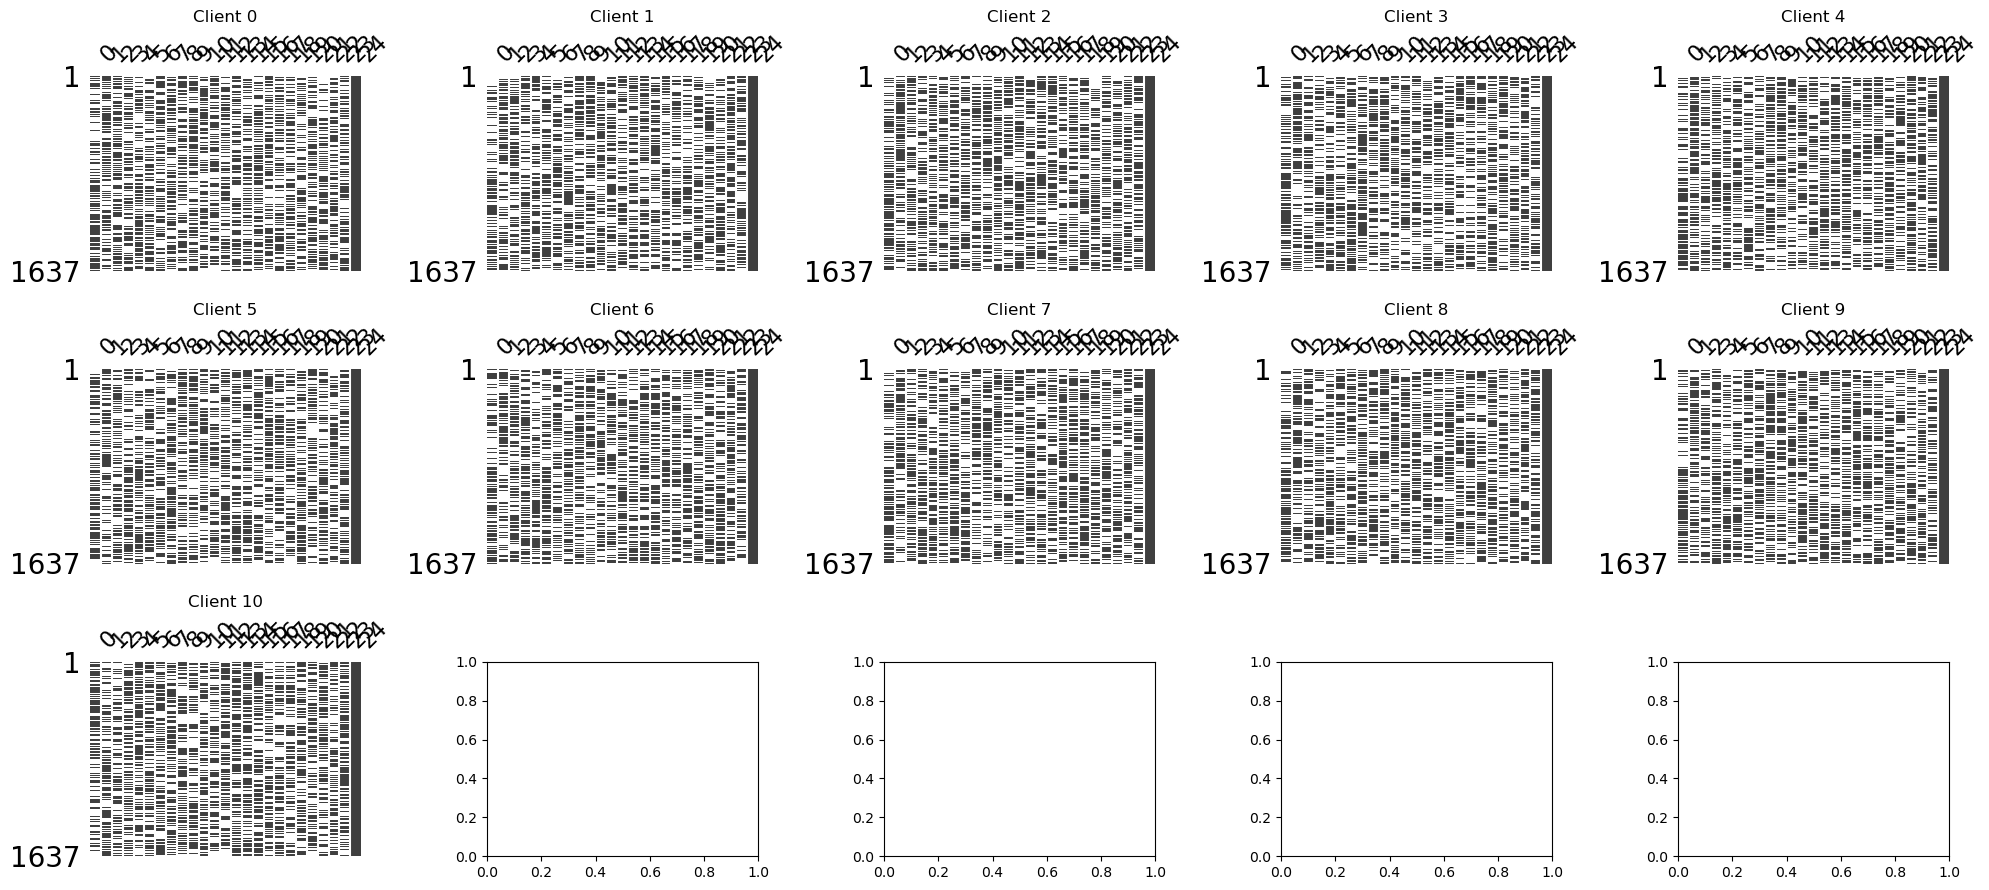

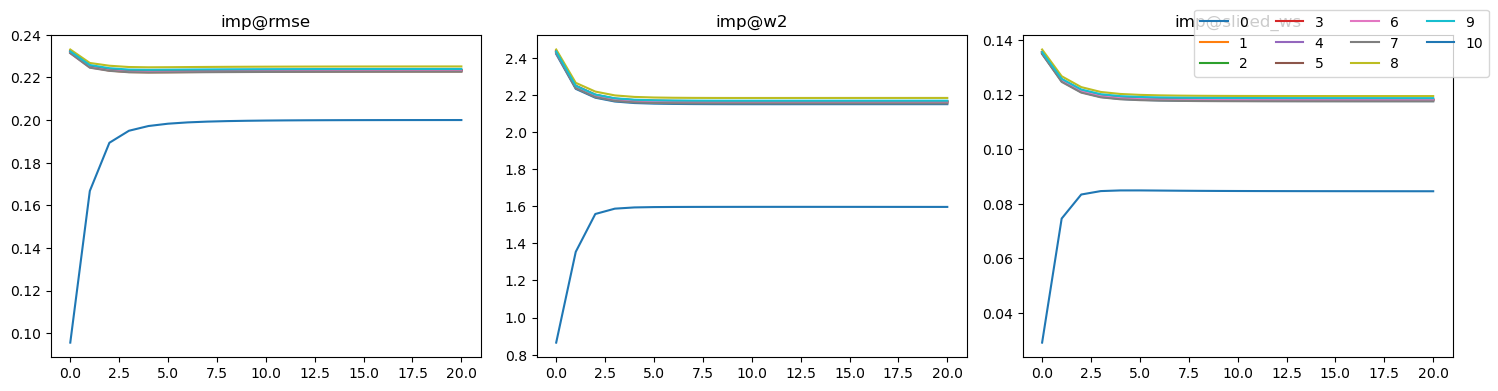

{'imp@rmse': 0.2212809520152537, 'imp@ws': 2.1103560548582436, 'imp@sliced_ws': 0.11510169667107512}


In [15]:
name = 'mnar_rl_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [17]:
pred_ret = NN_evaluation(
    rets['mnar_rl_heart_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-08-13 14:49:09.204 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.6840, test_f1: 0.6075 test_auroc: 0.7715 train_loss: 0.6673 val_accu: 0.6560 val_f1: 0.6464 test recall 0.4910 precision 0.7964 b-accu 0.6832
2023-08-13 14:49:17.388 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.7545, test_f1: 0.7566 test_auroc: 0.8231 train_loss: 0.5720 val_accu: 0.7051 val_f1: 0.7051 test recall 0.7661 precision 0.7473 b-accu 0.7545
2023-08-13 14:49:25.591 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.7490, test_f1: 0.7407 test_auroc: 0.8184 train_loss: 0.5617 val_accu: 0.7065 val_f1: 0.7060 test recall 0.7199 precision 0.7628 b-accu 0.7489
2023-08-13 14:49:33.829 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.7470, test_f1: 0.7345 tes

0.7585 0.8261202179234868 0.7579952267303103


### OUR

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(319795, 25)
(54746, 25)
(54746, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 14:50:46.243 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:50:46.243 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 14:51:53.293 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:51:53.294 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 14:52:58.954 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:52:58.955 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 14:53:05.483 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 141.78050209999492


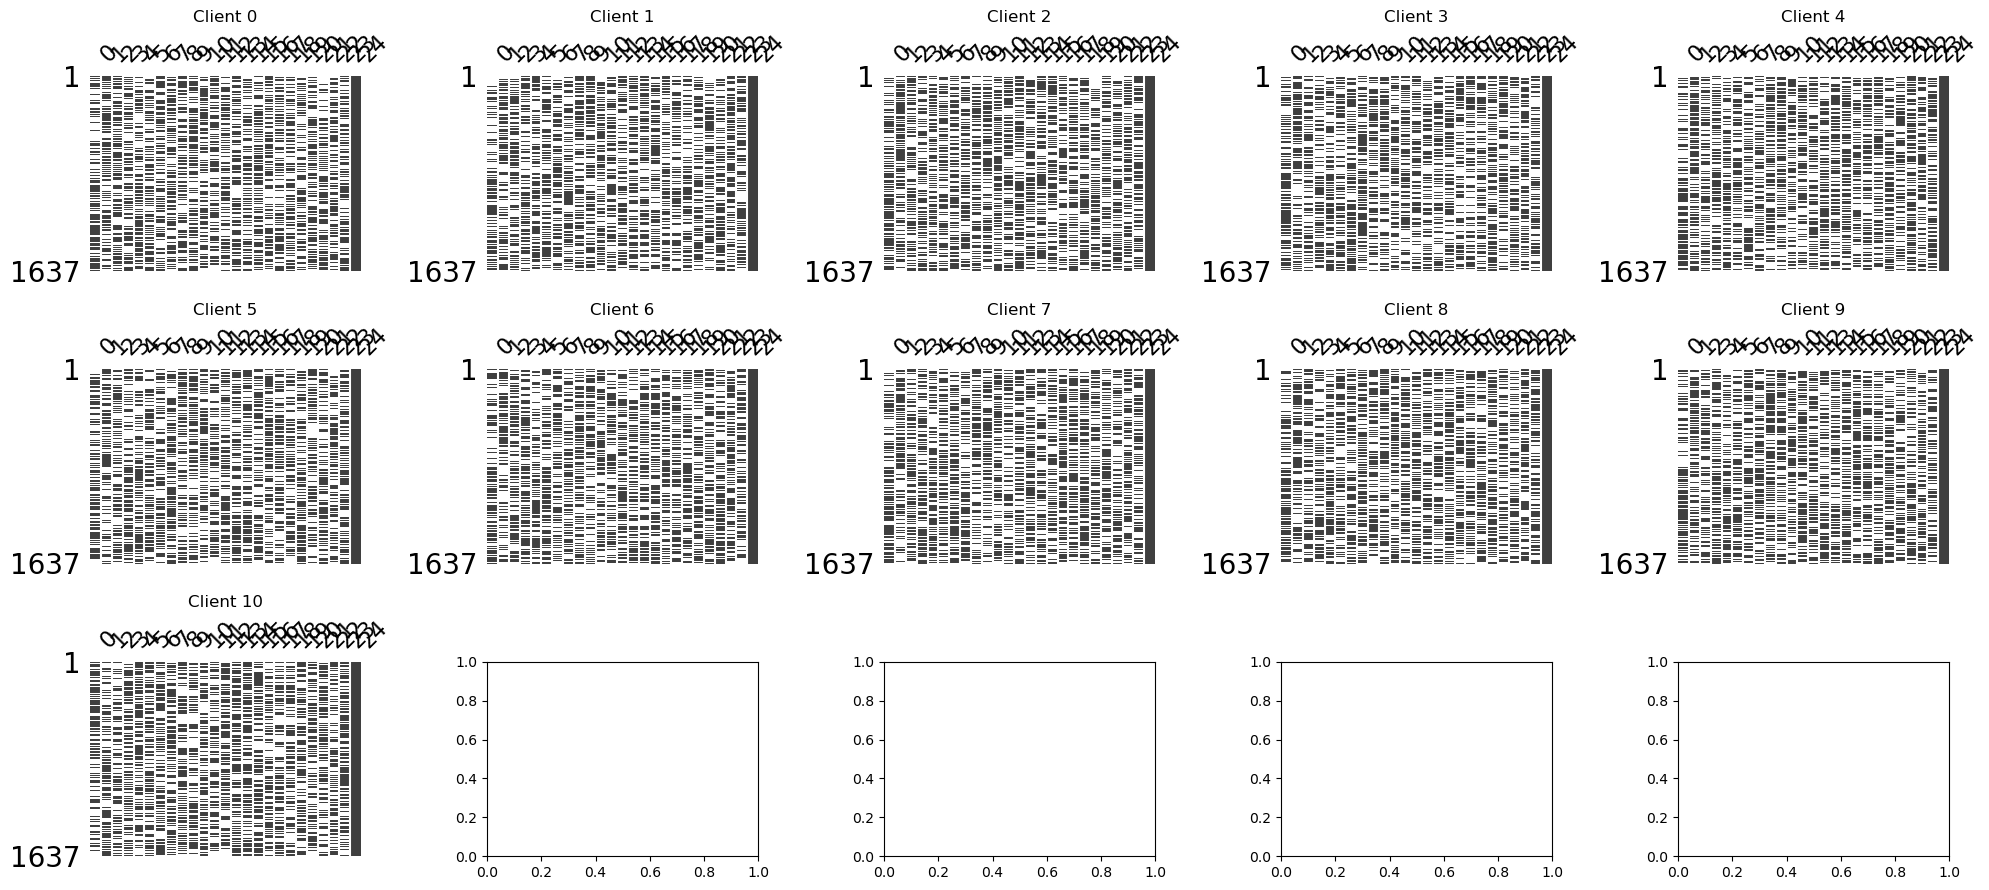

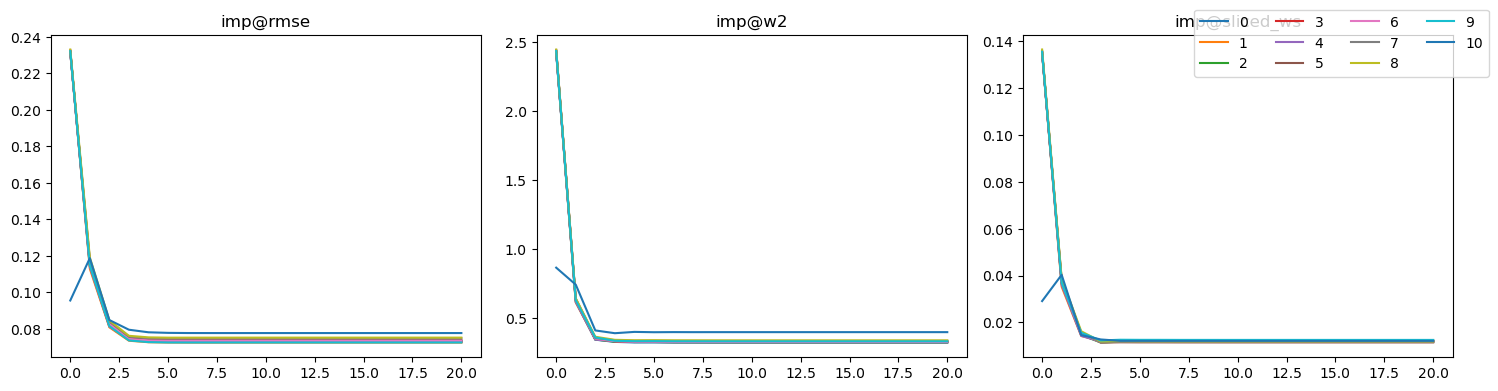

{'imp@rmse': 0.0738854690892709, 'imp@ws': 0.336044513652901, 'imp@sliced_ws': 0.011931119132901449}


In [18]:
name = 'mnar_rl_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [19]:
pred_ret = NN_evaluation(
    rets['mnar_rl_heart_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-08-13 14:53:07.274 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.7490, test_f1: 0.7426 test_auroc: 0.8237 train_loss: 0.6195 val_accu: 0.7203 val_f1: 0.7200 test recall 0.7269 precision 0.7589 b-accu 0.7489
2023-08-13 14:53:15.424 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.7710, test_f1: 0.7842 test_auroc: 0.8405 train_loss: 0.5165 val_accu: 0.7489 val_f1: 0.7483 test recall 0.8353 precision 0.7389 b-accu 0.7713
2023-08-13 14:53:23.637 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.7575, test_f1: 0.7512 test_auroc: 0.8394 train_loss: 0.5038 val_accu: 0.7356 val_f1: 0.7349 test recall 0.7349 precision 0.7681 b-accu 0.7574
2023-08-13 14:53:31.801 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.7610, test_f1: 0.7610 tes

0.771 0.84312549000784 0.7841658812441092


## Client MNAR LR - Raw

### Simple Avg

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 14:57:06.543 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:57:06.544 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 14:58:02.060 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:58:02.061 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 14:59:04.074 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 14:59:04.075 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 14:59:10.288 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 126.38341049999872


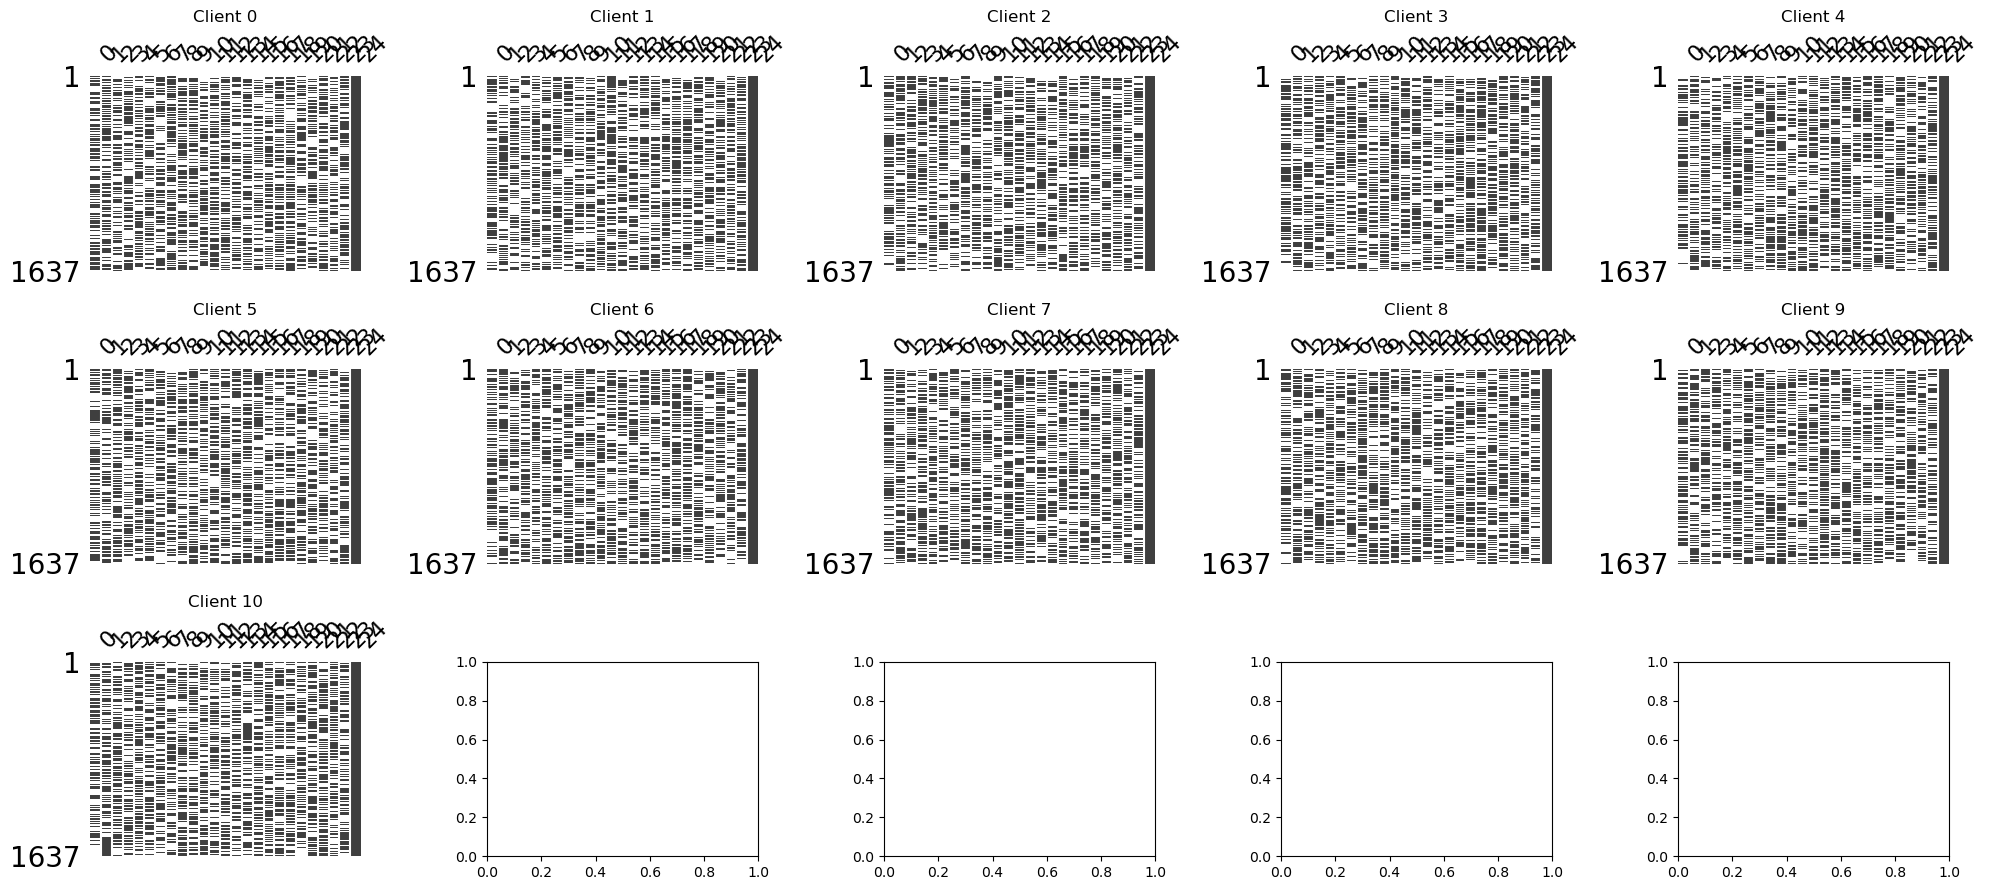

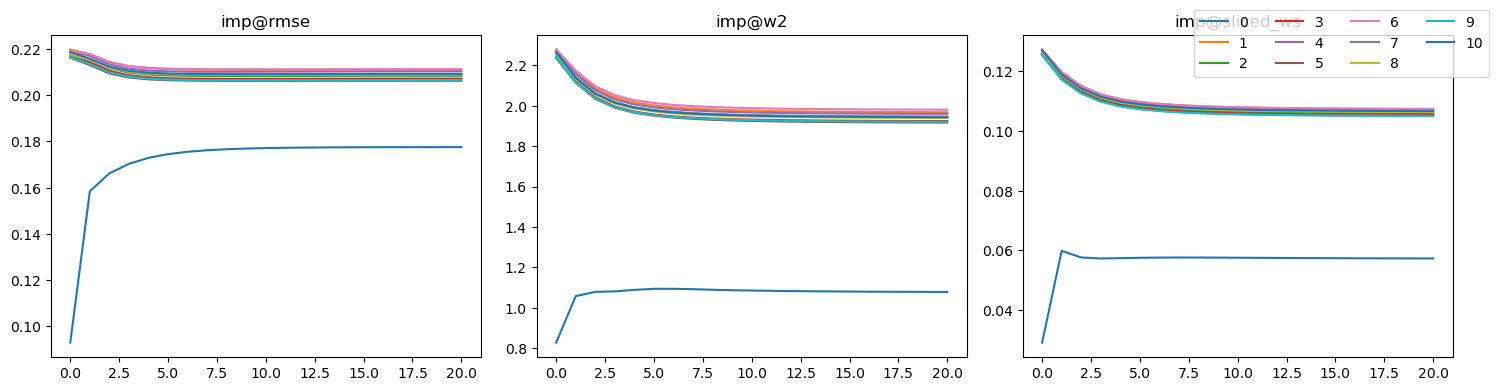

{'imp@rmse': 0.20590843793374664, 'imp@ws': 1.865610152725503, 'imp@sliced_ws': 0.10187521876361198}


In [20]:
name = 'mnar_lr_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [37]:
pred_ret = NN_evaluation(
    rets['mnar_lr_heart_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl, imbalance='smotetm',
)

2023-08-13 15:49:57.287 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.5865, test_f1: 0.2636 test_auroc: 0.7789 train_loss: 0.6332 val_accu: 0.6635 val_f1: 0.6634 test recall 0.8177 precision 0.1571 b-accu 0.6906
2023-08-13 15:50:11.844 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.6955, test_f1: 0.2707 test_auroc: 0.7368 train_loss: 0.5078 val_accu: 0.7491 val_f1: 0.7490 test recall 0.6243 precision 0.1728 b-accu 0.6634
2023-08-13 15:50:26.620 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.6810, test_f1: 0.2733 test_auroc: 0.7293 train_loss: 0.4793 val_accu: 0.7740 val_f1: 0.7740 test recall 0.6630 precision 0.1722 b-accu 0.6729
2023-08-13 15:50:41.413 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.6495, test_f1: 0.2613 tes

0.774 0.7790207113981029 0.2981366459627329


### Ours

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 15:04:01.256 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:04:01.256 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 15:05:02.320 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:05:02.320 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 15:06:08.788 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:06:08.789 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 15:06:15.470 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 136.9062711000006


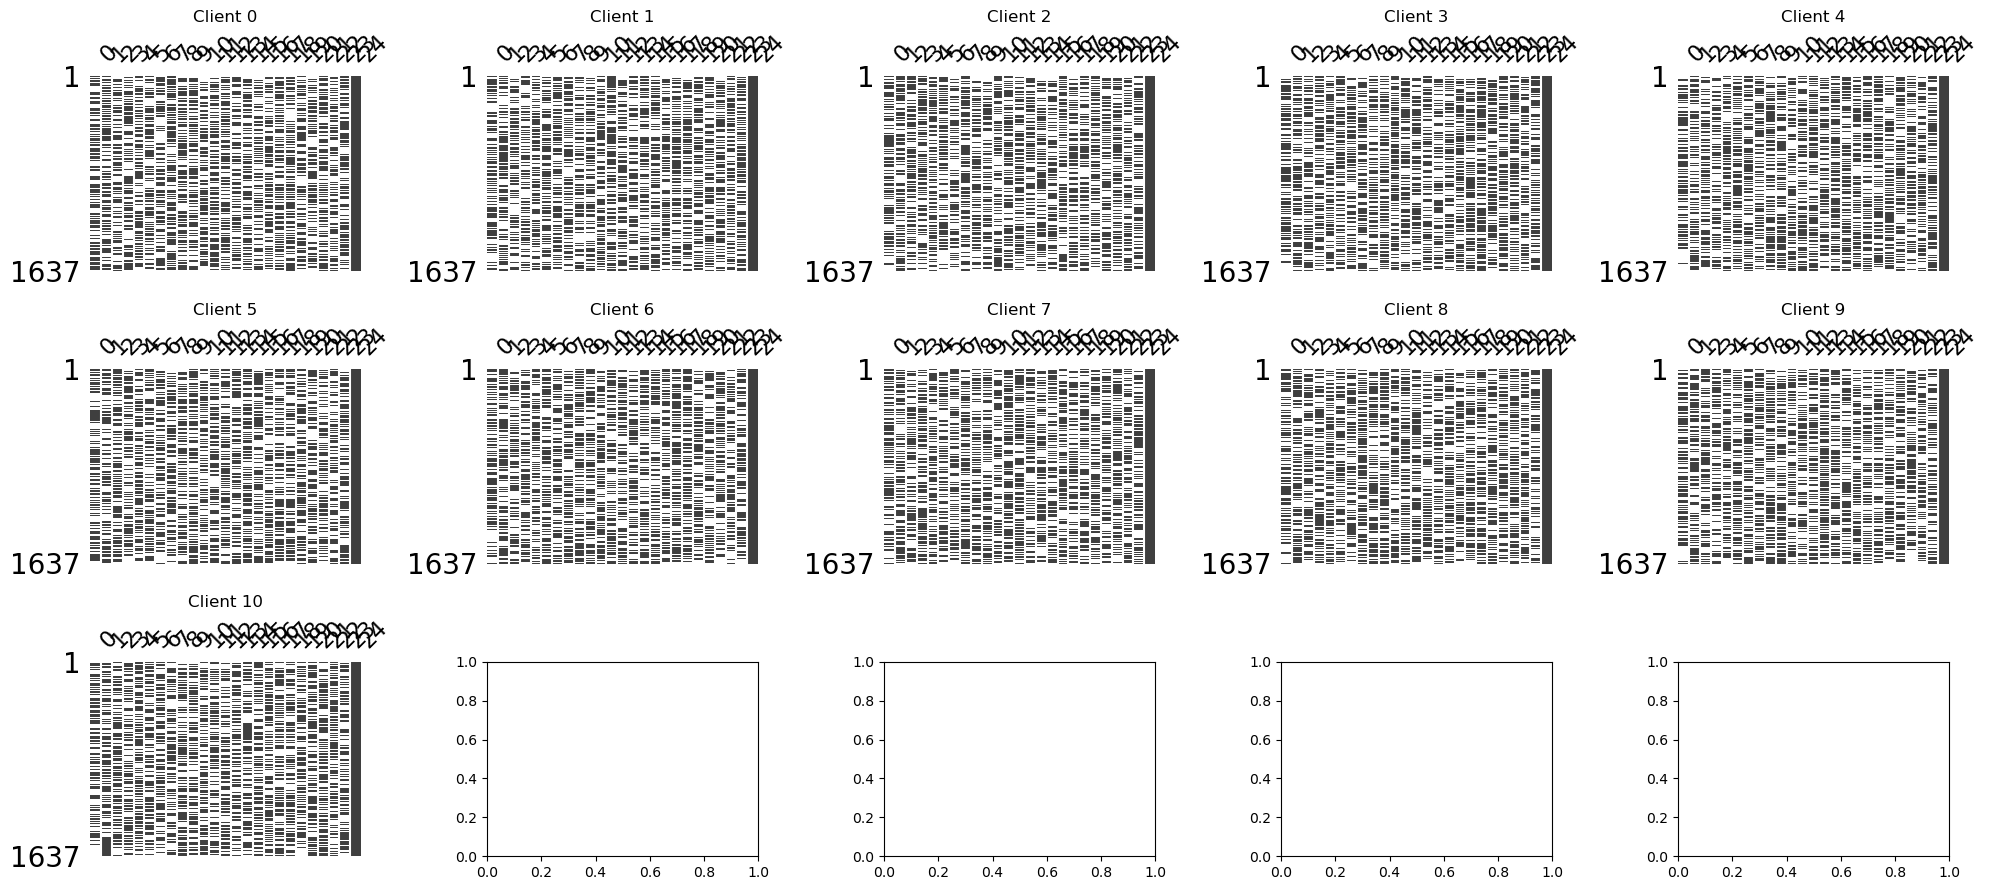

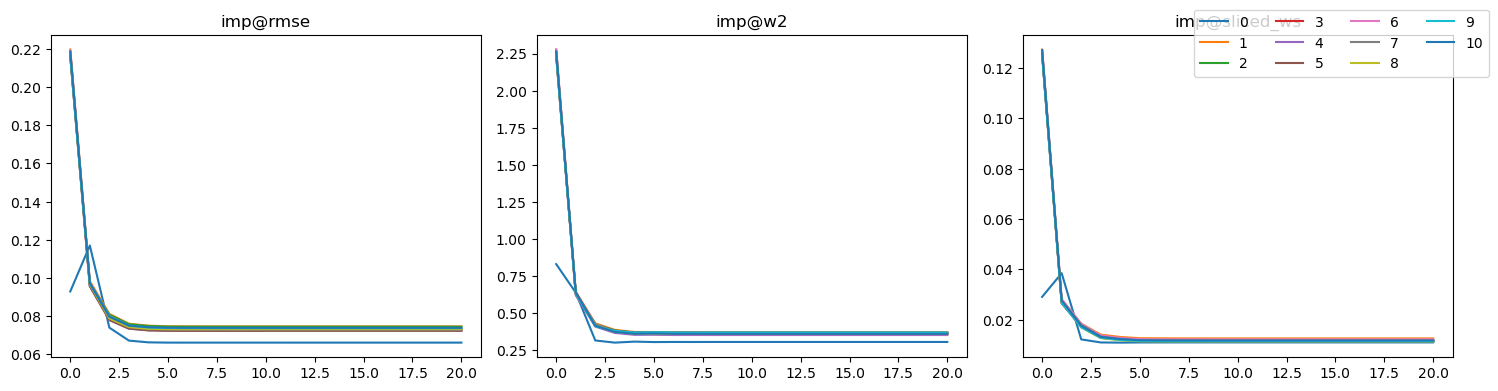

{'imp@rmse': 0.07274017312714834, 'imp@ws': 0.3546187635271738, 'imp@sliced_ws': 0.011715771096386622}


m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-08-13 15:06:17.519 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.9095, test_f1: 0.0000 test_auroc: 0.7444 train_loss: 0.3318 val_accu: 0.9085 val_f1: 0.4760 test recall 0.0000 precision 0.0000 b-accu 0.5000
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-def

0.9135 0.8266866926457679 0.2471042471042471


In [23]:
name = 'mnar_lr_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [35]:
pred_ret = NN_evaluation(
    rets['mnar_lr_heart_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl, imbalance='smotetm',
)

2023-08-13 15:44:33.284 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.7490, test_f1: 0.3581 test_auroc: 0.8193 train_loss: 0.5878 val_accu: 0.7320 val_f1: 0.7318 test recall 0.7735 precision 0.2329 b-accu 0.7600
2023-08-13 15:44:47.887 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.8550, test_f1: 0.2033 test_auroc: 0.6904 train_loss: 0.3617 val_accu: 0.8231 val_f1: 0.8218 test recall 0.2044 precision 0.2022 b-accu 0.5621
2023-08-13 15:45:02.919 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.8480, test_f1: 0.2083 test_auroc: 0.7005 train_loss: 0.3210 val_accu: 0.8582 val_f1: 0.8582 test recall 0.2210 precision 0.1970 b-accu 0.5657
2023-08-13 15:45:17.512 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.8070, test_f1: 0.2218 tes

0.881 0.8192954054653306 0.3766816143497758


## Clients MNAR RL RAW

### SimpleAvg

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 15:11:13.607 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:11:13.607 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 15:12:17.396 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:12:17.397 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 15:13:24.787 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:13:24.788 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 15:13:31.585 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 140.6510719999933


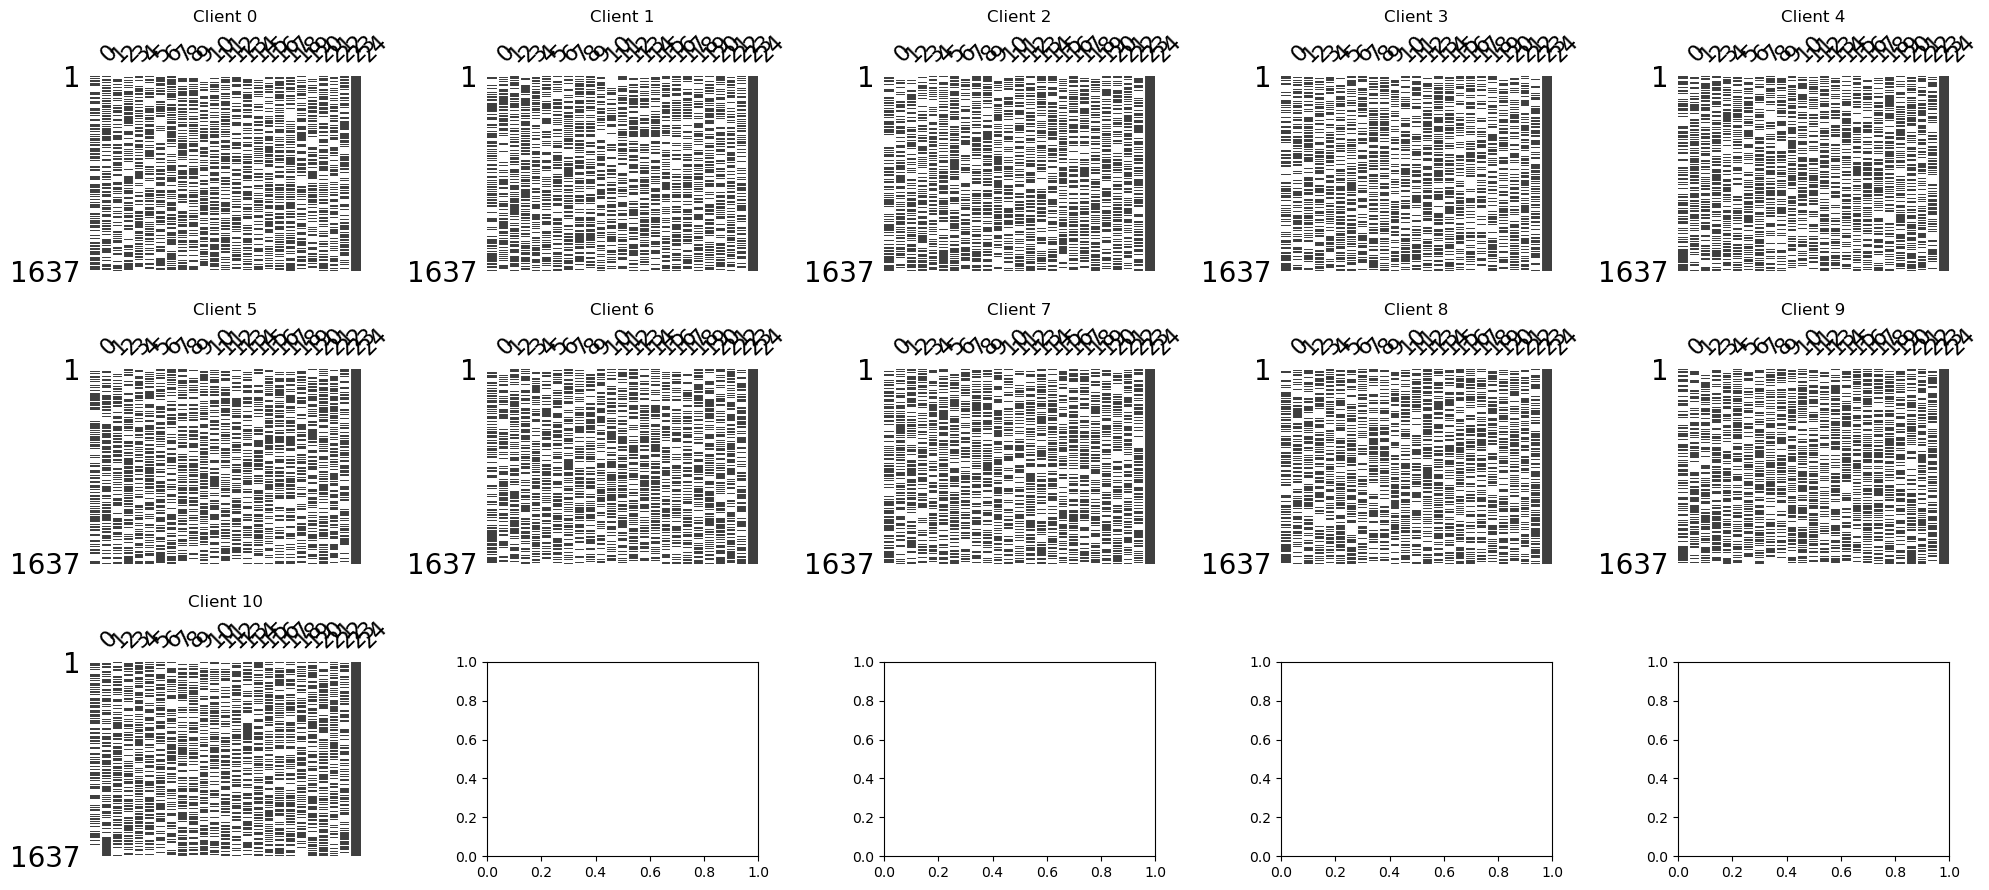

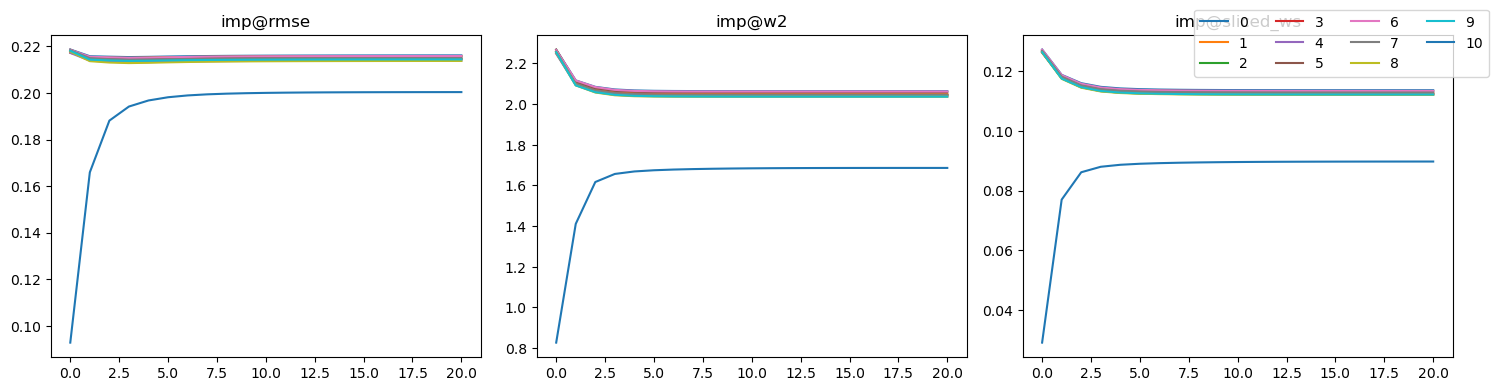

{'imp@rmse': 0.21365837633680304, 'imp@ws': 2.0148217129789936, 'imp@sliced_ws': 0.11063516681471813}


In [25]:
name = 'mnar_rl_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [27]:
pred_ret = NN_evaluation(
    rets['mnar_rl_heart_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl, imbalance='smotetm',
)

2023-08-13 15:16:03.047 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.7705, test_f1: 0.3098 test_auroc: 0.7770 train_loss: 0.6490 val_accu: 0.6779 val_f1: 0.6759 test recall 0.5691 precision 0.2128 b-accu 0.6798
2023-08-13 15:16:17.497 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.8200, test_f1: 0.2771 test_auroc: 0.7335 train_loss: 0.5183 val_accu: 0.7499 val_f1: 0.7499 test recall 0.3812 precision 0.2177 b-accu 0.6224
2023-08-13 15:16:31.859 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.8210, test_f1: 0.2897 test_auroc: 0.7116 train_loss: 0.4991 val_accu: 0.7658 val_f1: 0.7657 test recall 0.4033 precision 0.2260 b-accu 0.6329
2023-08-13 15:16:47.504 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.8115, test_f1: 0.2792 tes

0.861 0.7840869398825776 0.33495934959349594


### Our

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 25)


2023-08-13 15:13:47.281 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:13:47.282 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 15:14:47.933 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:14:47.933 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 15:15:53.453 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:15:53.453 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 15:16:00.018 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 135.3985071999923


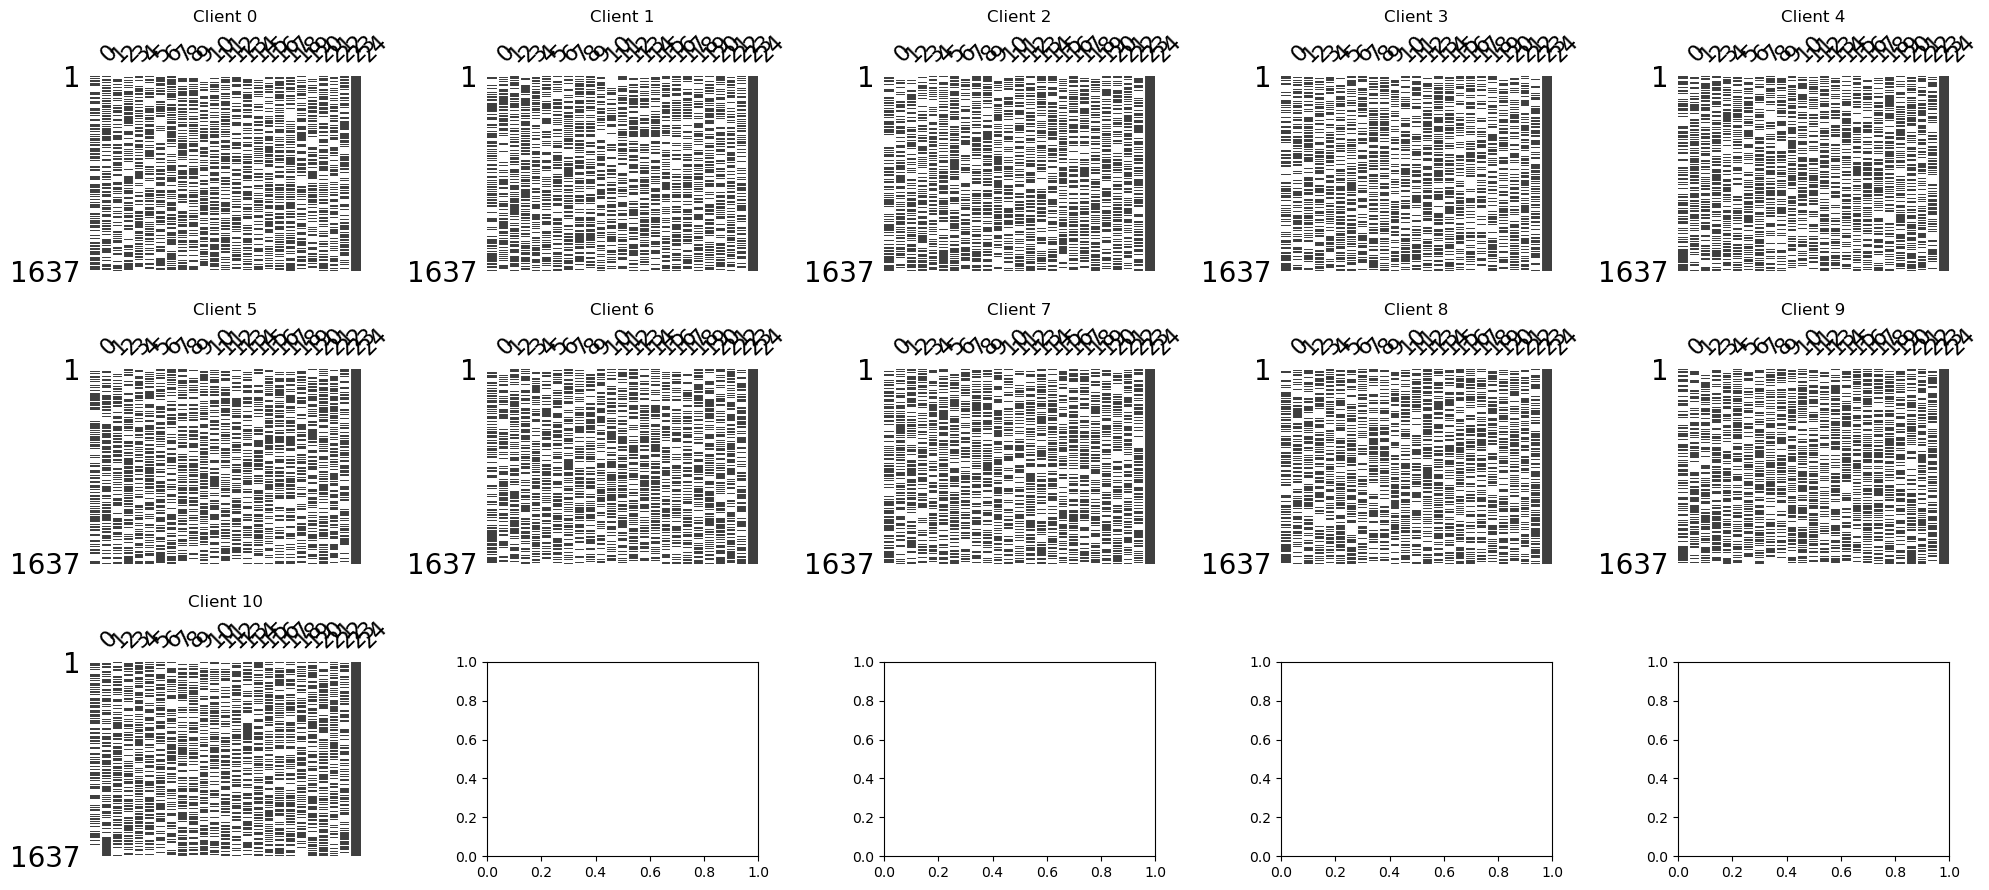

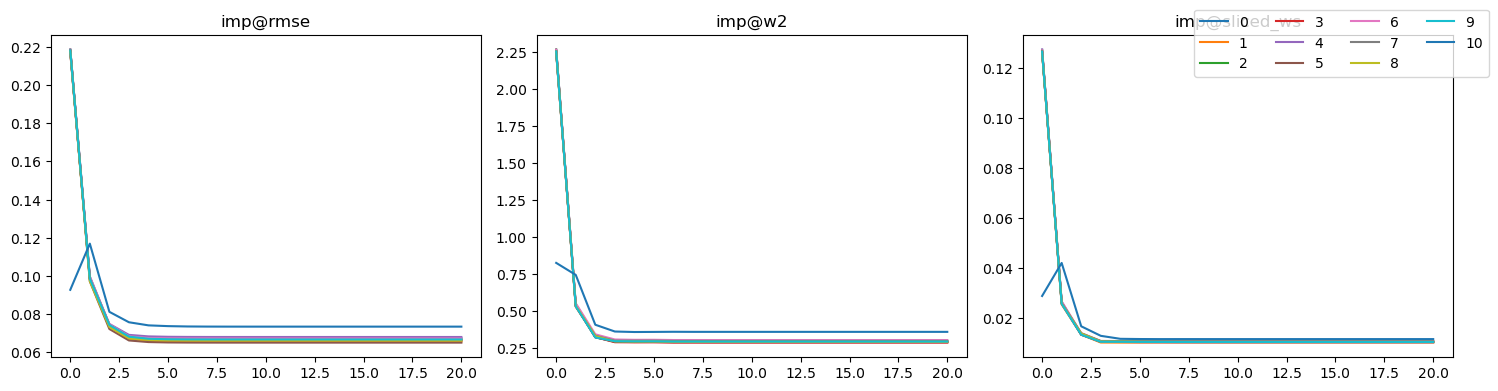

{'imp@rmse': 0.06710528456449294, 'imp@ws': 0.30127803771010836, 'imp@sliced_ws': 0.01078557309691197}


In [26]:
name = 'mnar_rl_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [28]:
pred_ret = NN_evaluation(
    rets['mnar_rl_heart_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl, imbalance='smotetm',
)

2023-08-13 15:18:33.519 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.6935, test_f1: 0.3301 test_auroc: 0.8162 train_loss: 0.5944 val_accu: 0.7383 val_f1: 0.7376 test recall 0.8343 precision 0.2057 b-accu 0.7569
2023-08-13 15:18:48.863 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.8020, test_f1: 0.3196 test_auroc: 0.7635 train_loss: 0.3708 val_accu: 0.8294 val_f1: 0.8285 test recall 0.5138 precision 0.2319 b-accu 0.6722
2023-08-13 15:19:04.259 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.8515, test_f1: 0.3012 test_auroc: 0.7545 train_loss: 0.3300 val_accu: 0.8630 val_f1: 0.8629 test recall 0.3536 precision 0.2623 b-accu 0.6273
2023-08-13 15:19:19.805 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.8085, test_f1: 0.2947 tes

0.895 0.8182687956165582 0.36984352773826457


# CodRNA

In [24]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

### Clients MNAR LR - Raw

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:01:40.863 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:01:40.864 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:02:52.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:02:52.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 23:03:56.920 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:03:56.921 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 23:04:03.161 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 146.77019060001476


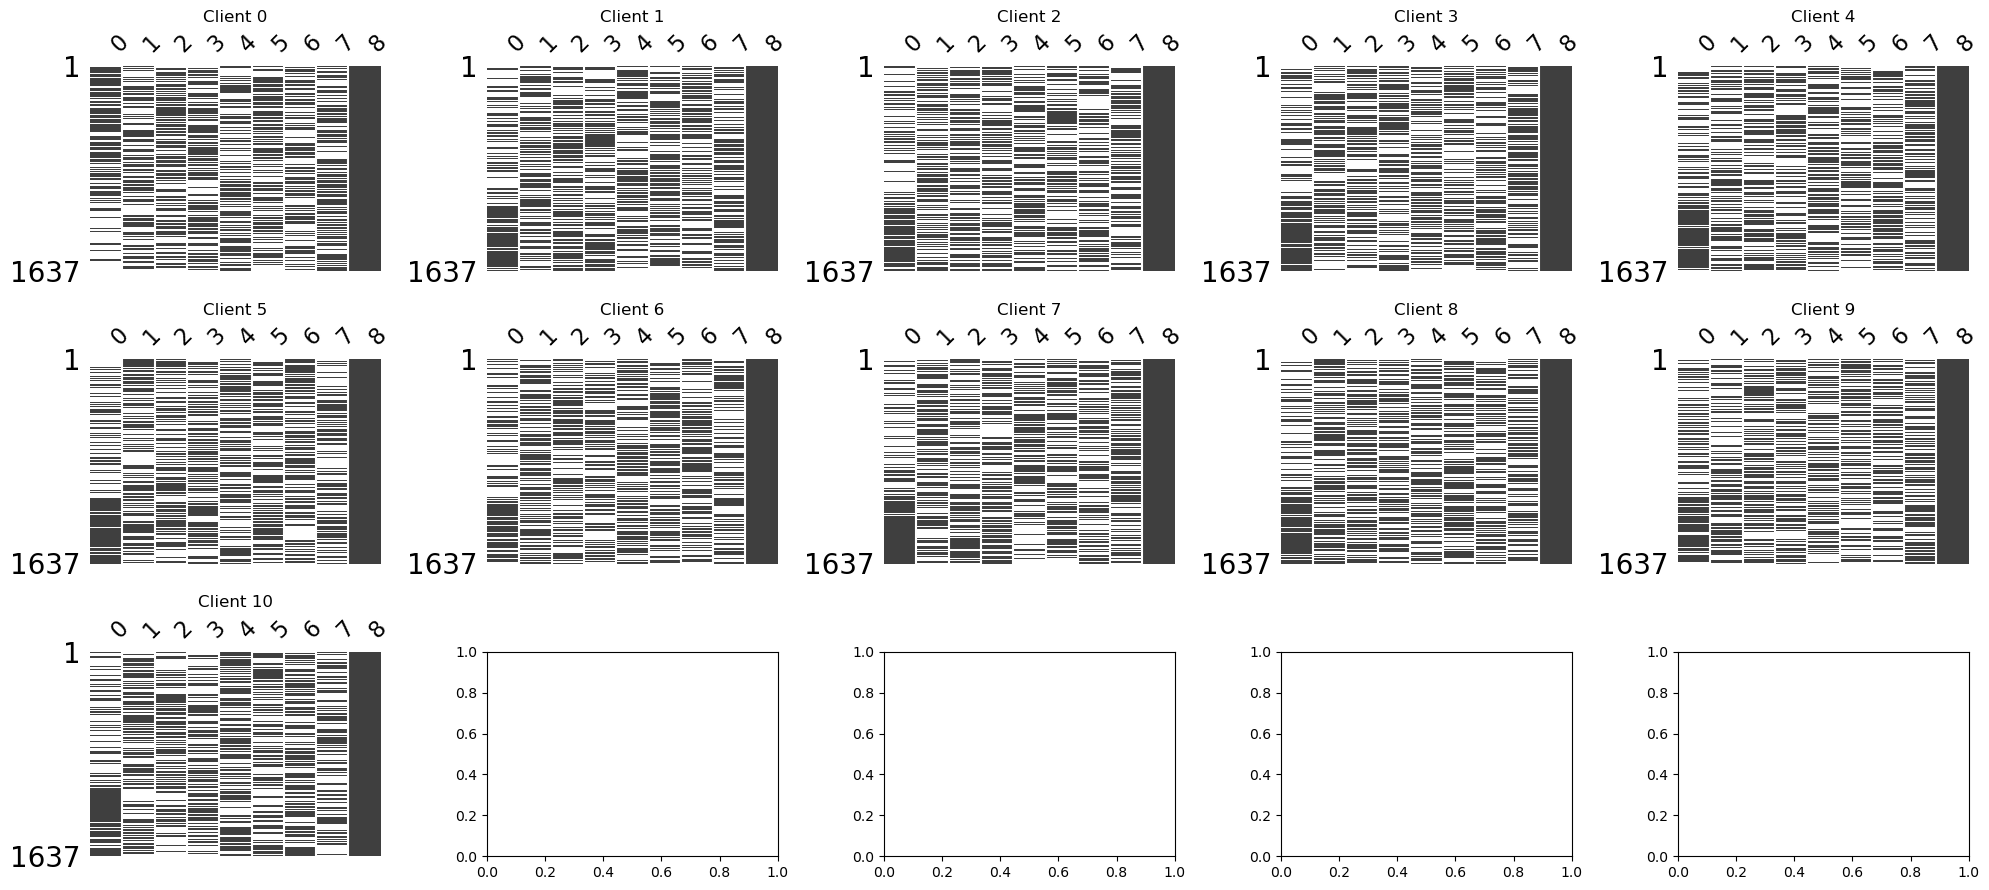

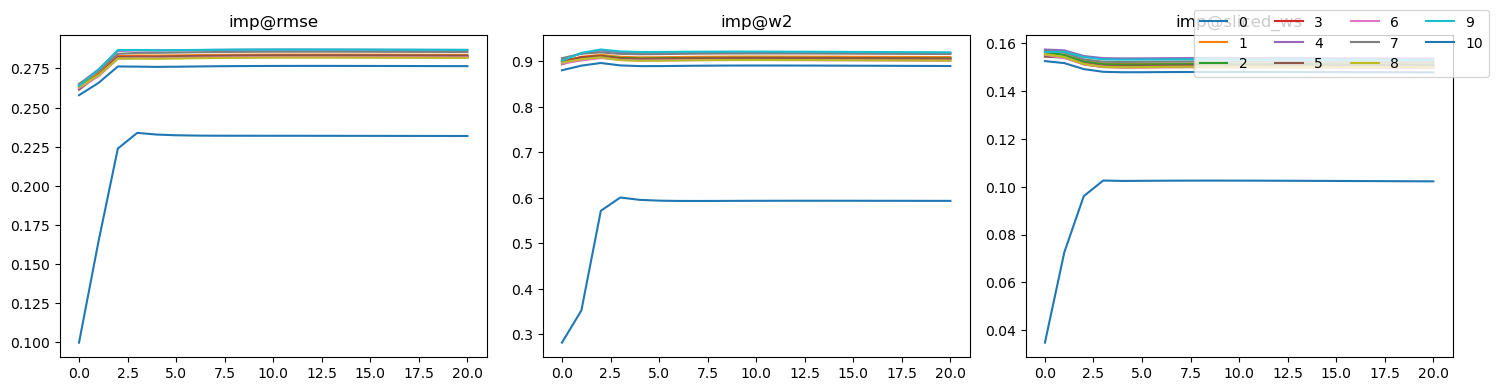

{'imp@rmse': 0.2785519656761988, 'imp@ws': 0.879445240163924, 'imp@sliced_ws': 0.14641462584120704}


2023-08-01 23:04:06.041 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6685, test_f1: 0.5357 test_auroc: 0.6691 train_loss: 0.6442 val_accu: 0.6677 val_f1: 0.4004
2023-08-01 23:04:36.870 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7275, test_f1: 0.6876 test_auroc: 0.7211 train_loss: 0.5014 val_accu: 0.7722 val_f1: 0.6895
2023-08-01 23:05:11.326 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7460, test_f1: 0.7099 test_auroc: 0.6843 train_loss: 0.4865 val_accu: 0.7788 val_f1: 0.7049
2023-08-01 23:05:43.448 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7555, test_f1: 0.7206 test_auroc: 0.6862 train_loss: 0.4840 val_accu: 0.7849 val_f1: 0.7130
2023-08-01 23:06:15.908 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7705 0.8719810114944085 0.7425047933884297


In [26]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:07:12.427 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:07:12.429 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:08:12.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:08:12.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 23:09:19.322 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:09:19.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 23:09:26.246 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 138.40663330000825


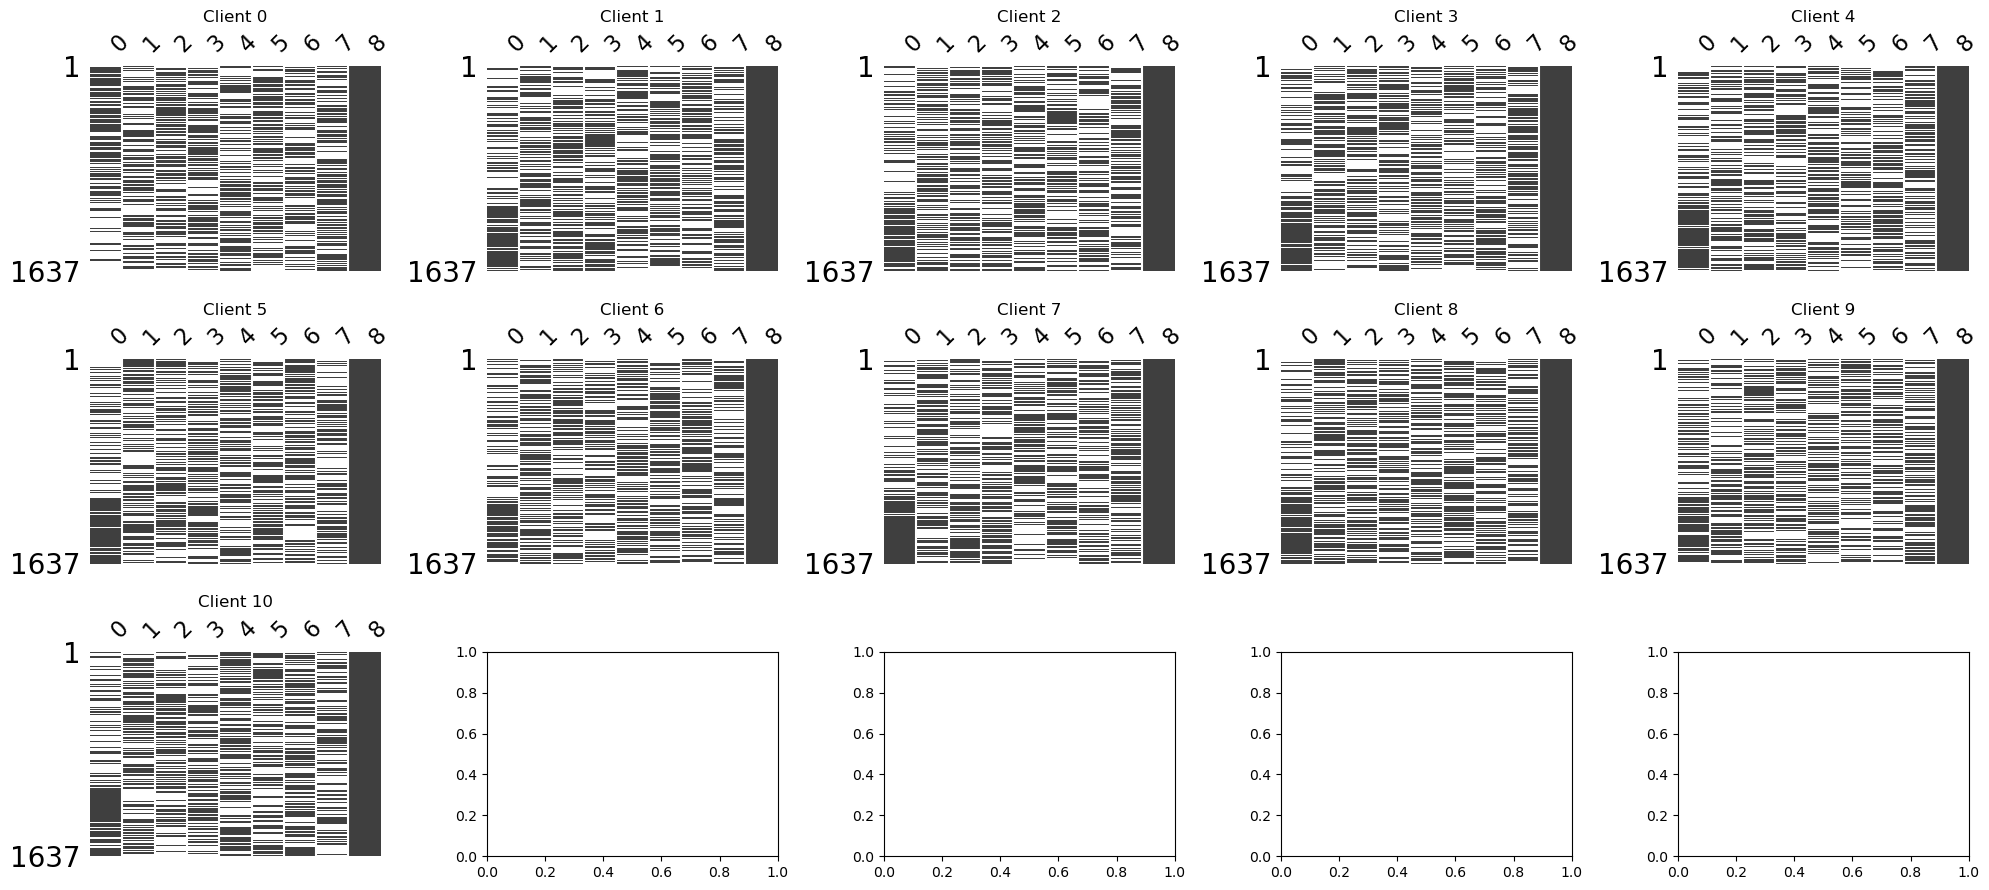

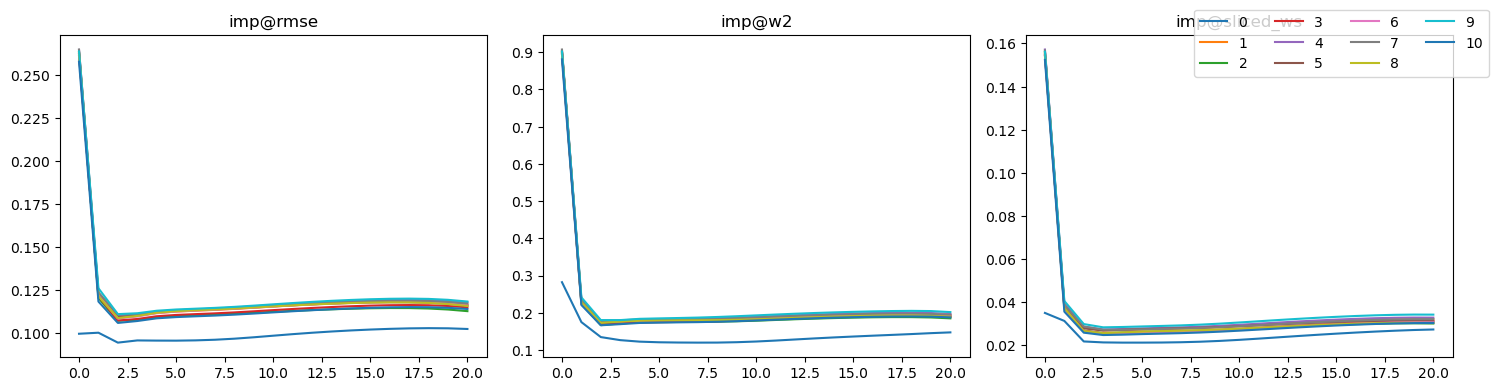

{'imp@rmse': 0.11586773569355435, 'imp@ws': 0.18970102076314835, 'imp@sliced_ws': 0.030813068405751064}


2023-08-01 23:09:29.141 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6685, test_f1: 0.5357 test_auroc: 0.6693 train_loss: 0.6379 val_accu: 0.6677 val_f1: 0.4004
2023-08-01 23:10:02.702 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9335, test_f1: 0.9343 test_auroc: 0.9804 train_loss: 0.3309 val_accu: 0.8523 val_f1: 0.8239
2023-08-01 23:10:35.249 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9280, test_f1: 0.9291 test_auroc: 0.9826 train_loss: 0.3225 val_accu: 0.8495 val_f1: 0.8244
2023-08-01 23:11:07.309 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9340, test_f1: 0.9344 test_auroc: 0.9827 train_loss: 0.3197 val_accu: 0.8611 val_f1: 0.8305
2023-08-01 23:11:39.226 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9415 0.9855837623007317 0.941785346252336


In [27]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Clients MNAR LR - Balanced

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:25:29.752 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:25:29.752 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:26:20.180 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:26:20.181 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 23:27:18.878 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:27:18.879 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 23:27:24.894 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 119.29137569997692


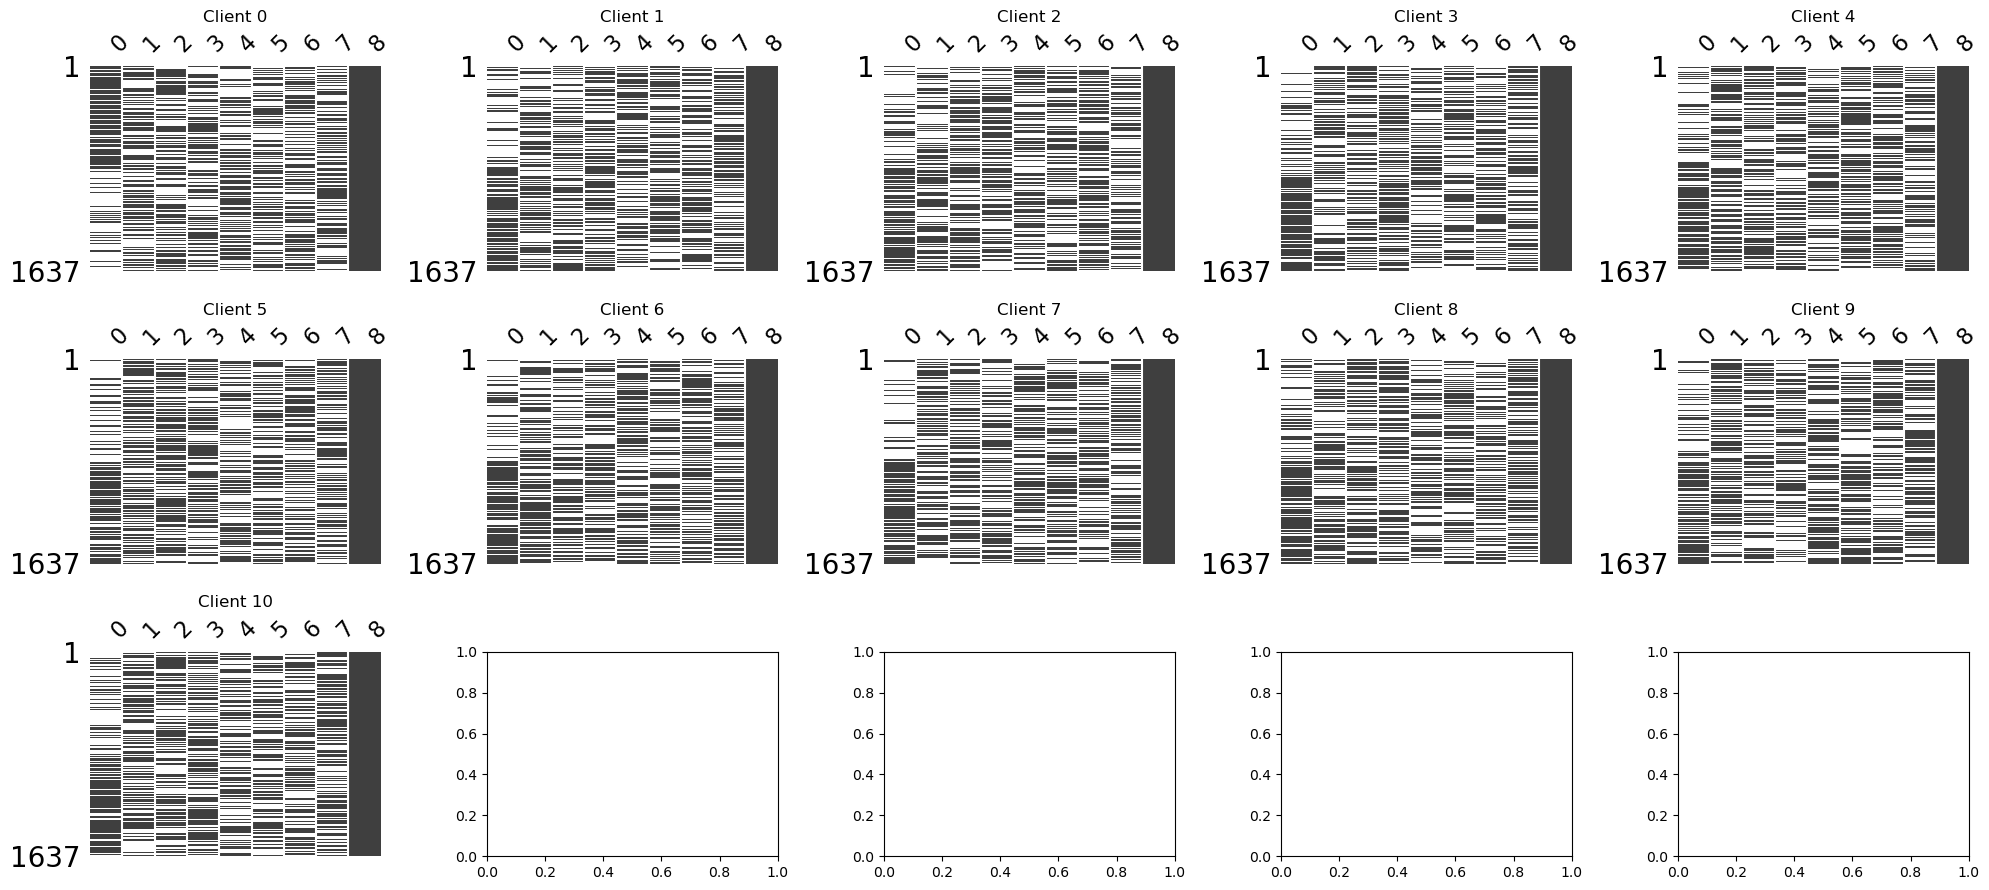

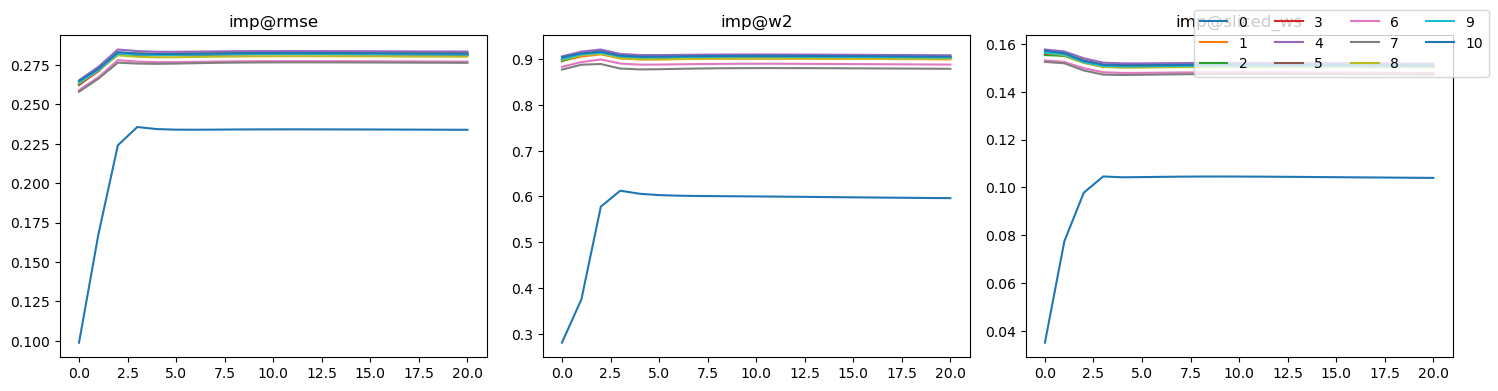

{'imp@rmse': 0.2766938221574742, 'imp@ws': 0.872385524845495, 'imp@sliced_ws': 0.14592132468481242}


2023-08-01 23:27:27.321 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.5465, test_f1: 0.5037 test_auroc: 0.6430 train_loss: 0.6897 val_accu: 0.5324 val_f1: 0.4149
2023-08-01 23:27:56.906 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.6270, test_f1: 0.5789 test_auroc: 0.8330 train_loss: 0.5799 val_accu: 0.6752 val_f1: 0.6587
2023-08-01 23:28:29.688 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.6290, test_f1: 0.5852 test_auroc: 0.7638 train_loss: 0.5571 val_accu: 0.6982 val_f1: 0.6837
2023-08-01 23:29:00.104 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.6425, test_f1: 0.6015 test_auroc: 0.6138 train_loss: 0.5476 val_accu: 0.7012 val_f1: 0.6970
2023-08-01 23:29:31.892 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.692 0.8566594266377066 0.6719781096563012


In [30]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:30:25.794 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:30:25.795 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:31:23.002 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:31:23.003 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10


KeyboardInterrupt: 

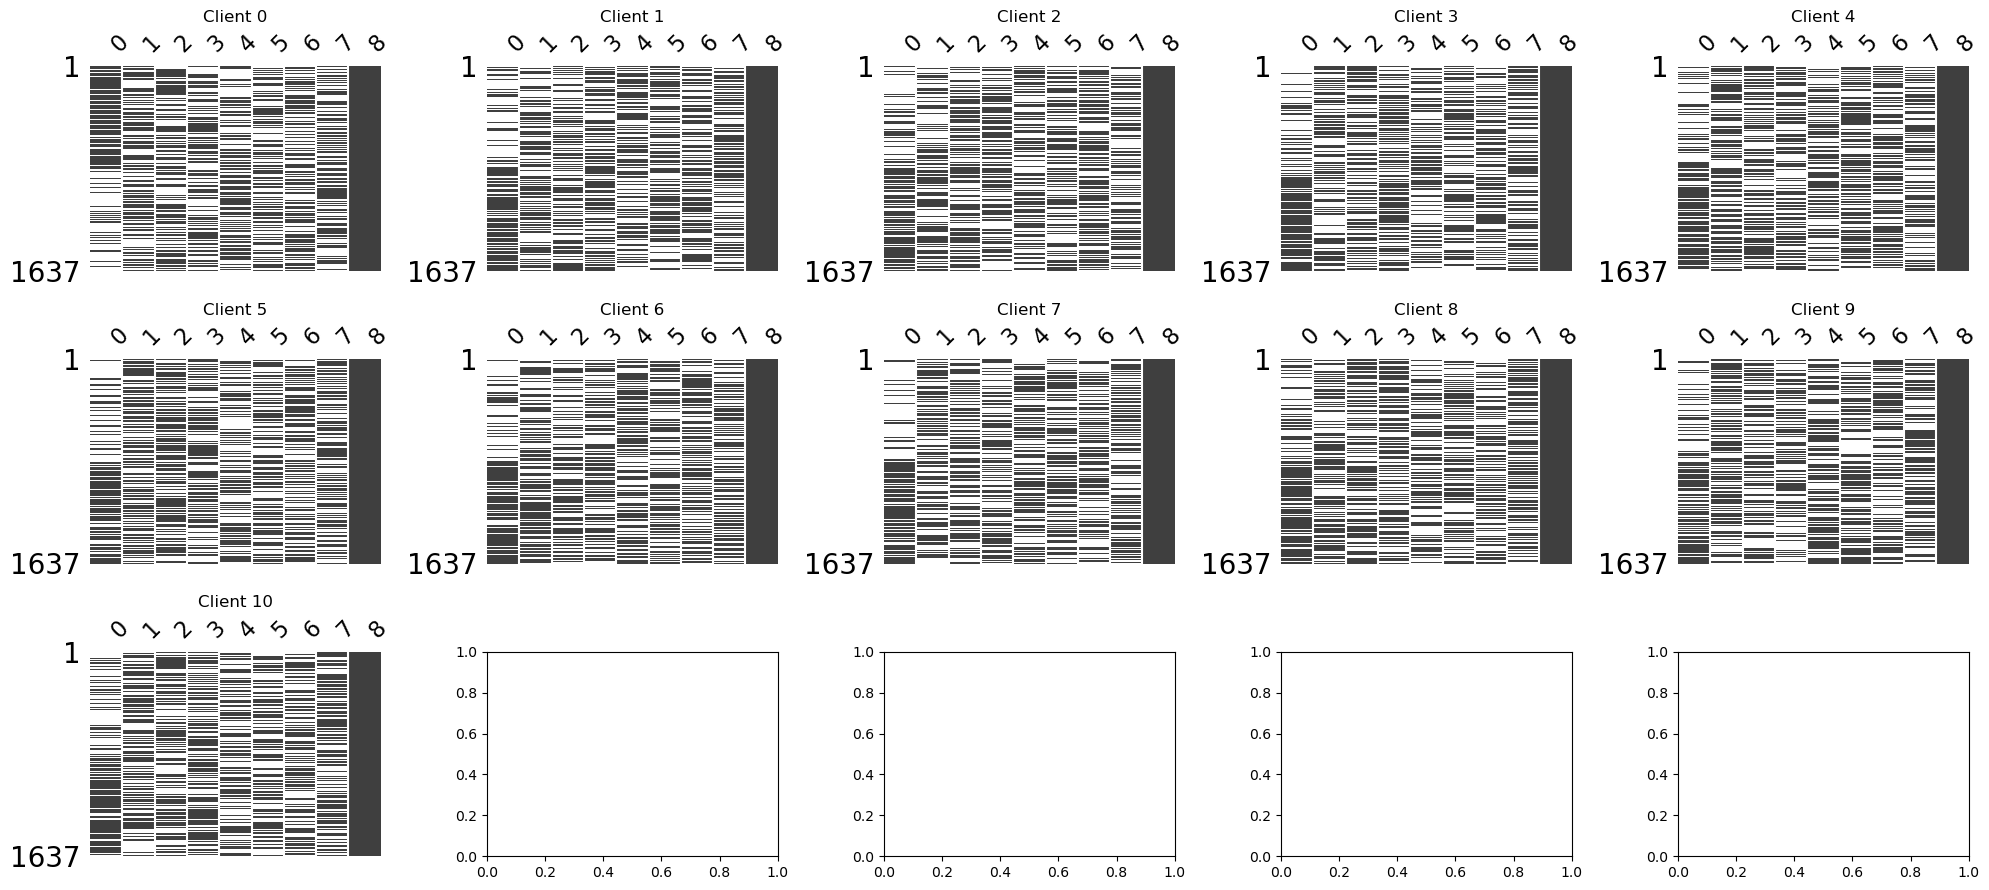

In [31]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# Skin

In [5]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

### Clients MNAR LR Raw

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-03 17:04:21.690 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:04:21.691 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 17:05:17.599 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:05:17.599 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 17:06:11.929 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:06:11.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 17:06:17.387 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 120.34287039999617


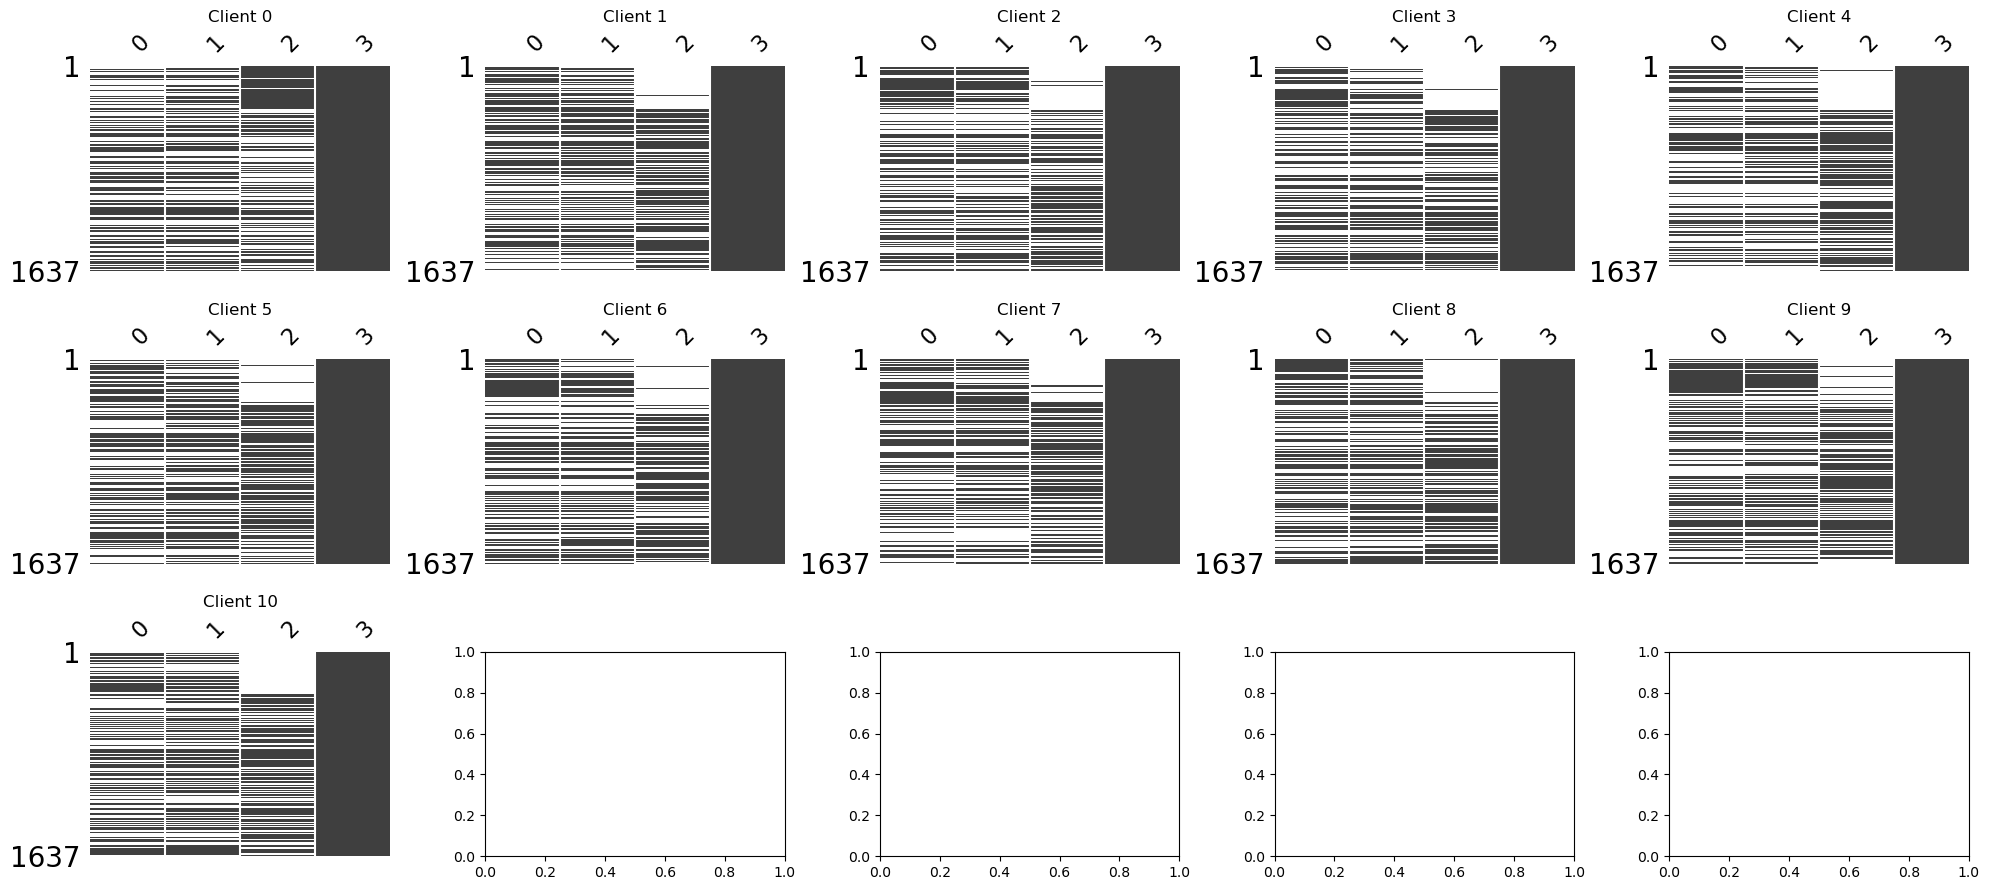

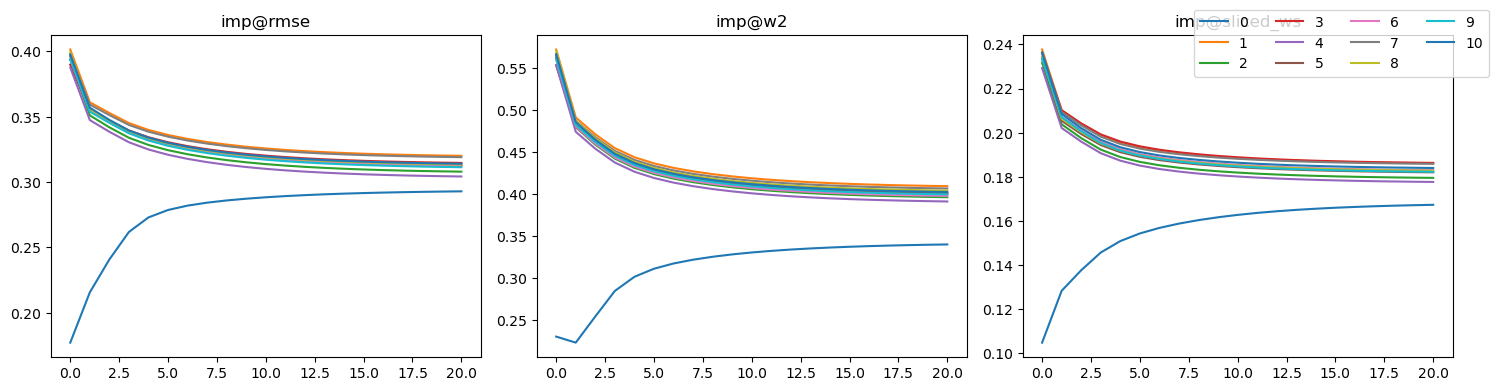

{'imp@rmse': 0.3116160778896943, 'imp@ws': 0.3964372820923634, 'imp@sliced_ws': 0.1816194790056735}


In [35]:
name = 'mnar_lr_skin_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [40]:
name = 'mnar_lr_skin_fedavg-s'
pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)


2023-08-03 17:27:38.467 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.9385, test_f1: 0.9162 test_auroc: 0.9551 train_loss: 0.5272 val_accu: 0.6590 val_f1: 0.6505
2023-08-03 17:27:48.923 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.9495, test_f1: 0.9301 test_auroc: 0.9617 train_loss: 0.3001 val_accu: 0.8215 val_f1: 0.8187
2023-08-03 17:27:59.660 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.9550, test_f1: 0.9372 test_auroc: 0.9599 train_loss: 0.3362 val_accu: 0.8057 val_f1: 0.7996
2023-08-03 17:28:09.331 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.9655, test_f1: 0.9511 test_auroc: 0.9660 train_loss: 0.2824 val_accu: 0.8177 val_f1: 0.8121
2023-08-03 17:28:19.777 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.975 0.9811489331720311 0.9636373685672687


(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-03 17:11:09.740 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:11:09.741 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 17:11:55.667 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:11:55.667 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 17:12:46.582 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:12:46.583 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 17:12:51.861 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 106.55827270000009


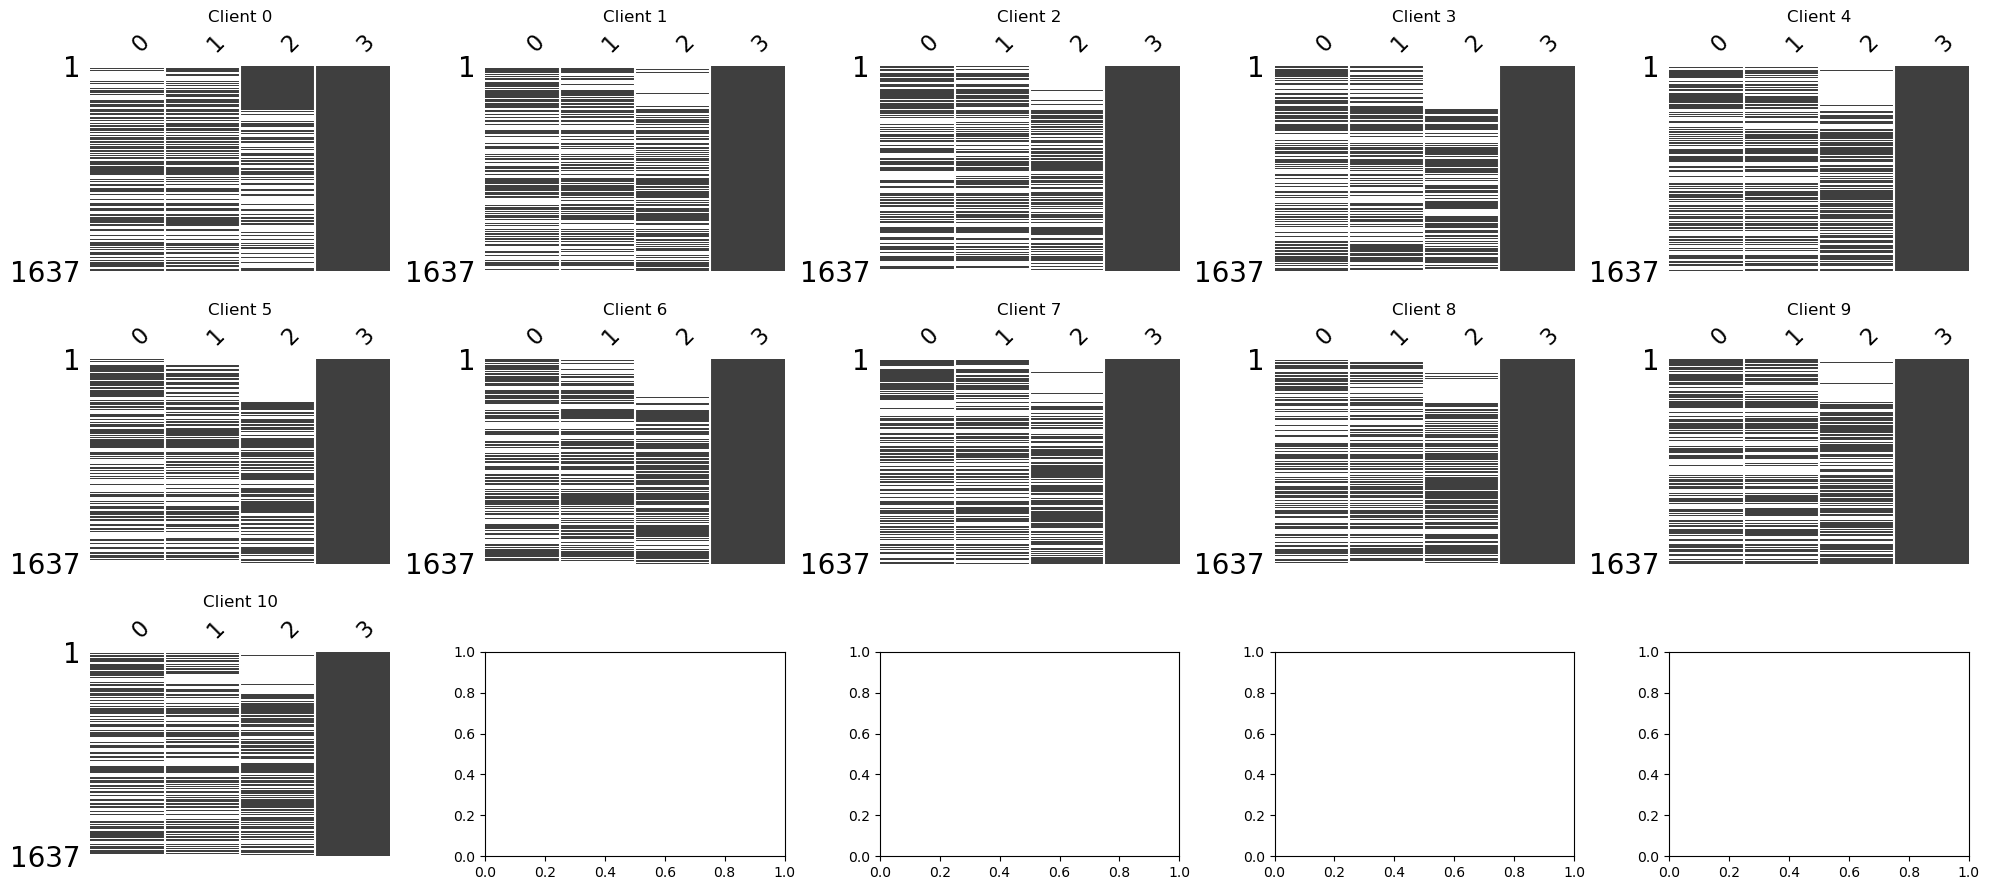

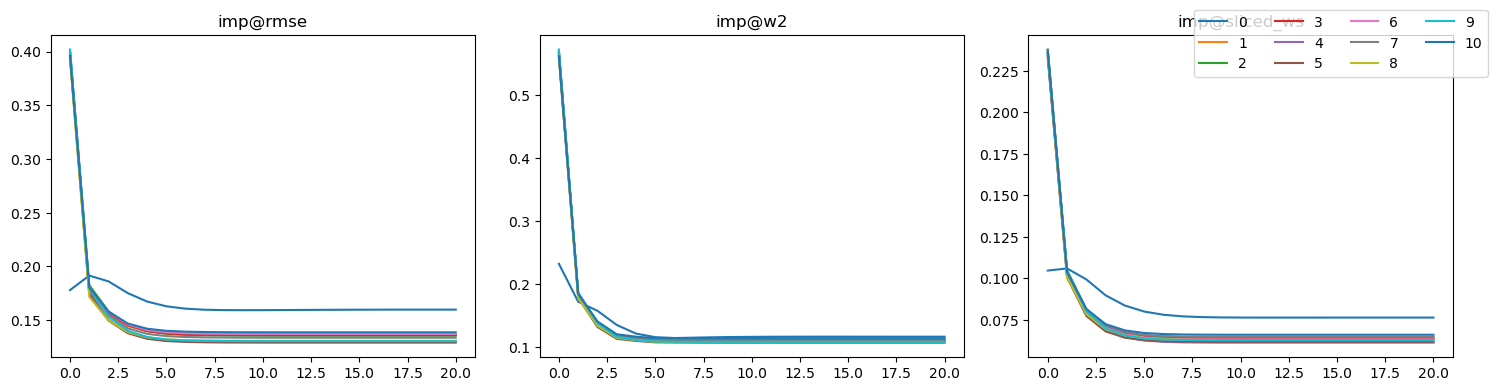

{'imp@rmse': 0.13604810628765834, 'imp@ws': 0.10977185705323872, 'imp@sliced_ws': 0.06426891285482048}


In [37]:
name = 'mnar_lr_skin_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [41]:
name = 'mnar_lr_skin_fedmechw'
pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)


2023-08-03 17:32:43.128 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.9410, test_f1: 0.9188 test_auroc: 0.9864 train_loss: 0.3259 val_accu: 0.8431 val_f1: 0.8393
2023-08-03 17:32:53.371 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.9285, test_f1: 0.9034 test_auroc: 0.9902 train_loss: 0.2545 val_accu: 0.8466 val_f1: 0.8431
2023-08-03 17:33:03.811 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.9885, test_f1: 0.9830 test_auroc: 0.9968 train_loss: 0.2483 val_accu: 0.8521 val_f1: 0.8489
2023-08-03 17:33:13.560 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.9730, test_f1: 0.9605 test_auroc: 0.9947 train_loss: 0.2478 val_accu: 0.8508 val_f1: 0.8479
2023-08-03 17:33:24.175 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.995 0.9983694996986135 0.9925045459928553


### Clients MNAR LR Balanced

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-02 07:42:43.074 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:42:43.075 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 07:43:28.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:43:28.573 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 07:44:18.681 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:44:18.683 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 07:44:23.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 105.3024771999917


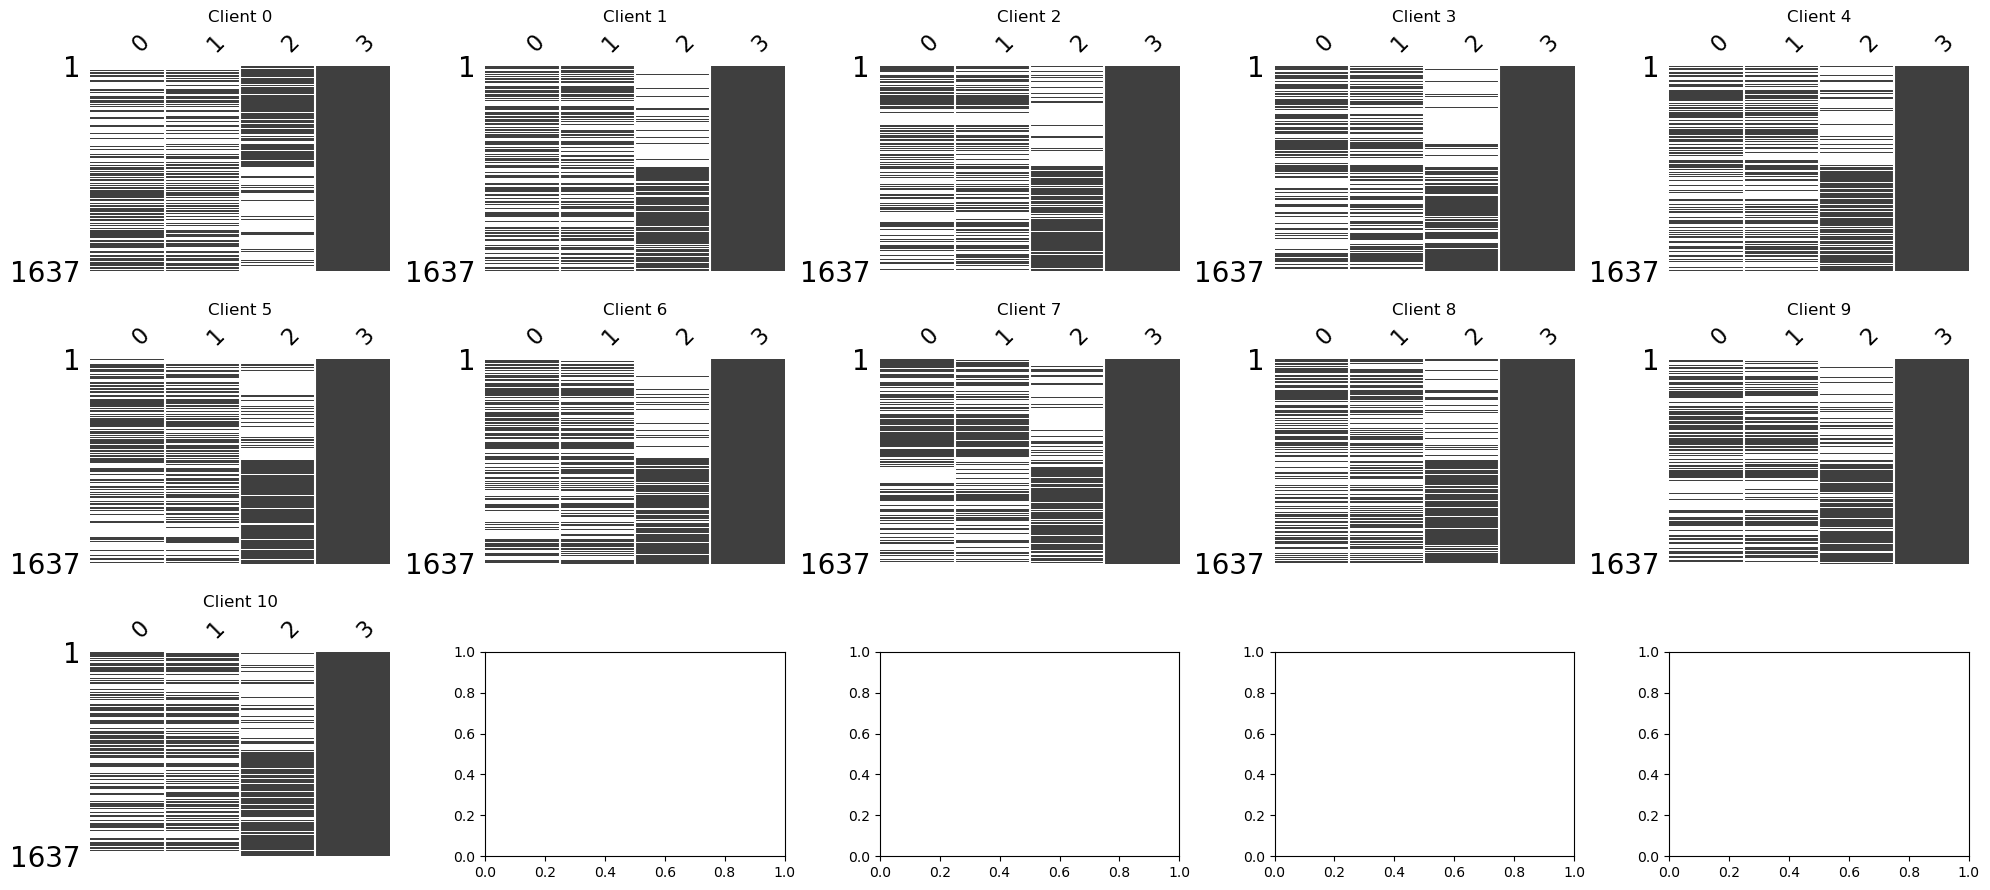

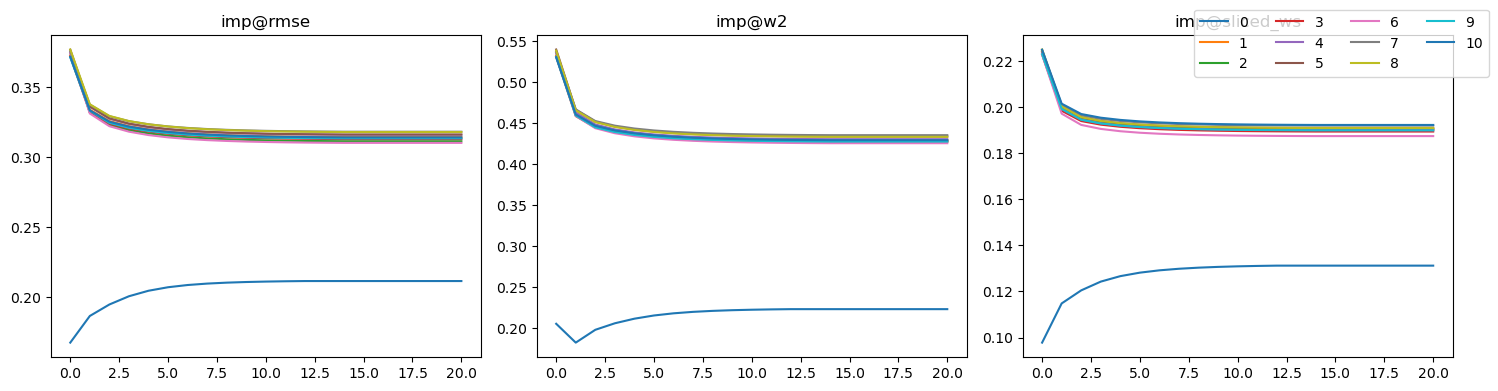

{'imp@rmse': 0.3049032655457182, 'imp@ws': 0.4110403674989737, 'imp@sliced_ws': 0.1850156303977069}


2023-08-02 07:44:25.965 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.9340, test_f1: 0.9338 test_auroc: 0.9634 train_loss: 0.6139 val_accu: 0.7120 val_f1: 0.6927
2023-08-02 07:44:58.212 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9425, test_f1: 0.9425 test_auroc: 0.9665 train_loss: 0.3648 val_accu: 0.8562 val_f1: 0.8545
2023-08-02 07:45:30.525 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9290, test_f1: 0.9290 test_auroc: 0.9738 train_loss: 0.3226 val_accu: 0.7744 val_f1: 0.7652
2023-08-02 07:46:02.767 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9270, test_f1: 0.9270 test_auroc: 0.9821 train_loss: 0.3067 val_accu: 0.8603 val_f1: 0.8585
2023-08-02 07:46:35.547 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9665 0.9874281713385512 0.9664809410381929


In [9]:
name = 'mnar_lr_skin_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-02 07:47:12.545 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:47:12.546 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 07:47:59.129 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:47:59.130 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 07:48:51.571 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:48:51.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 07:48:56.780 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 108.65288740000688


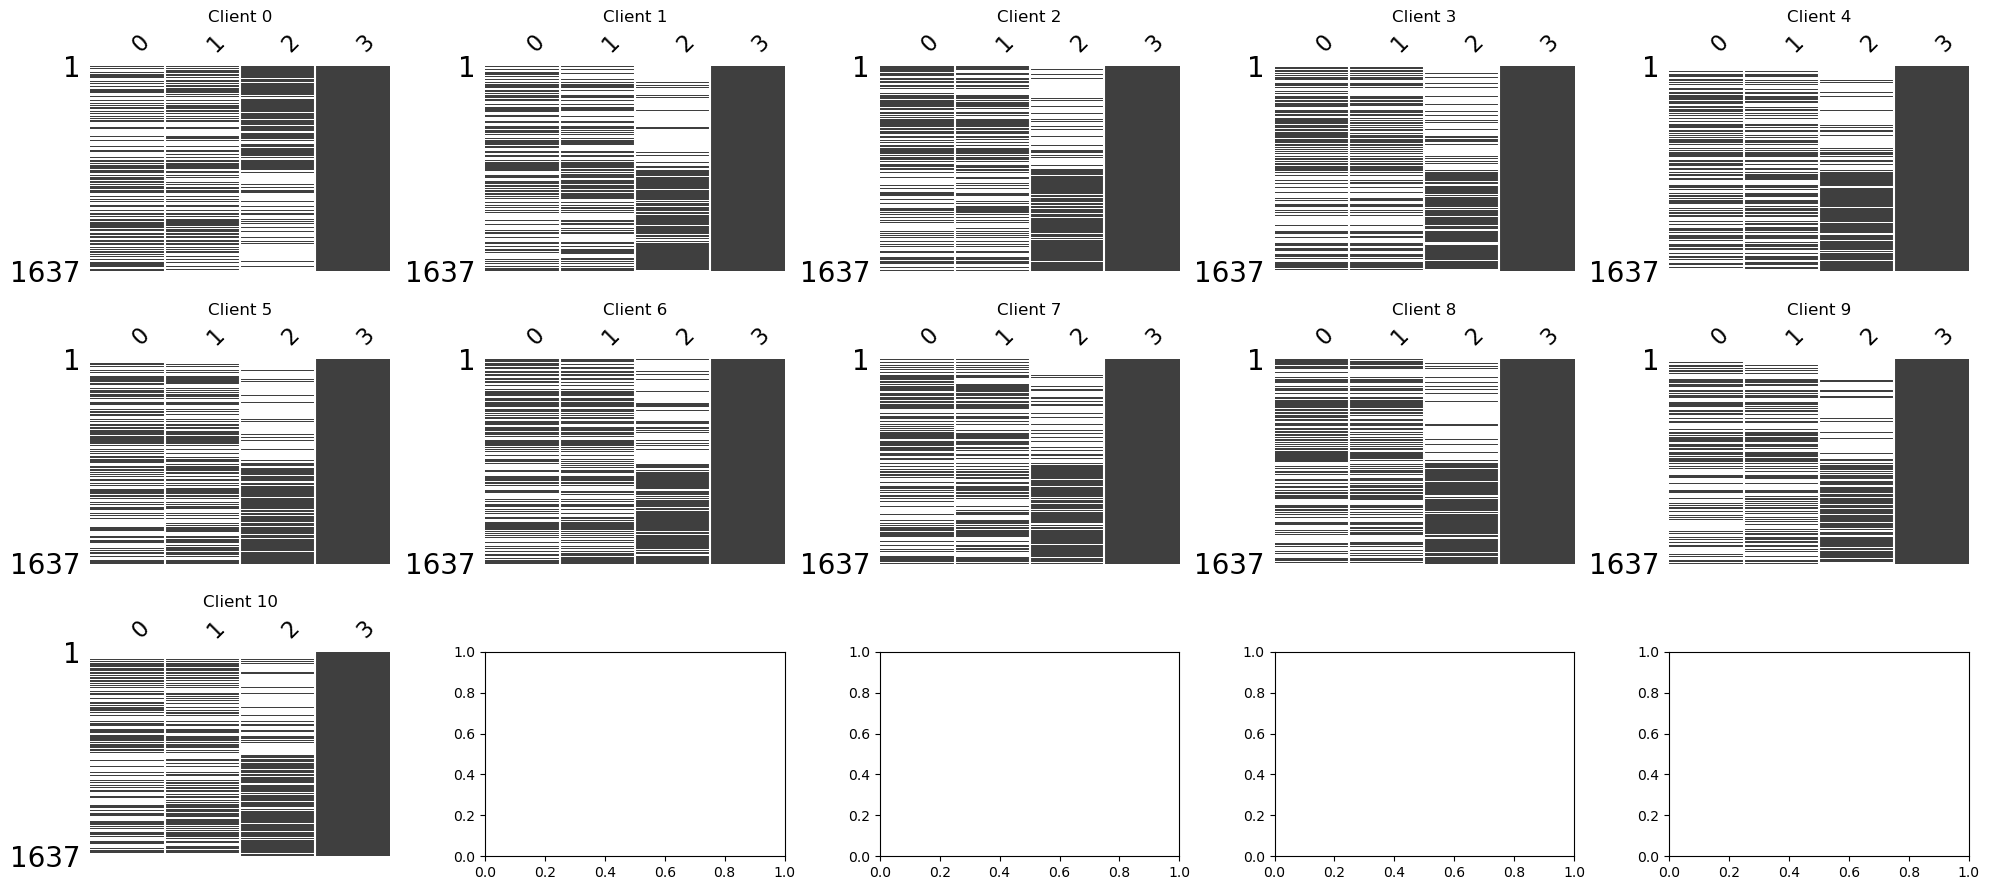

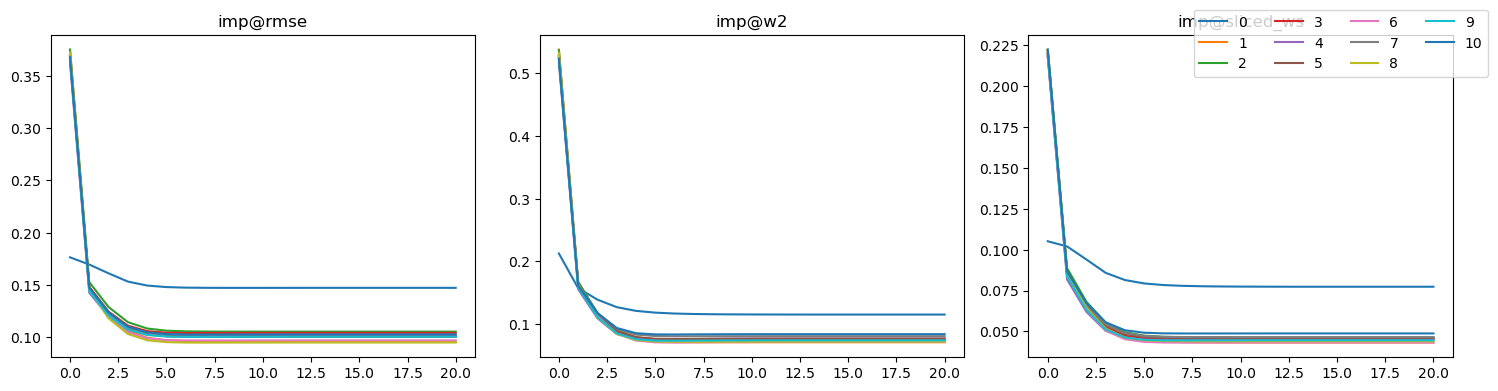

{'imp@rmse': 0.10445517429024381, 'imp@ws': 0.07927942215971757, 'imp@sliced_ws': 0.048169093063679246}


2023-08-02 07:48:58.833 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.9590, test_f1: 0.9589 test_auroc: 0.9521 train_loss: 0.4749 val_accu: 0.9113 val_f1: 0.9107
2023-08-02 07:49:30.032 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9830, test_f1: 0.9830 test_auroc: 0.9940 train_loss: 0.1954 val_accu: 0.9282 val_f1: 0.9279
2023-08-02 07:50:00.744 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9860, test_f1: 0.9860 test_auroc: 0.9979 train_loss: 0.1923 val_accu: 0.9310 val_f1: 0.9307
2023-08-02 07:50:38.448 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9860, test_f1: 0.9860 test_auroc: 0.9975 train_loss: 0.1905 val_accu: 0.9304 val_f1: 0.9302
2023-08-02 07:51:13.261 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9915 0.9987058434070523 0.9914985905890714


In [10]:
name = 'mnar_lr_skin_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# Codon

In [12]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

### MNAR Clients LR

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1301, 26)


2023-08-02 08:30:46.644 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:30:46.646 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 08:31:55.637 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:31:55.638 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 08:33:09.489 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:33:09.489 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 08:33:16.462 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 152.67422590003116


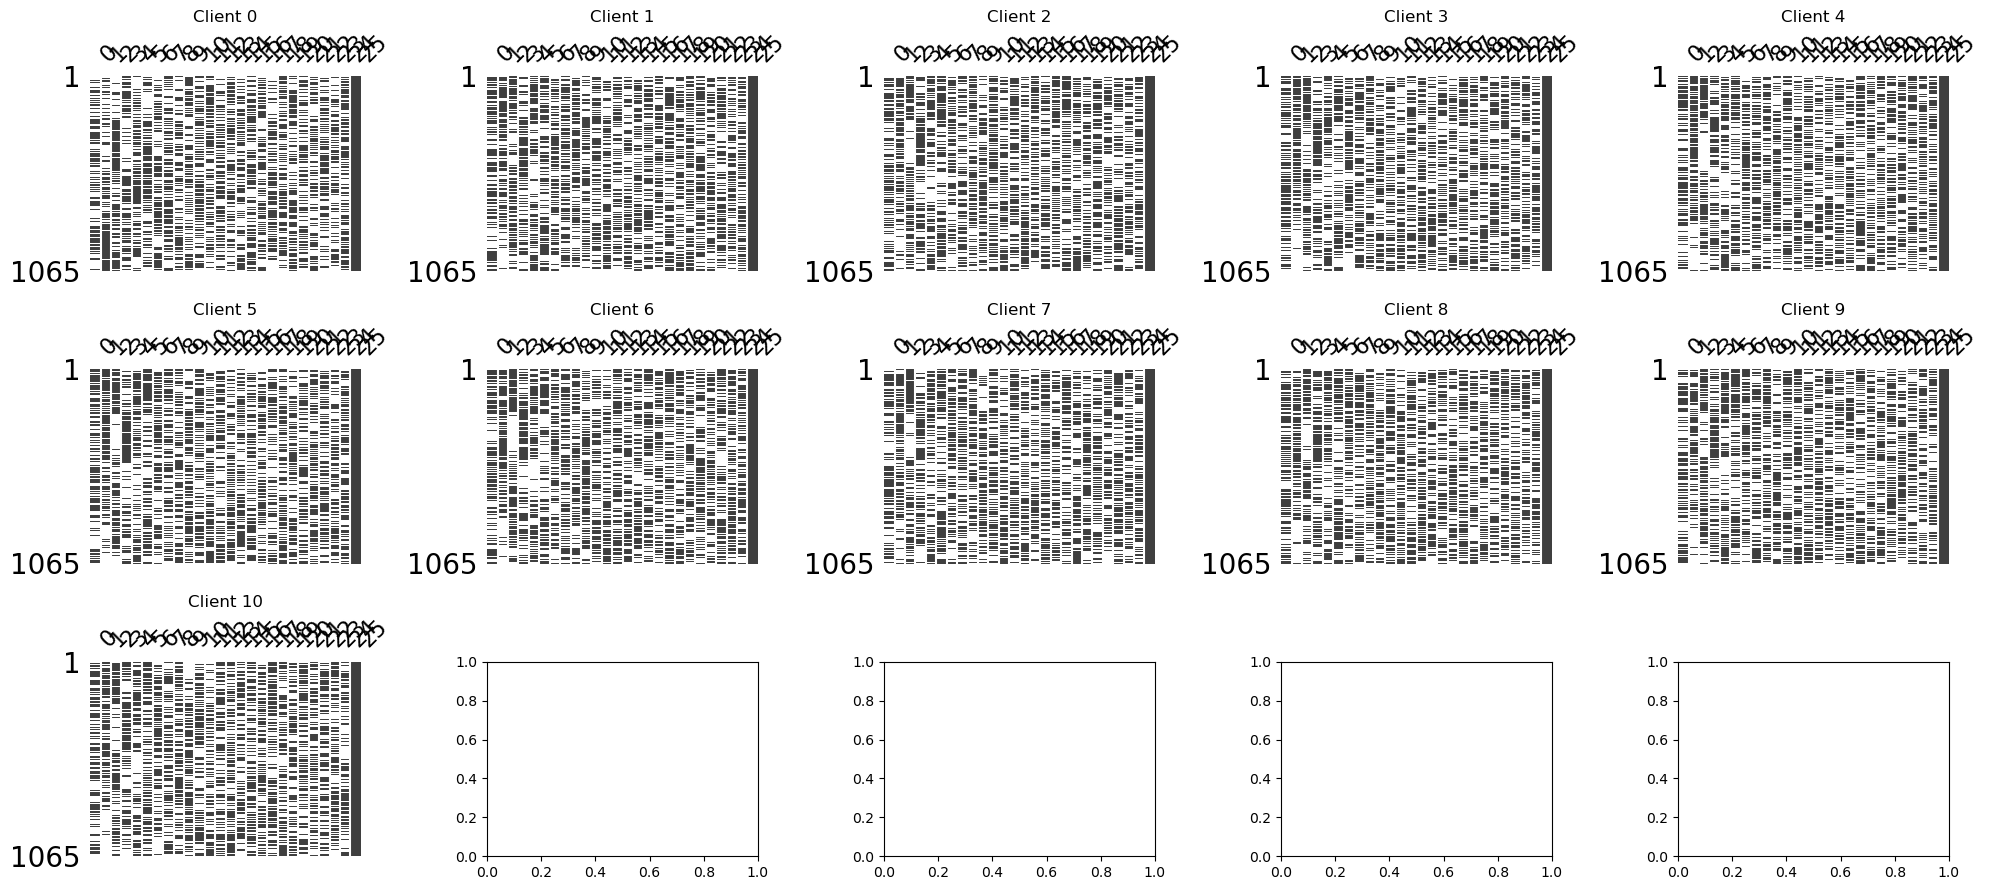

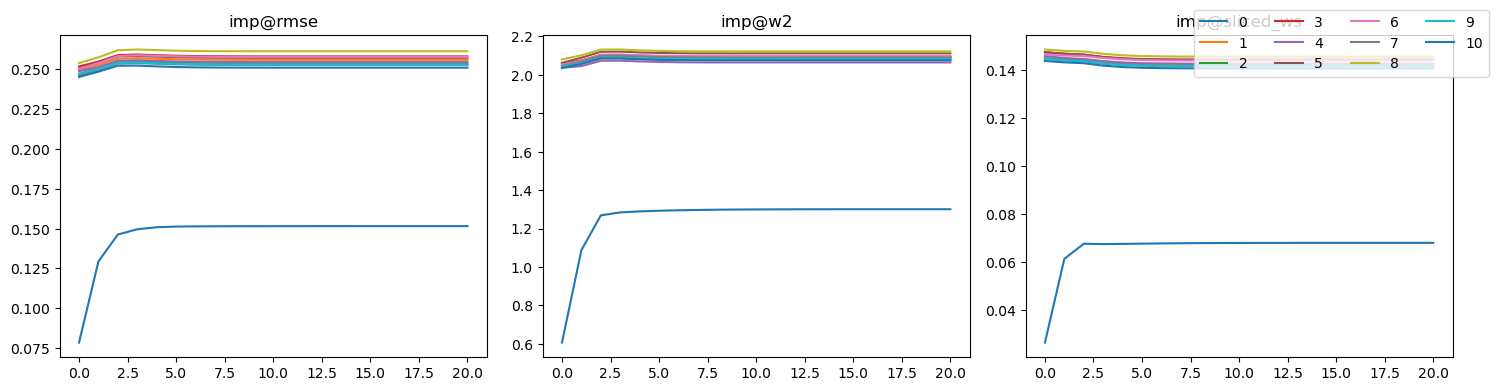

{'imp@rmse': 0.24613234782972357, 'imp@ws': 2.01805463508386, 'imp@sliced_ws': 0.13616762138704153}


2023-08-02 08:33:20.021 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.2183, test_f1: 0.0806 test_auroc: 0.7852 train_loss: 2.0358 val_accu: 0.2207 val_f1: 0.0404
2023-08-02 08:33:46.392 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.6826, test_f1: 0.6465 test_auroc: 0.9507 train_loss: 1.2545 val_accu: 0.5625 val_f1: 0.3224
2023-08-02 08:34:12.541 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.6879, test_f1: 0.6621 test_auroc: 0.9545 train_loss: 1.1059 val_accu: 0.5971 val_f1: 0.3668
2023-08-02 08:34:37.638 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.6749, test_f1: 0.6480 test_auroc: 0.9501 train_loss: 1.0417 val_accu: 0.6214 val_f1: 0.3882
2023-08-02 08:35:03.689 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7002305918524212 0.9573200588259659 0.6705442531540108


In [15]:
name = 'mnar_lr_codon_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codon'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1301, 26)


2023-08-02 08:41:54.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:41:54.817 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 08:43:06.498 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:43:06.499 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 08:44:18.778 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:44:18.779 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 08:44:26.144 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 154.13708709995262


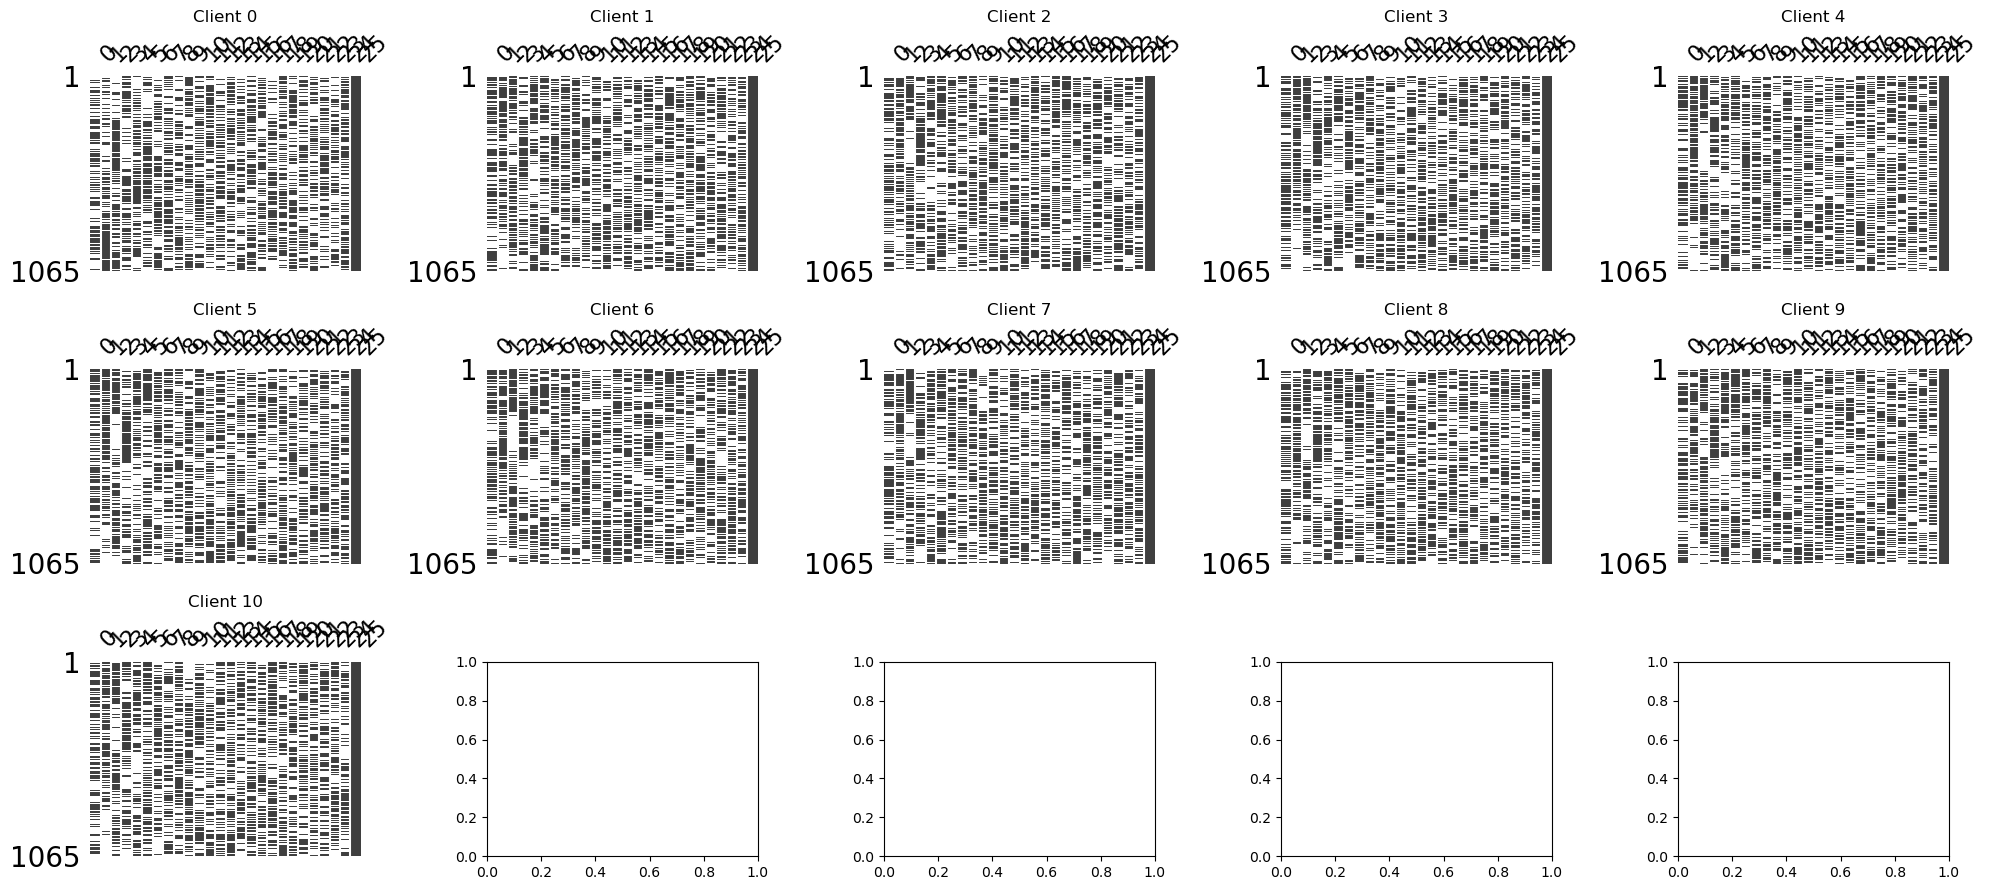

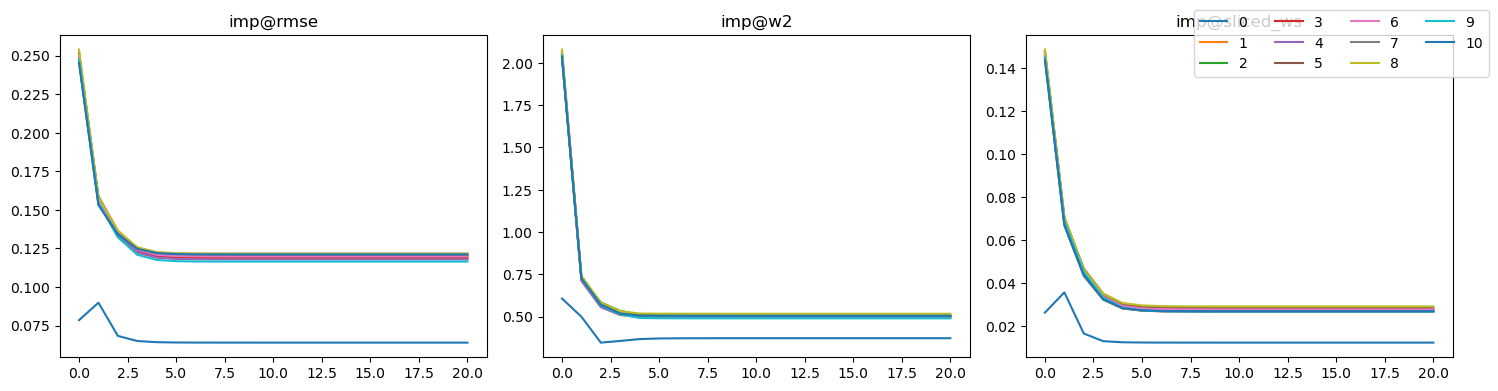

{'imp@rmse': 0.11453043431897561, 'imp@ws': 0.48896923900419104, 'imp@sliced_ws': 0.026248099440013356}


2023-08-02 08:44:29.890 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.3989, test_f1: 0.2708 test_auroc: 0.8347 train_loss: 2.0237 val_accu: 0.3824 val_f1: 0.1170
2023-08-02 08:44:55.494 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8540, test_f1: 0.8440 test_auroc: 0.9889 train_loss: 0.4005 val_accu: 0.8451 val_f1: 0.6733
2023-08-02 08:45:21.018 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.8601, test_f1: 0.8507 test_auroc: 0.9899 train_loss: 0.3483 val_accu: 0.8592 val_f1: 0.7112
2023-08-02 08:45:47.358 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8640, test_f1: 0.8559 test_auroc: 0.9901 train_loss: 0.3257 val_accu: 0.8609 val_f1: 0.7059
2023-08-02 08:46:13.161 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8731744811683321 0.9904368089900297 0.8678631432986038


In [16]:
name = 'mnar_lr_codon_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codon'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# Diabetic

## MNAR LR Balanced

(101766, 50)
(69569, 43)
(12304, 40)
(11073, 40) (1231, 40)
(11073, 40)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1231, 40)


2023-08-13 15:54:00.938 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:54:00.938 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 15:55:02.832 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:55:02.833 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 15:56:06.091 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 15:56:06.091 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 15:56:12.461 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 133.00582120000036


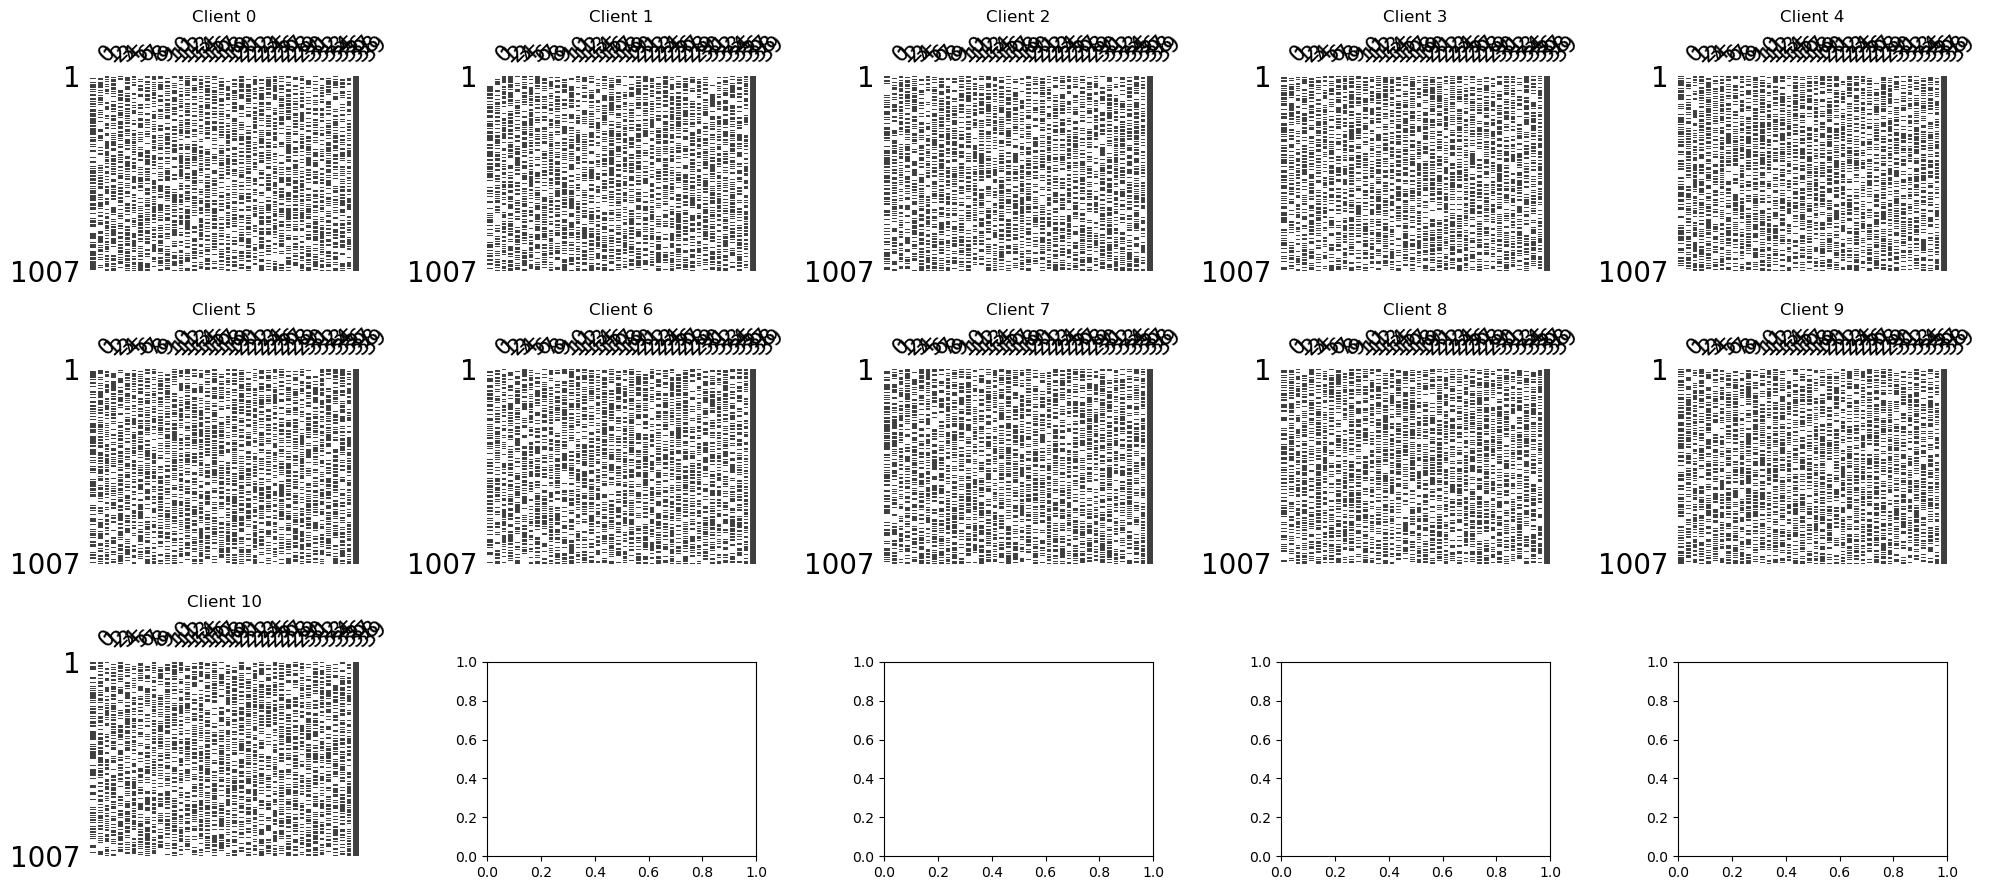

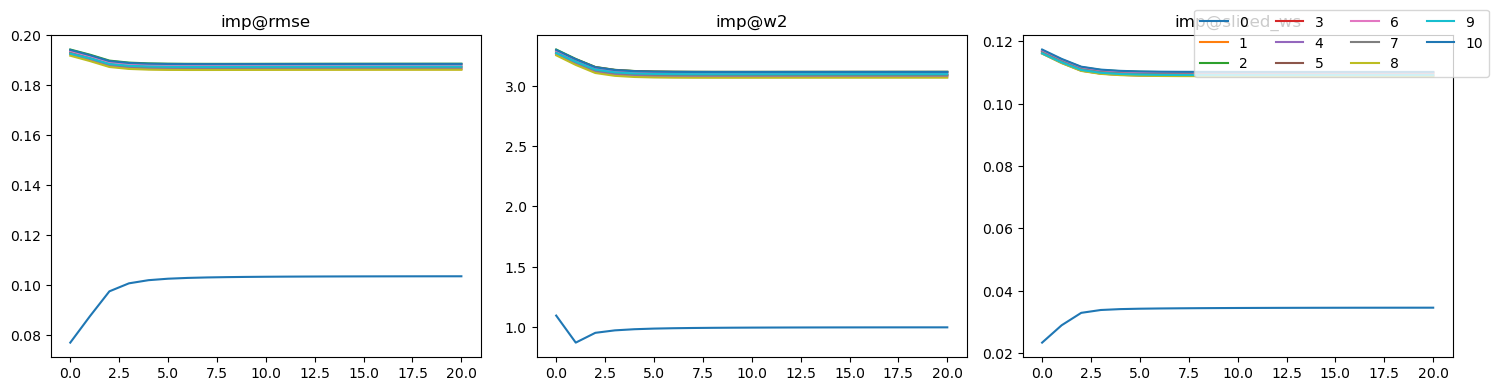

{'imp@rmse': 0.1798108449703412, 'imp@ws': 2.907739919209964, 'imp@sliced_ws': 0.10270709437035162}


In [38]:
name = 'mnar_lr_diabetic_balanced_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic_balanced'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [108]:
pred_ret = NN_evaluation(
    rets['mnar_lr_diabetic_balanced_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl
)

2023-08-15 13:54:03.613 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.5061, test_f1: 0.6176 test_auroc: 0.5329 train_loss: 0.6937 val_accu: 0.5216 val_f1: 0.4254 test recall 0.7984 precision 0.5036 b-accu 0.5063
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-08-15 13:54:03.855 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.4996, test_f1: 0.6663 test_auroc: 0.5375 train_loss: 0.6932 val_accu: 0.5000 val_f1: 0.3333 test recall 1.0000 precision 0.4996 b-accu 0.5000
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set

KeyboardInterrupt: 

(101766, 50)
(69569, 43)
(12304, 40)
(11073, 40) (1231, 40)
(11073, 40)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1231, 40)


2023-08-13 16:00:36.490 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:00:36.490 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 16:01:46.102 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:01:46.103 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 16:03:03.058 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:03:03.060 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 16:03:11.272 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 156.3069531999936


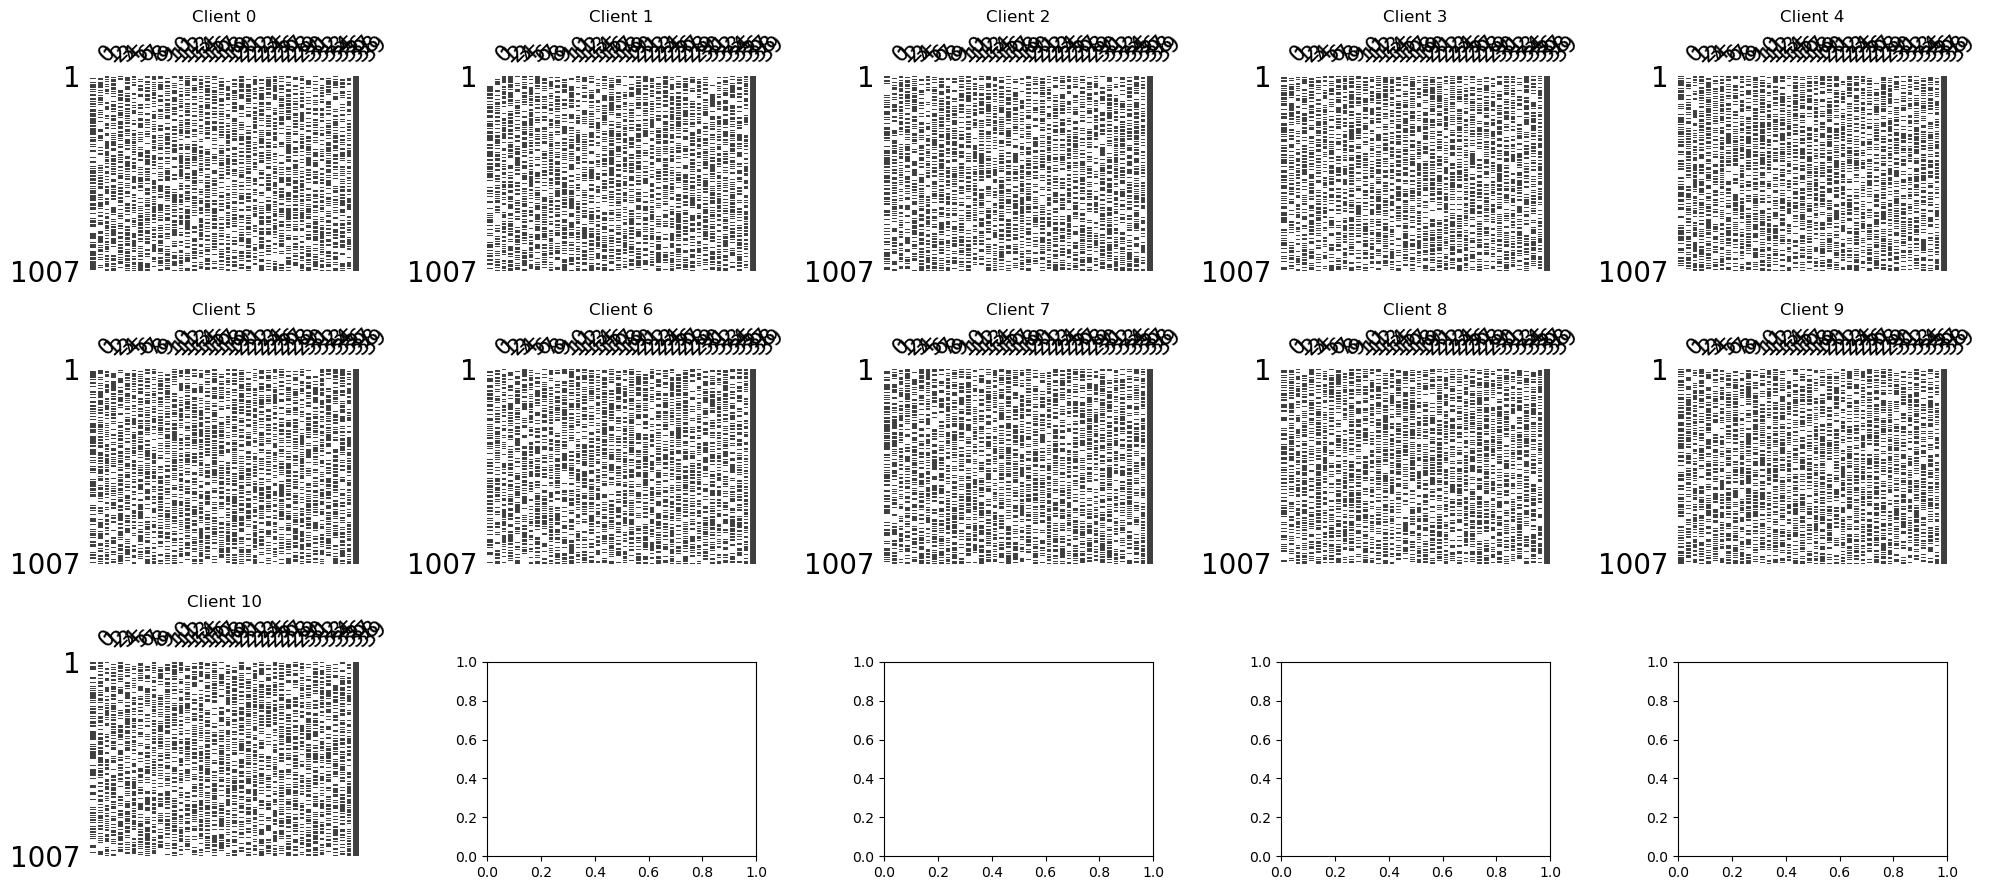

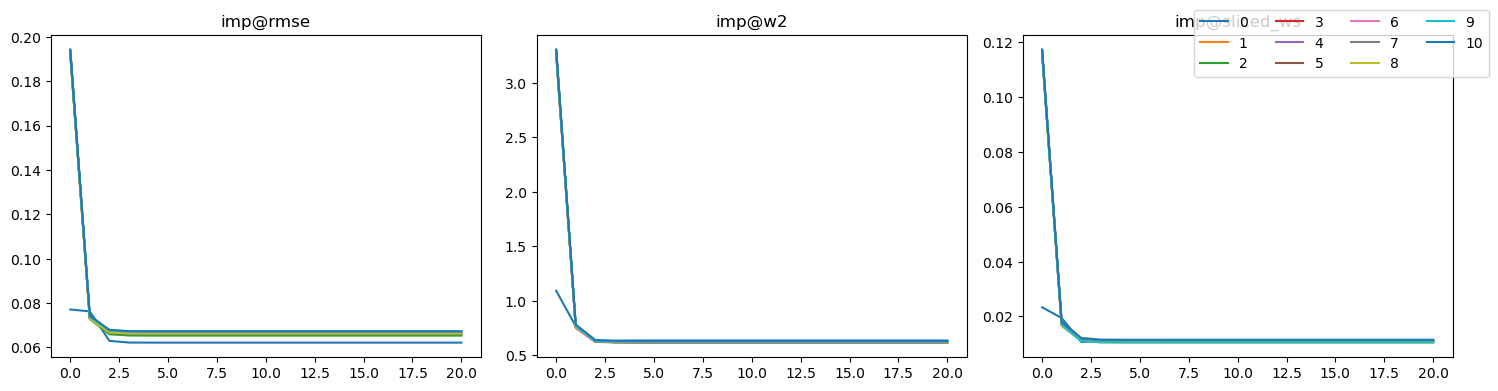

{'imp@rmse': 0.0660972440324338, 'imp@ws': 0.6247642796126843, 'imp@sliced_ws': 0.010921442720041577}


In [50]:
name = 'mnar_lr_diabetic_balanced_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic_balanced'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [51]:
pred_ret = NN_evaluation(
    rets['mnar_lr_diabetic_balanced_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance
)

2023-08-13 16:03:13.710 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.4996, test_f1: 0.6663 test_auroc: 0.5795 train_loss: 0.6925 val_accu: 0.5000 val_f1: 0.3333 test recall 1.0000 precision 0.4996 b-accu 0.5000
2023-08-13 16:03:19.205 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.5711, test_f1: 0.6030 test_auroc: 0.6041 train_loss: 0.6751 val_accu: 0.5747 val_f1: 0.5676 test recall 0.6520 precision 0.5608 b-accu 0.5711
2023-08-13 16:03:24.706 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.5776, test_f1: 0.6012 test_auroc: 0.6065 train_loss: 0.6673 val_accu: 0.5783 val_f1: 0.5743 test recall 0.6374 precision 0.5689 b-accu 0.5776
2023-08-13 16:03:30.102 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.5548, test_f1: 0.3701 tes

0.5848903330625508 0.6169095132509768 0.6663055254604551


## MNAR RL Balanced

(101766, 50)
(69569, 43)
(12304, 40)
(11073, 40) (1231, 40)
(11073, 40)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(1231, 40)


2023-08-13 16:04:13.642 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:04:13.643 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 16:05:19.234 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:05:19.234 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 16:06:31.842 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:06:31.842 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 16:06:39.177 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 147.09446360000584


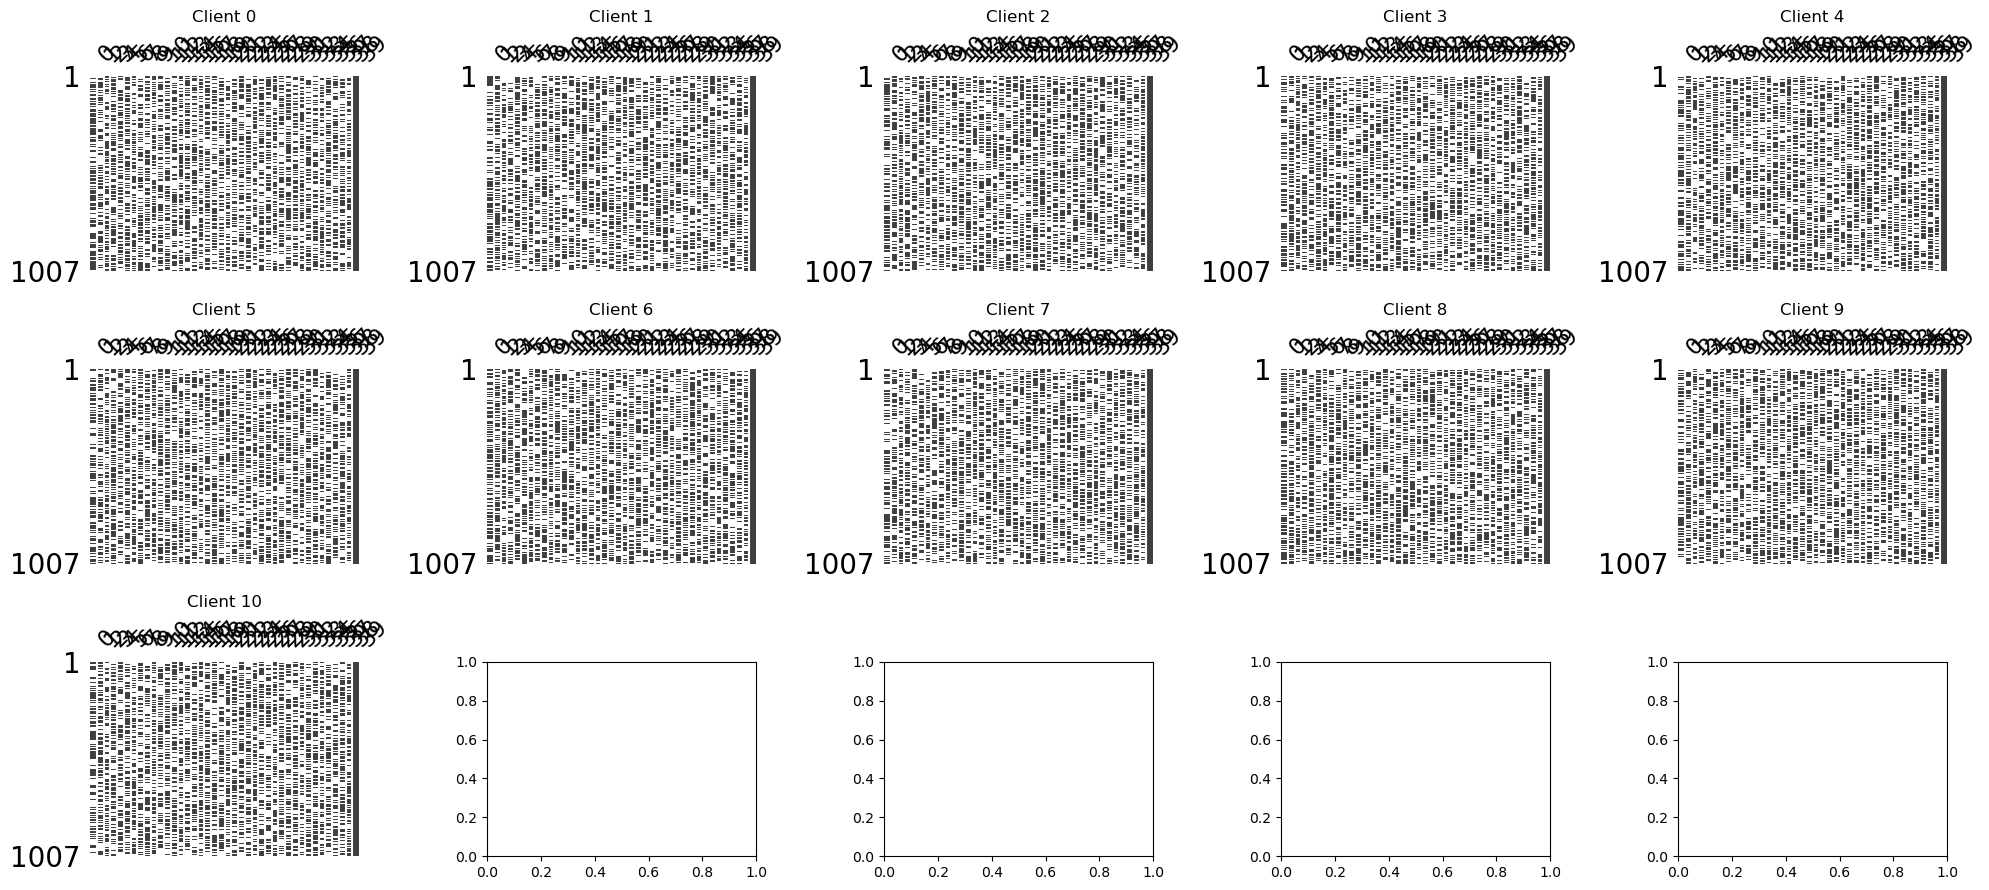

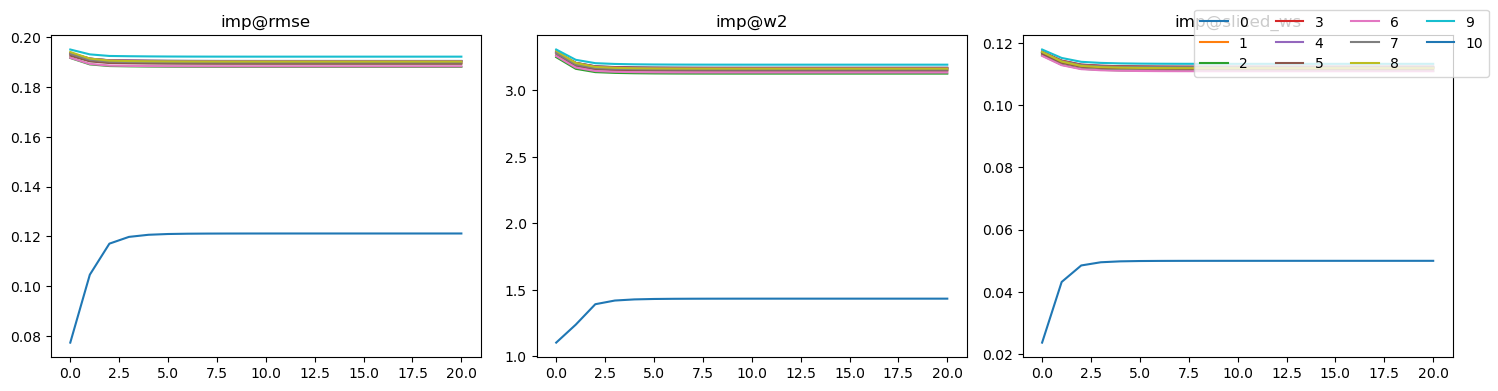

{'imp@rmse': 0.1834628636199087, 'imp@ws': 3.0015080453480363, 'imp@sliced_ws': 0.10623595106028708}


In [52]:
name = 'mnar_rl_diabetic_balanced_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic_balanced'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [53]:
pred_ret = NN_evaluation(
    rets['mnar_rl_diabetic_balanced_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl
)

2023-08-13 16:06:41.427 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.4996, test_f1: 0.6663 test_auroc: 0.5661 train_loss: 0.6934 val_accu: 0.5000 val_f1: 0.3333 test recall 1.0000 precision 0.4996 b-accu 0.5000
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-def

0.5637692932575142 0.5938034526449161 0.6673924877517692


(101766, 50)
(69569, 43)
(12304, 40)
(11073, 40) (1231, 40)
(11073, 40)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(1231, 40)


2023-08-13 16:07:20.885 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:07:20.885 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-13 16:08:31.678 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:08:31.679 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-13 16:09:49.601 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-13 16:09:49.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-13 16:09:57.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 158.37089079999714


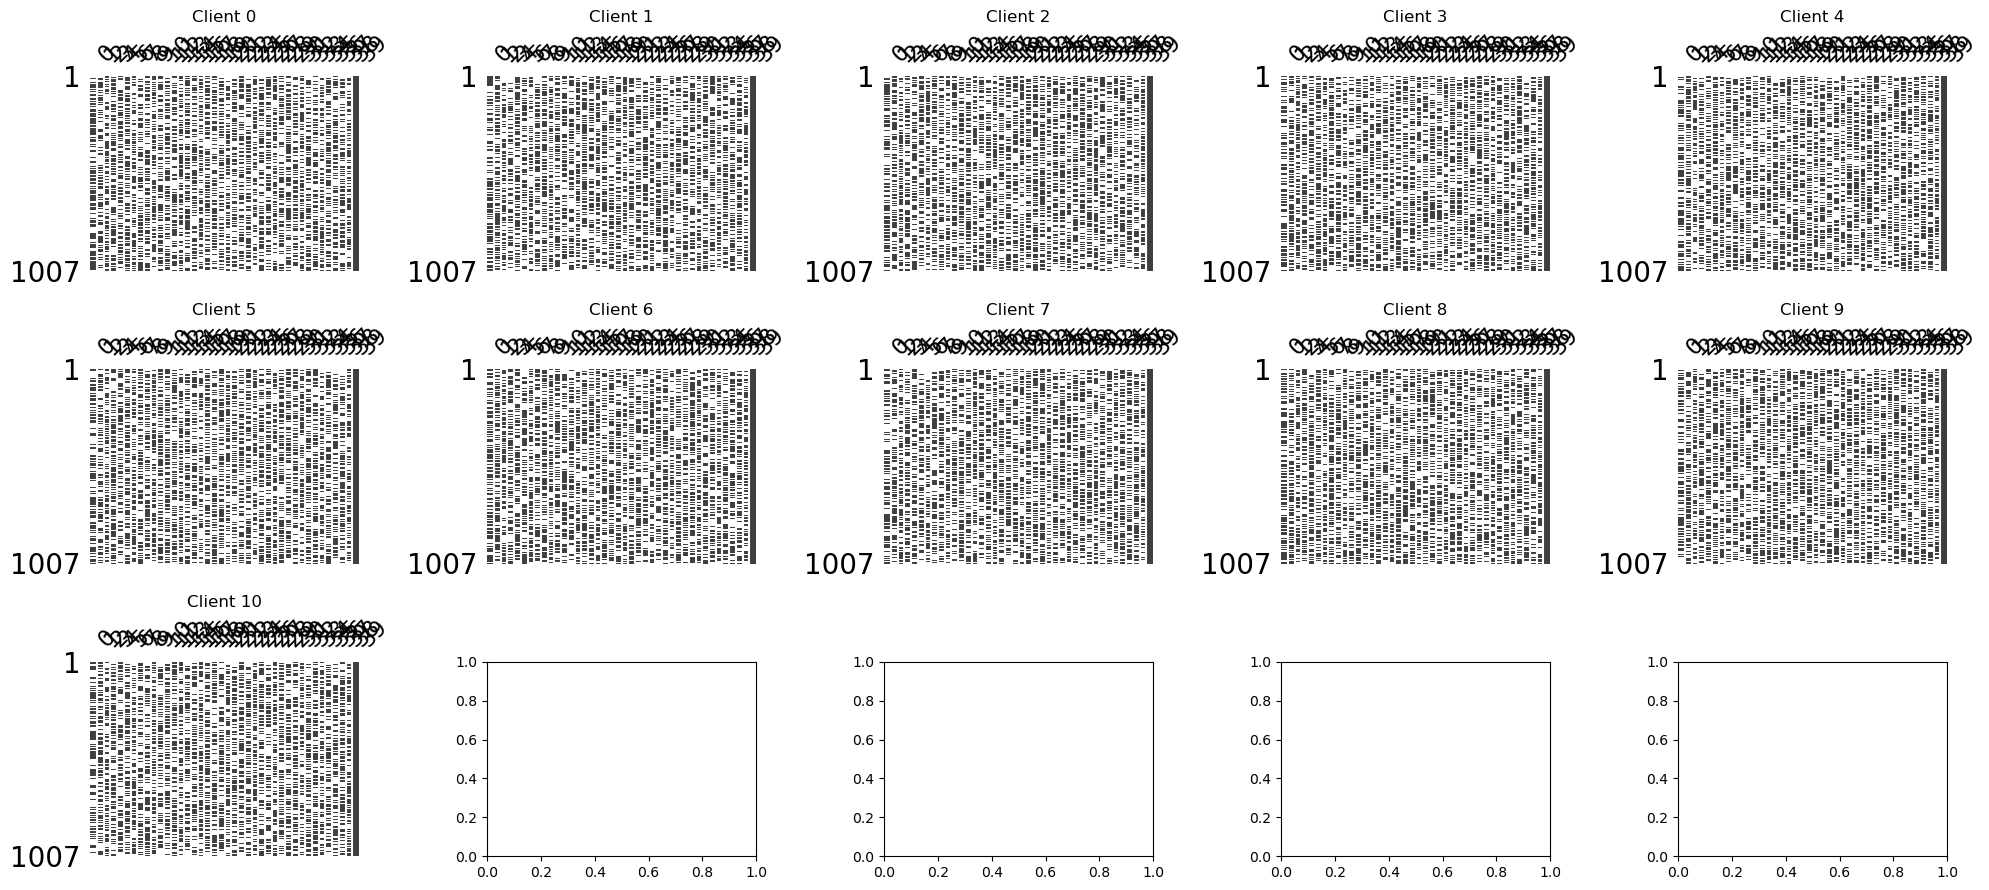

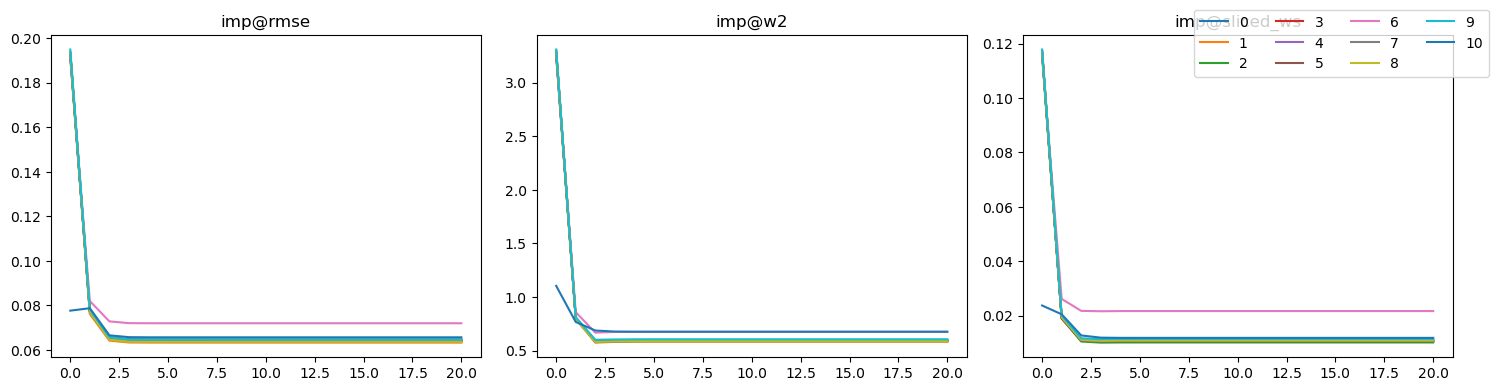

{'imp@rmse': 0.06481581530446393, 'imp@ws': 0.6070274632977812, 'imp@sliced_ws': 0.0118153631317388}


In [54]:
name = 'mnar_rl_diabetic_balanced_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic_balanced'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [55]:
pred_ret = NN_evaluation(
    rets['mnar_rl_diabetic_balanced_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl
)

2023-08-13 16:10:00.125 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.4996, test_f1: 0.6663 test_auroc: 0.5897 train_loss: 0.6927 val_accu: 0.5000 val_f1: 0.3333 test recall 1.0000 precision 0.4996 b-accu 0.5000
2023-08-13 16:10:05.944 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 50, test_accu: 0.5686, test_f1: 0.6070 test_auroc: 0.6033 train_loss: 0.6722 val_accu: 0.5792 val_f1: 0.5761 test recall 0.6667 precision 0.5571 b-accu 0.5687
2023-08-13 16:10:11.662 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 100, test_accu: 0.5768, test_f1: 0.6138 test_auroc: 0.6077 train_loss: 0.6622 val_accu: 0.5918 val_f1: 0.5875 test recall 0.6732 precision 0.5640 b-accu 0.5768
2023-08-13 16:10:17.377 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 150, test_accu: 0.5800, test_f1: 0.5279 tes

0.5913891145410236 0.6145813536057438 0.6670281995661604


## MNAR LR Raw

(101766, 50)
(99492, 43)
X_cat: (99492, 27)
(20000, 36)
(18000, 36) (2000, 36)
(18000, 36)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 36)


2023-08-15 15:27:51.995 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:27:51.996 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-15 15:29:19.364 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:29:19.365 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-15 15:30:51.437 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:30:51.437 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-15 15:31:00.775 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 191.75341539998772


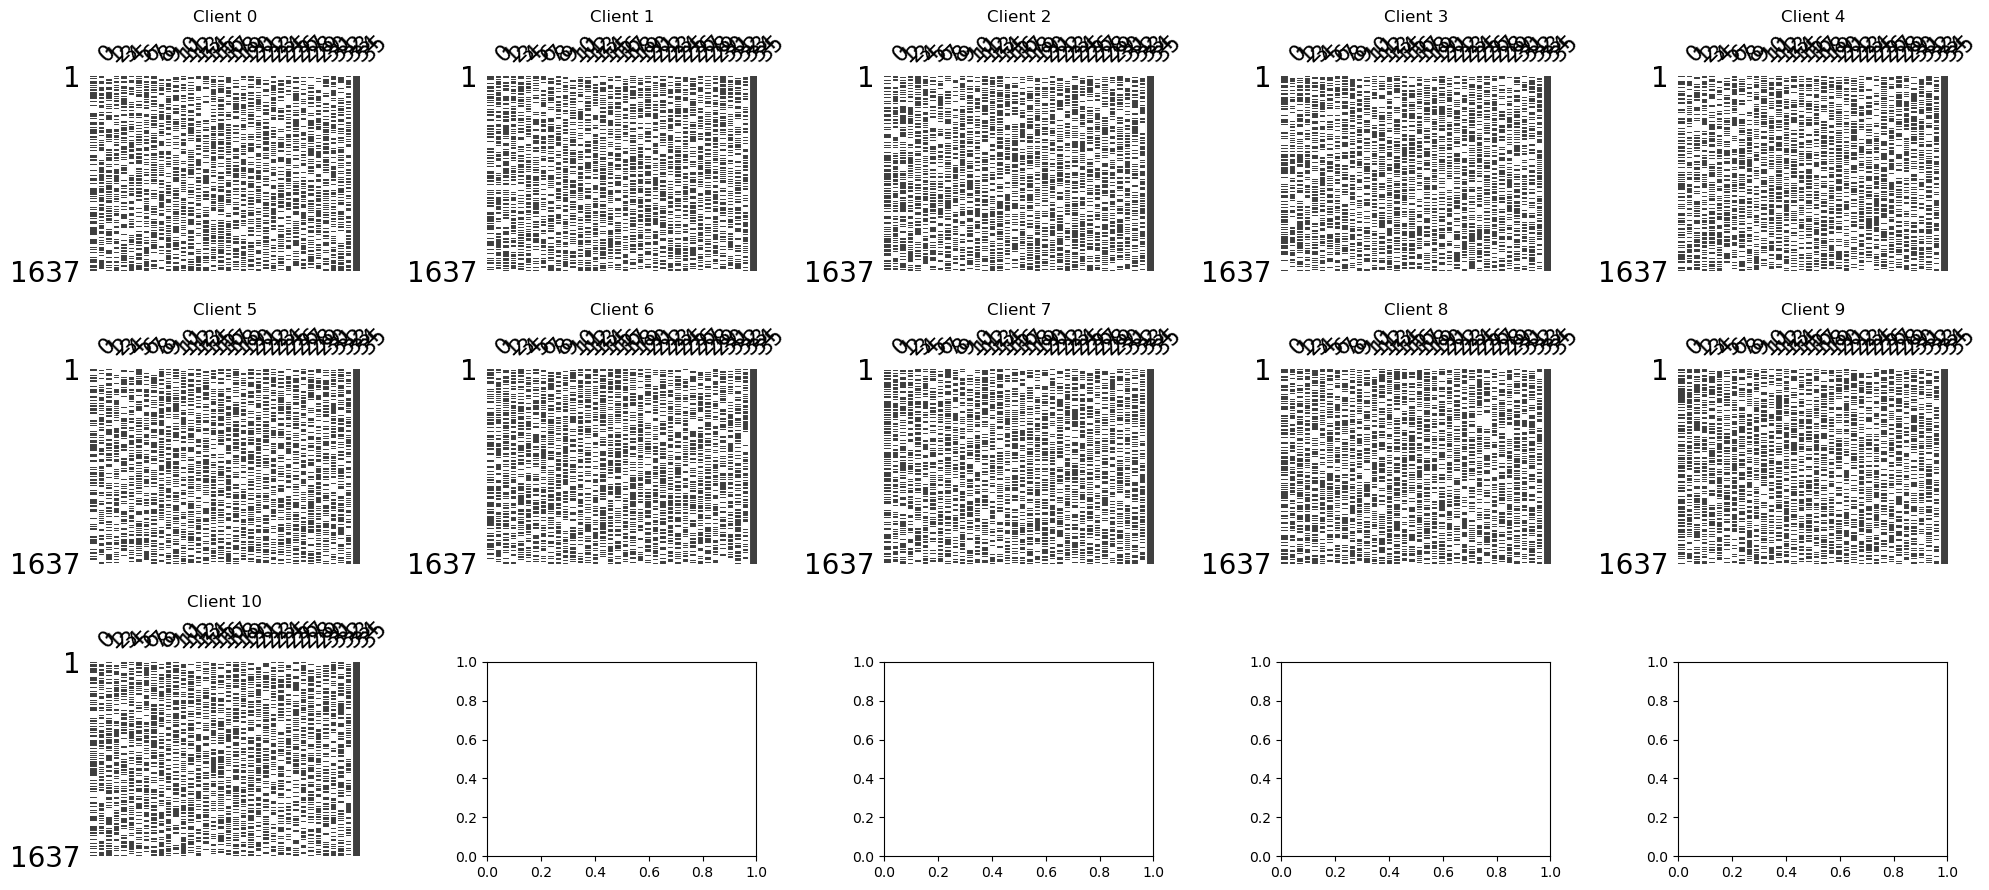

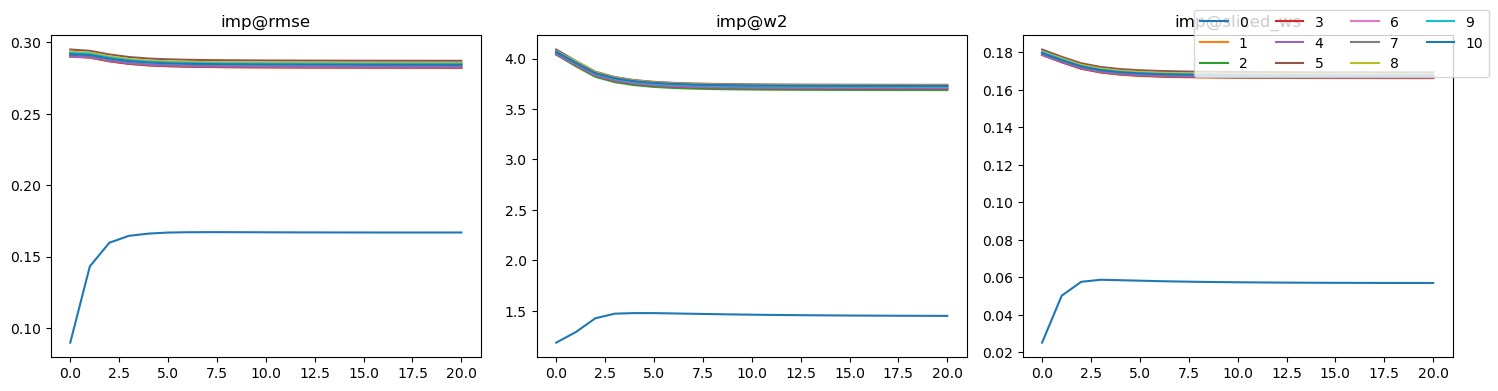

{'imp@rmse': 0.27342276583758485, 'imp@ws': 3.511075269963826, 'imp@sliced_ws': 0.15745070285530816}


In [50]:
name = 'mnar_lr_diabetic_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [78]:
pred_ret = NN_evaluation(
    rets['mnar_lr_diabetic_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = 'rus'
)

2023-08-15 15:43:36.503 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.2265, test_f1: 0.2175 test_auroc: 0.5932 train_loss: 0.6932 val_accu: 0.5098 val_f1: 0.4855 test recall 0.9556 precision 0.1227 b-accu 0.5448


2023-08-15 15:43:36.605 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.3755, test_f1: 0.2266 test_auroc: 0.6080 train_loss: 0.6926 val_accu: 0.5147 val_f1: 0.4865 test recall 0.8133 precision 0.1317 b-accu 0.5667
2023-08-15 15:43:36.697 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 4, test_accu: 0.2685, test_f1: 0.2206 test_auroc: 0.6192 train_loss: 0.6920 val_accu: 0.5393 val_f1: 0.5293 test recall 0.9200 precision 0.1253 b-accu 0.5530
2023-08-15 15:43:36.771 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 6, test_accu: 0.4985, test_f1: 0.2314 test_auroc: 0.6164 train_loss: 0.6913 val_accu: 0.5098 val_f1: 0.4235 test recall 0.6711 precision 0.1398 b-accu 0.5739
2023-08-15 15:43:36.850 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 8, test_accu: 0.3835, test_f1: 0.2240 test_aur

0.6885 0.6200212832550861 0.24657534246575344


(101766, 50)
(99492, 43)
X_cat: (99492, 27)
(20000, 36)
(18000, 36) (2000, 36)
(18000, 36)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 36)


2023-08-15 15:31:15.821 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:31:15.822 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-15 15:32:56.531 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:32:56.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-15 15:34:50.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:34:50.113 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-15 15:35:01.807 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 228.99875180001254


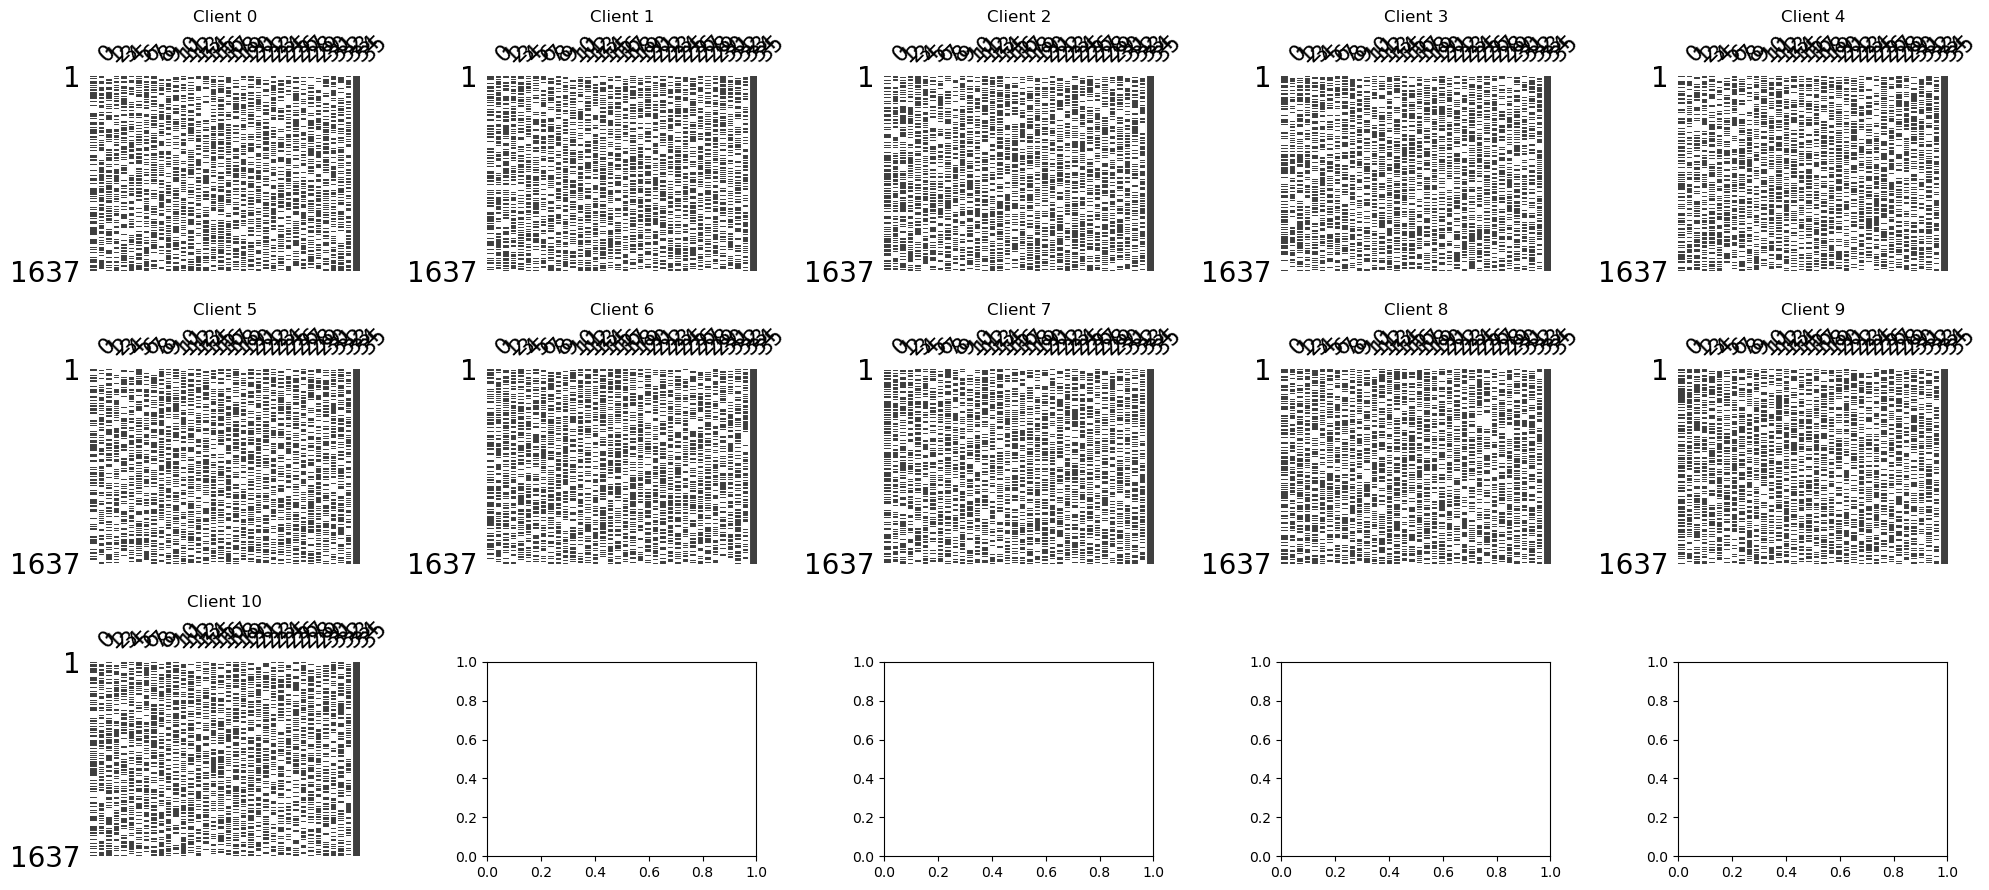

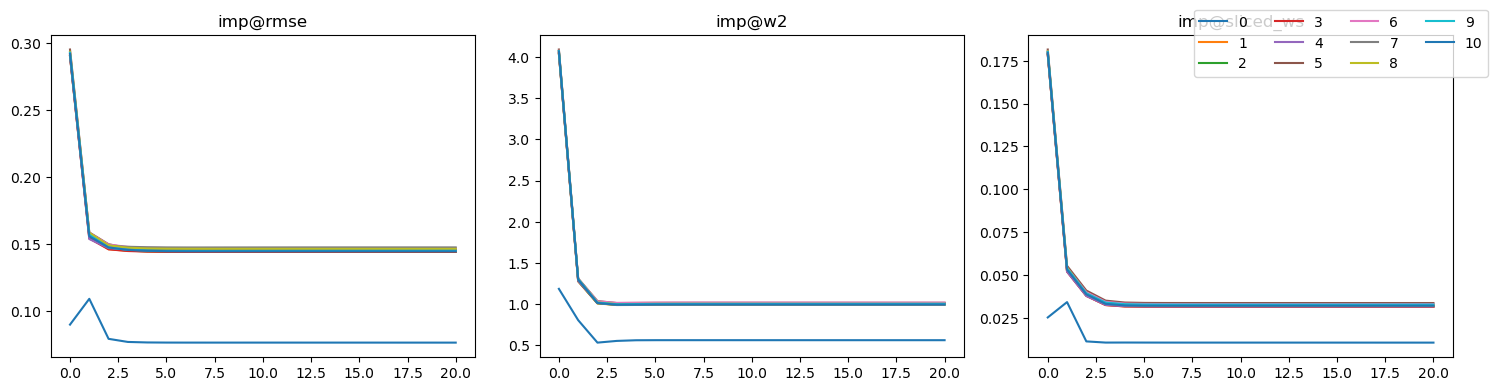

{'imp@rmse': 0.1390576853480248, 'imp@ws': 0.963563440726219, 'imp@sliced_ws': 0.030118899469288963}


In [51]:
name = 'mnar_lr_diabetic_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [79]:
pred_ret = NN_evaluation(
    rets['mnar_lr_diabetic_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = 'rus'
)

2023-08-15 15:43:57.819 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.4845, test_f1: 0.2335 test_auroc: 0.6040 train_loss: 0.6922 val_accu: 0.5627 val_f1: 0.5584 test recall 0.6978 precision 0.1402 b-accu 0.5776
2023-08-15 15:43:57.912 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.5075, test_f1: 0.2299 test_auroc: 0.6147 train_loss: 0.6897 val_accu: 0.5688 val_f1: 0.5653 test recall 0.6533 precision 0.1395 b-accu 0.5712
2023-08-15 15:43:58.018 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 4, test_accu: 0.5670, test_f1: 0.2377 test_auroc: 0.6152 train_loss: 0.6869 val_accu: 0.5651 val_f1: 0.5650 test recall 0.6000 precision 0.1482 b-accu 0.5814
2023-08-15 15:43:58.117 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 6, test_accu: 0.6450, test_f1: 0.2398 test_aur

0.6815 0.6223824726134585 0.260593220338983


## MNAR RL RAW

(101766, 50)
(99492, 43)
X_cat: (99492, 27)
(20000, 36)
(18000, 36) (2000, 36)
(18000, 36)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 36)


2023-08-15 15:44:30.783 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:44:30.783 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-15 15:46:10.504 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:46:10.504 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-15 15:48:16.137 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:48:16.138 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-15 15:48:29.026 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 241.44171289997757


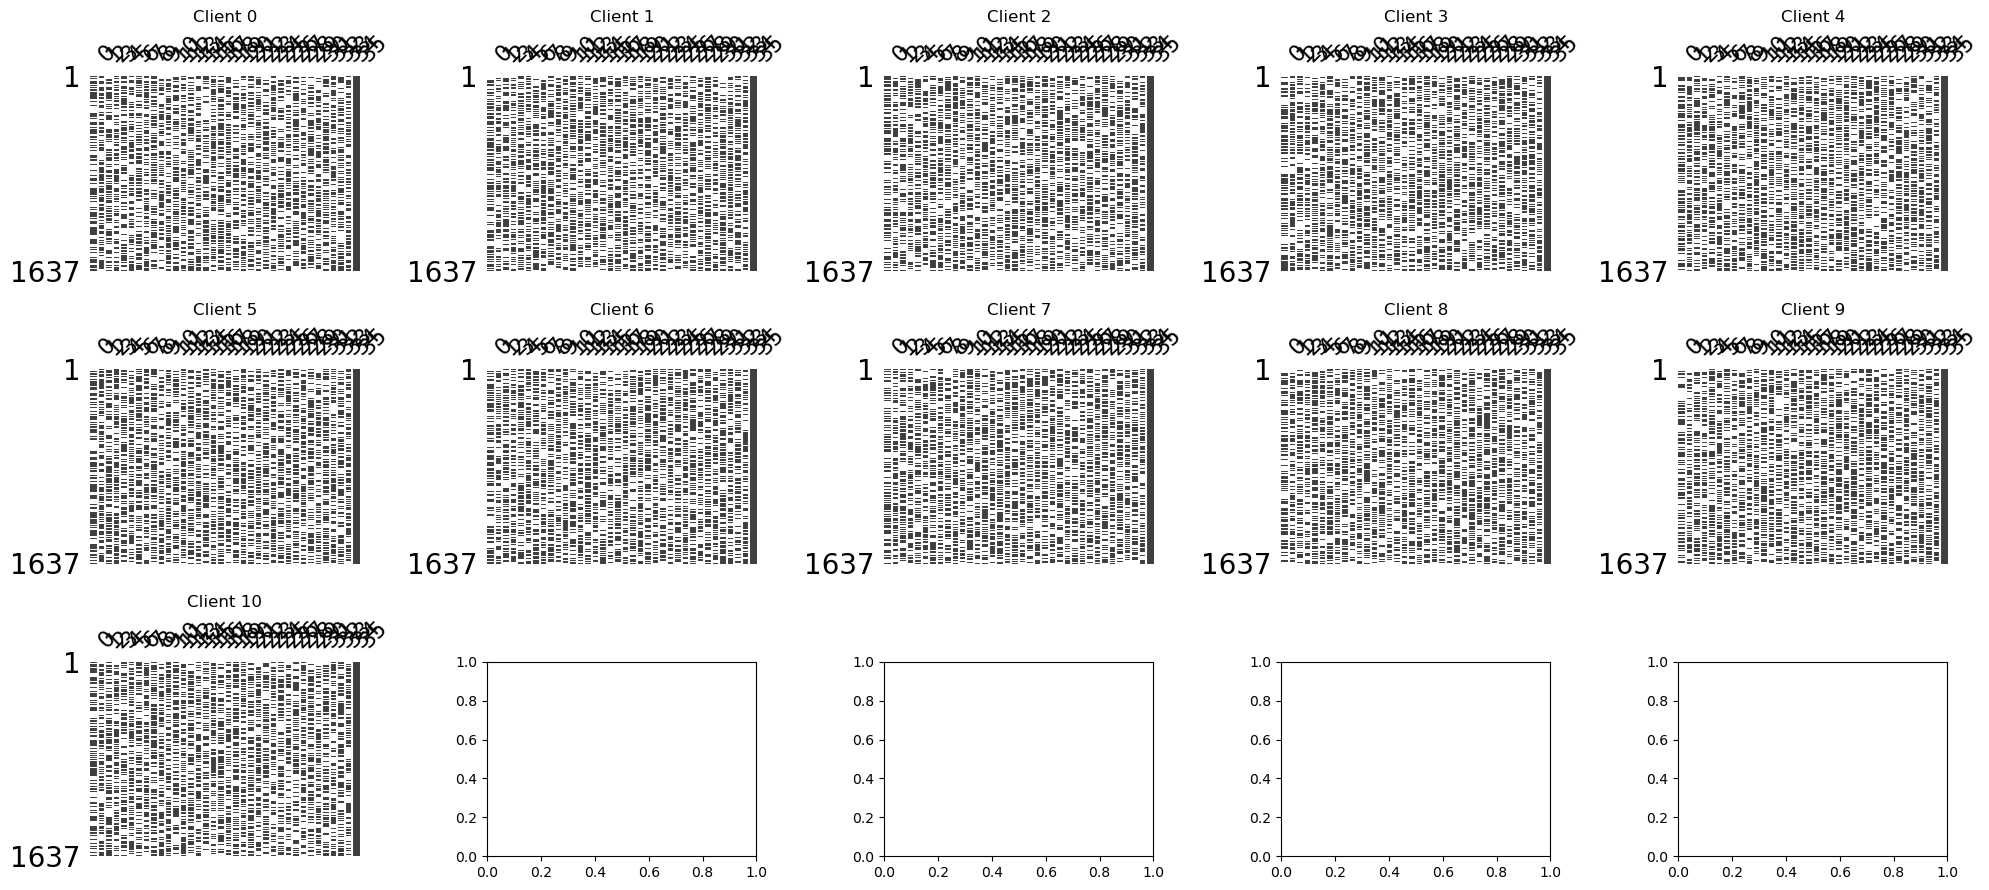

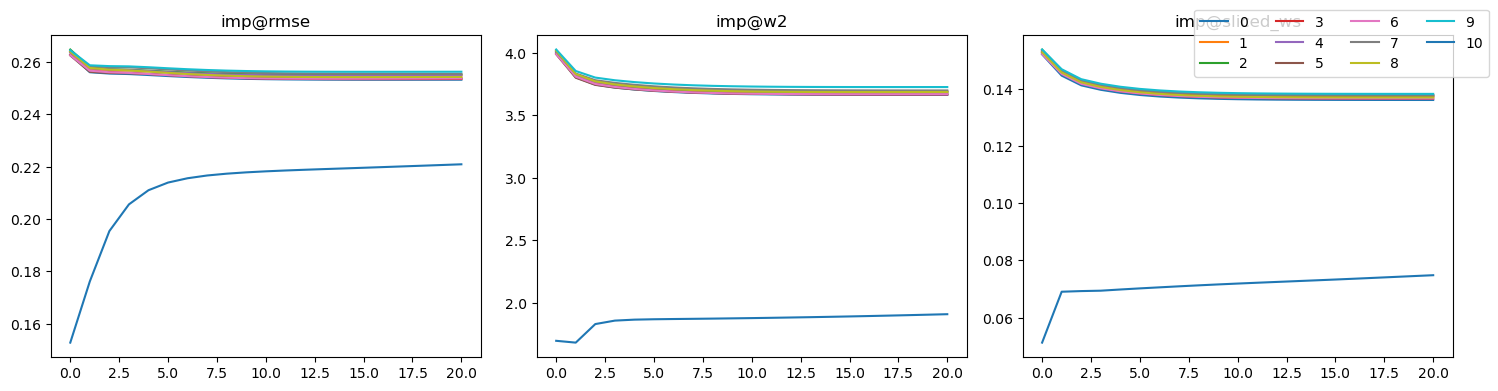

{'imp@rmse': 0.25140655448522464, 'imp@ws': 3.5236075605412593, 'imp@sliced_ws': 0.1314985732263445}


In [80]:
name = 'mnar_rl_diabetic_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [96]:
pred_ret = NN_evaluation(
    rets['mnar_rl_diabetic_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = 'rus'
)

2023-08-15 15:59:47.486 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.5145, test_f1: 0.2226 test_auroc: 0.5708 train_loss: 0.6924 val_accu: 0.5799 val_f1: 0.5779 test recall 0.6178 precision 0.1357 b-accu 0.5596


2023-08-15 15:59:47.528 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 1, test_accu: 0.6330, test_f1: 0.2354 test_auroc: 0.5798 train_loss: 0.6859 val_accu: 0.6007 val_f1: 0.5990 test recall 0.5022 precision 0.1537 b-accu 0.5759
2023-08-15 15:59:47.591 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.6205, test_f1: 0.2356 test_auroc: 0.5852 train_loss: 0.6811 val_accu: 0.5971 val_f1: 0.5967 test recall 0.5200 precision 0.1523 b-accu 0.5766
2023-08-15 15:59:47.643 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 3, test_accu: 0.6155, test_f1: 0.2394 test_auroc: 0.5889 train_loss: 0.6795 val_accu: 0.5946 val_f1: 0.5946 test recall 0.5378 precision 0.1539 b-accu 0.5816
2023-08-15 15:59:47.689 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 4, test_accu: 0.6205, test_f1: 0.2372 test_aur

0.7255 0.5969877934272301 0.24897400820793433


(101766, 50)
(99492, 43)
X_cat: (99492, 27)
(20000, 36)
(18000, 36) (2000, 36)
(18000, 36)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 36)


2023-08-15 15:48:57.413 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:48:57.414 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-15 15:50:46.208 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:50:46.209 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-15 15:52:39.152 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-15 15:52:39.153 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-15 15:52:50.451 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 236.3528633999813


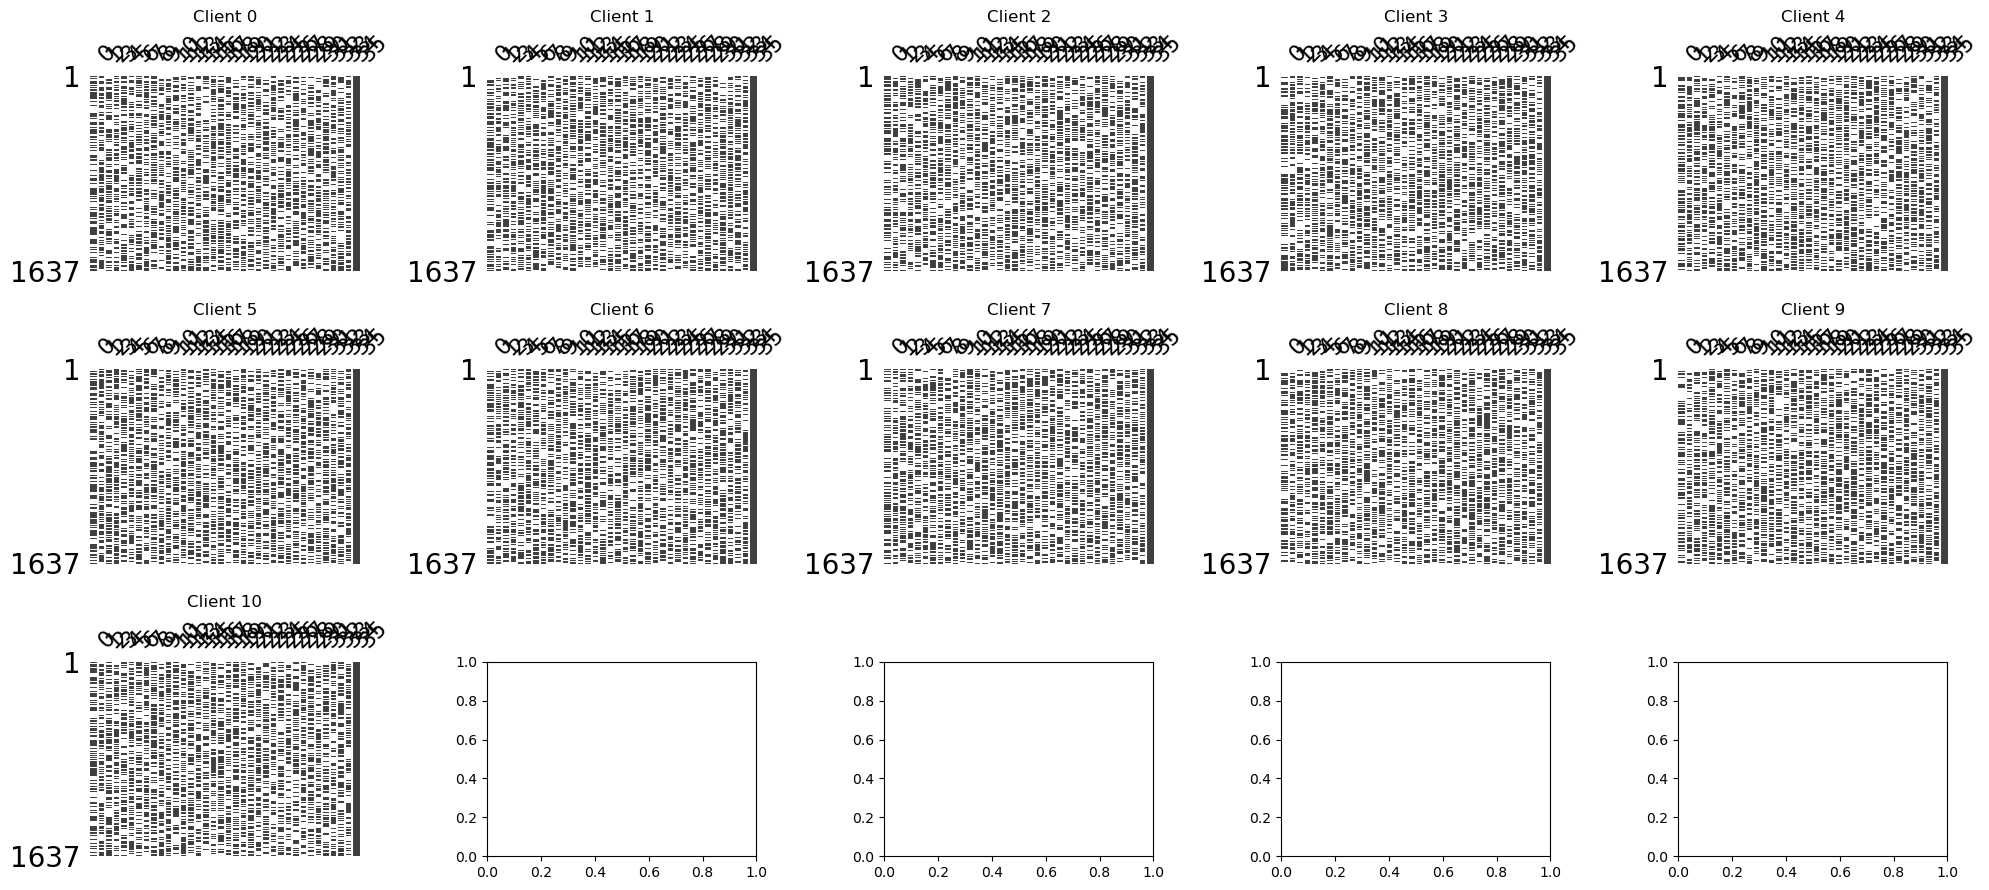

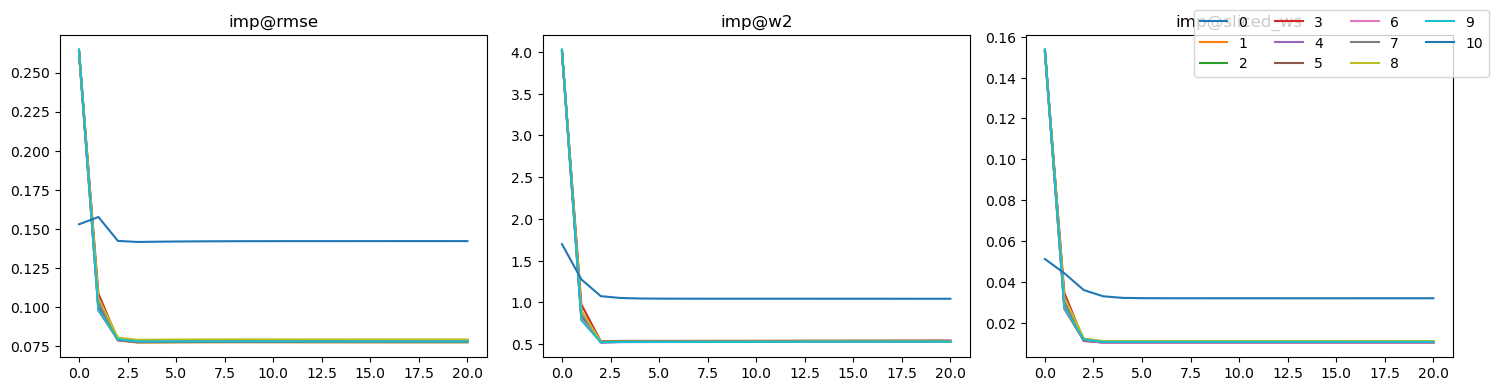

{'imp@rmse': 0.08367851250199473, 'imp@ws': 0.5799366546005541, 'imp@sliced_ws': 0.012645792566062247}


In [82]:
name = 'mnar_rl_diabetic_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [97]:
pred_ret = NN_evaluation(
    rets['mnar_rl_diabetic_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = 'rus'
)

2023-08-15 16:00:23.133 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.6015, test_f1: 0.2402 test_auroc: 0.5888 train_loss: 0.6920 val_accu: 0.6044 val_f1: 0.6042 test recall 0.5600 precision 0.1529 b-accu 0.5834
2023-08-15 16:00:23.181 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 1, test_accu: 0.6080, test_f1: 0.2403 test_auroc: 0.6001 train_loss: 0.6831 val_accu: 0.6167 val_f1: 0.6162 test recall 0.5511 precision 0.1537 b-accu 0.5832
2023-08-15 16:00:23.225 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.6100, test_f1: 0.2412 test_auroc: 0.6051 train_loss: 0.6753 val_accu: 0.6204 val_f1: 0.6198 test recall 0.5511 precision 0.1544 b-accu 0.5843
2023-08-15 16:00:23.277 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 3, test_accu: 0.6055, test_f1: 0.2406 test_aur

0.735 0.6126372456964007 0.2572614107883818


# Cardio

In [42]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:15:07.582 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:15:07.583 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:16:29.130 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:16:29.131 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:17:38.890 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:17:38.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:17:46.507 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 163.48836580000352


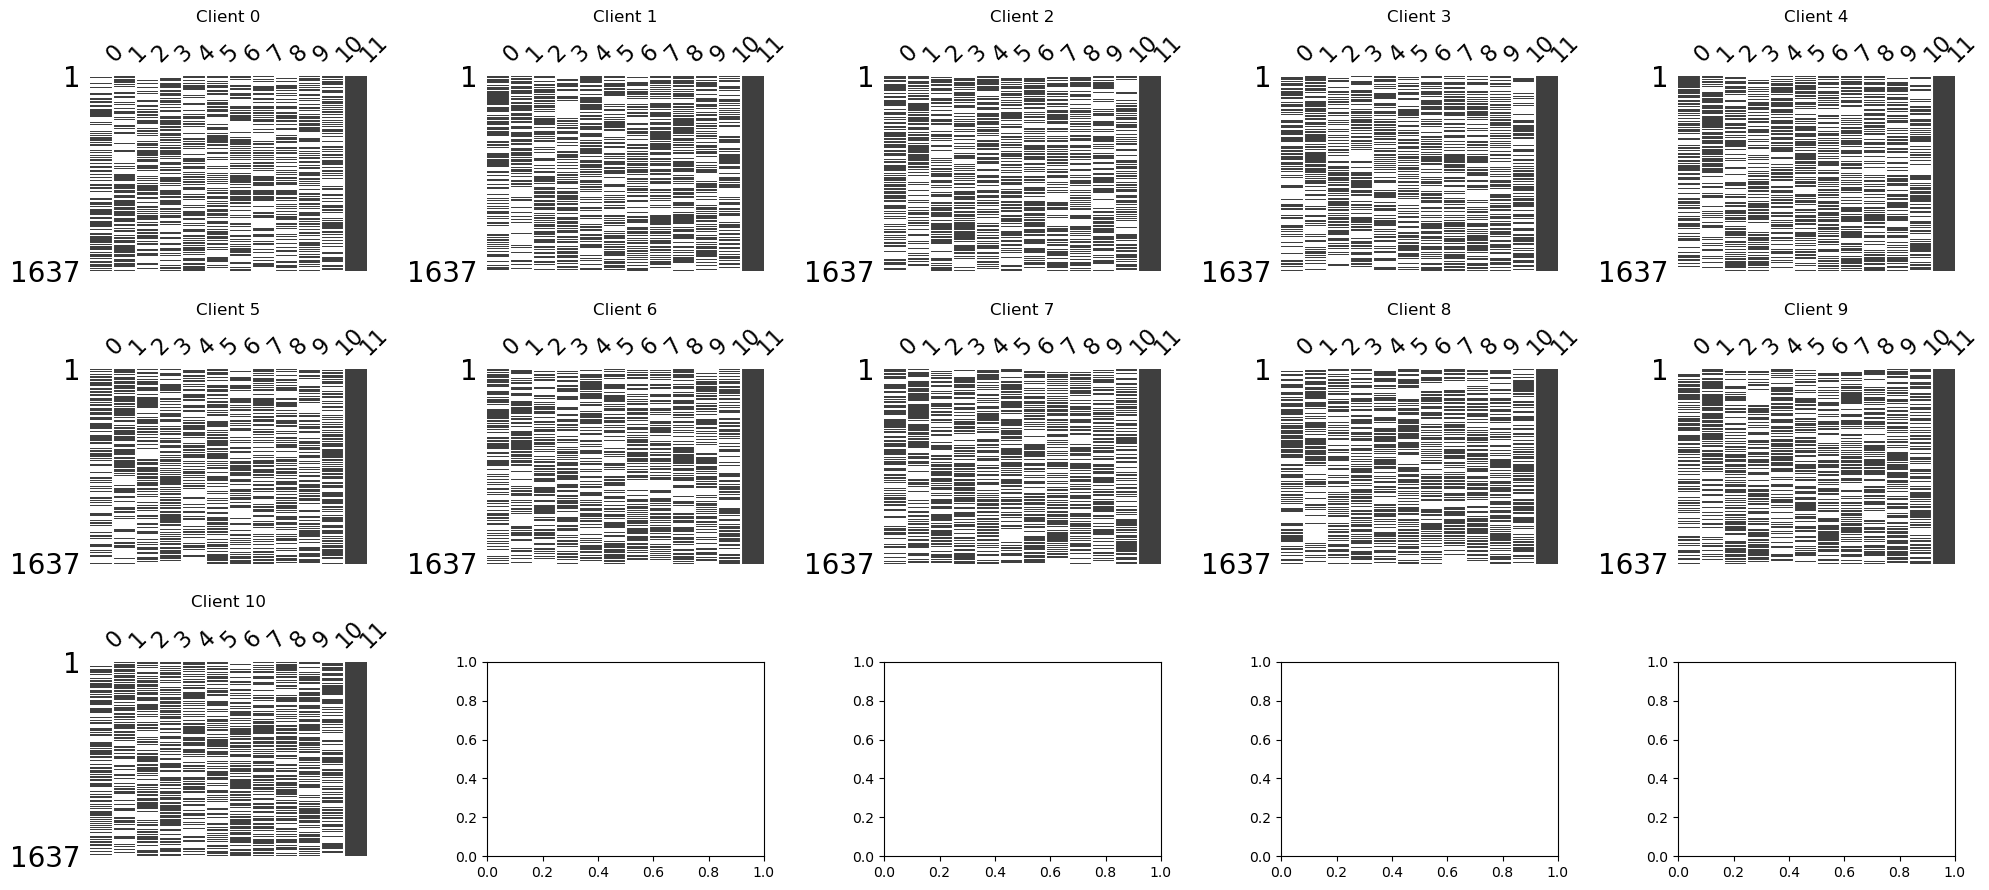

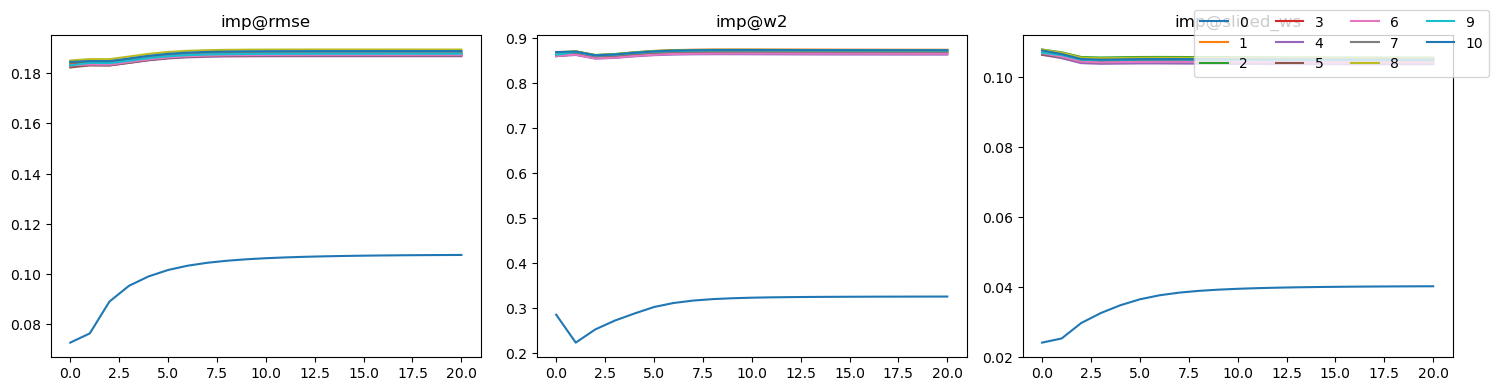

{'imp@rmse': 0.1805928921916503, 'imp@ws': 0.8211636117179579, 'imp@sliced_ws': 0.09885332860512797}


In [45]:
name = 'mnar_lr_cardio_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [46]:
pred_ret = NN_evaluation(
    rets['mnar_lr_cardio_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:17:49.559 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.5410, test_f1: 0.4339 test_auroc: 0.6688 train_loss: 0.6940 val_accu: 0.5017 val_f1: 0.3380
2023-08-03 19:17:57.442 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.4995, test_f1: 0.3331 test_auroc: 0.5020 train_loss: 0.6933 val_accu: 0.5000 val_f1: 0.3333
2023-08-03 19:18:05.596 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.5005, test_f1: 0.3336 test_auroc: 0.5020 train_loss: 0.6936 val_accu: 0.5000 val_f1: 0.3333
2023-08-03 19:18:13.301 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.4995, test_f1: 0.3331 test_auroc: 0.5020 train_loss: 0.6932 val_accu: 0.5000 val_f1: 0.3333
2023-08-03 19:18:20.776 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.5835 0.6825971825971826 0.5403162767494678


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:21:07.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:21:07.853 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:22:13.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:22:13.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:23:27.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:23:27.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:23:34.960 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 151.88568760000635


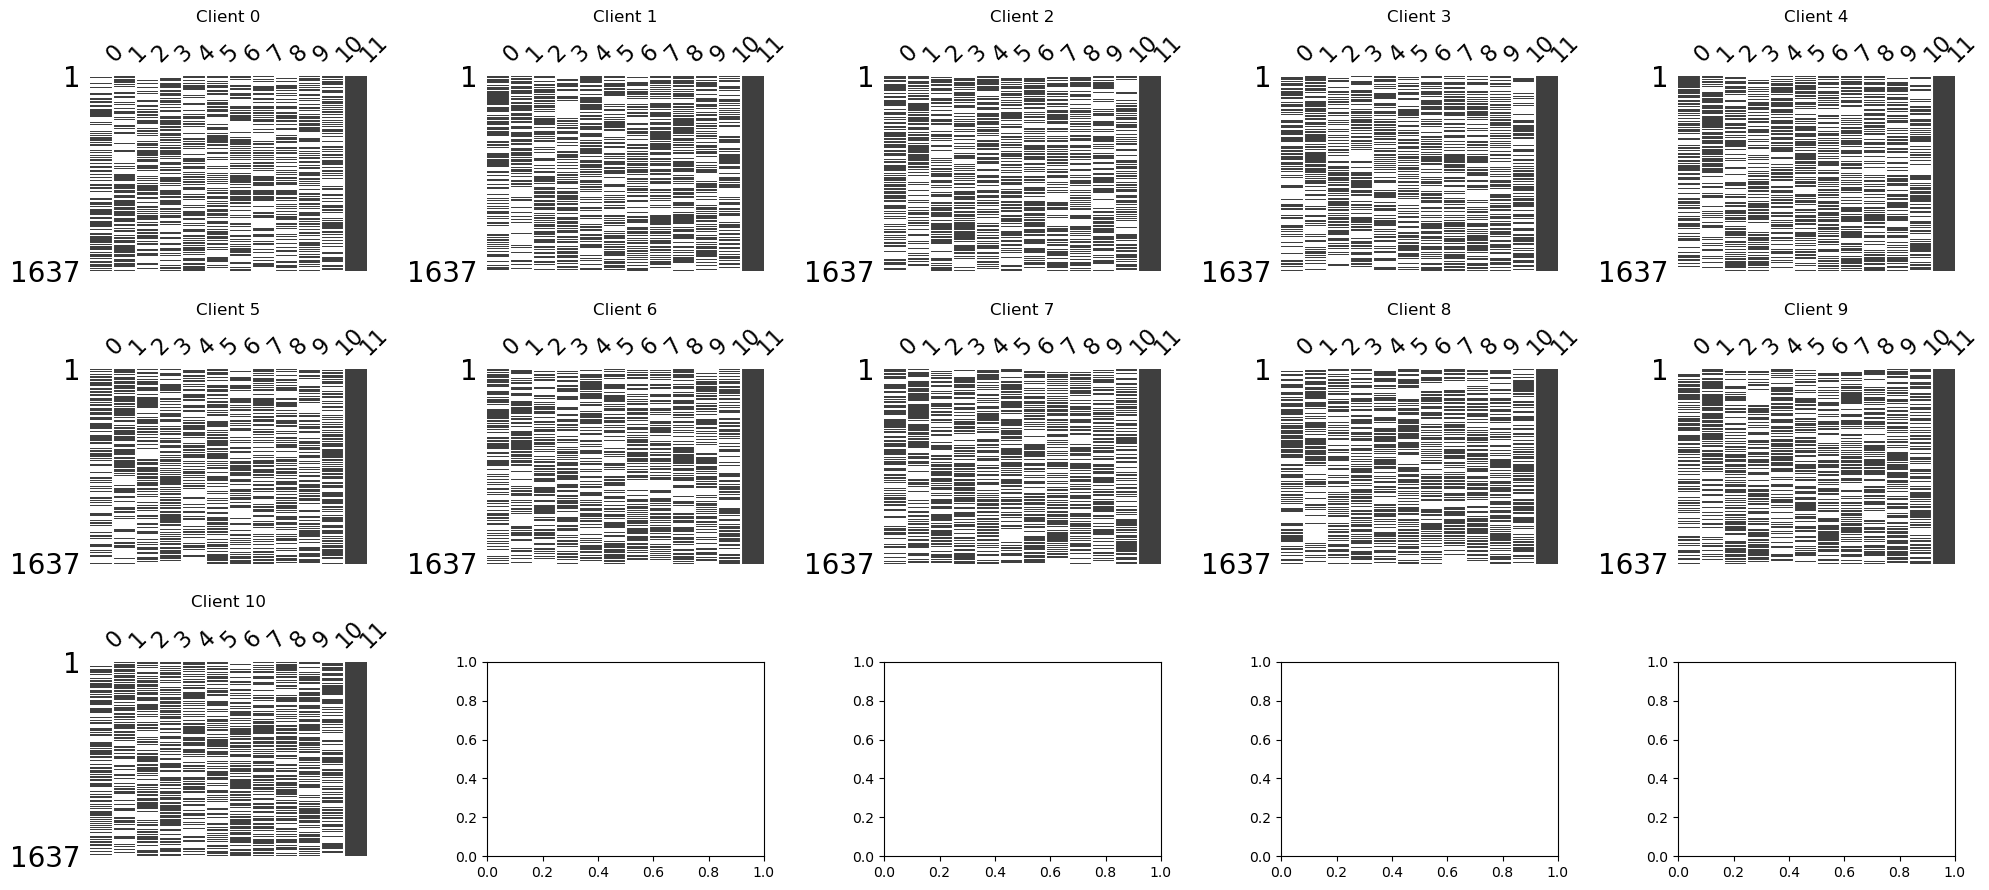

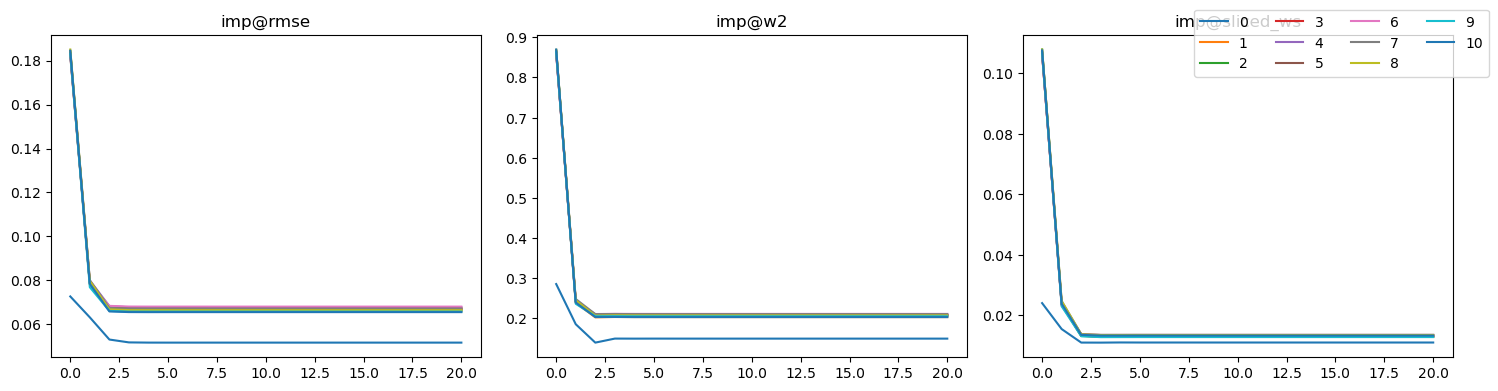

{'imp@rmse': 0.06543817506394098, 'imp@ws': 0.20229980583053633, 'imp@sliced_ws': 0.013060052115186857}


In [47]:
name = 'mnar_lr_cardio_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [48]:
pred_ret = NN_evaluation(
    rets['mnar_lr_cardio_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:23:38.051 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.6680, test_f1: 0.6674 test_auroc: 0.7506 train_loss: 0.6565 val_accu: 0.6912 val_f1: 0.6911
2023-08-03 19:23:45.786 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.7190, test_f1: 0.7170 test_auroc: 0.7877 train_loss: 0.5774 val_accu: 0.7273 val_f1: 0.7266
2023-08-03 19:23:53.256 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.7160, test_f1: 0.7139 test_auroc: 0.7878 train_loss: 0.5737 val_accu: 0.7195 val_f1: 0.7179
2023-08-03 19:24:00.885 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.7100, test_f1: 0.7069 test_auroc: 0.7873 train_loss: 0.5709 val_accu: 0.7201 val_f1: 0.7193
2023-08-03 19:24:08.911 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.7265 0.7922517922517921 0.7264999316249829


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:27:17.562 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:27:17.563 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:28:24.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:28:24.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:29:33.111 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:29:33.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:29:40.181 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 147.21332359994994


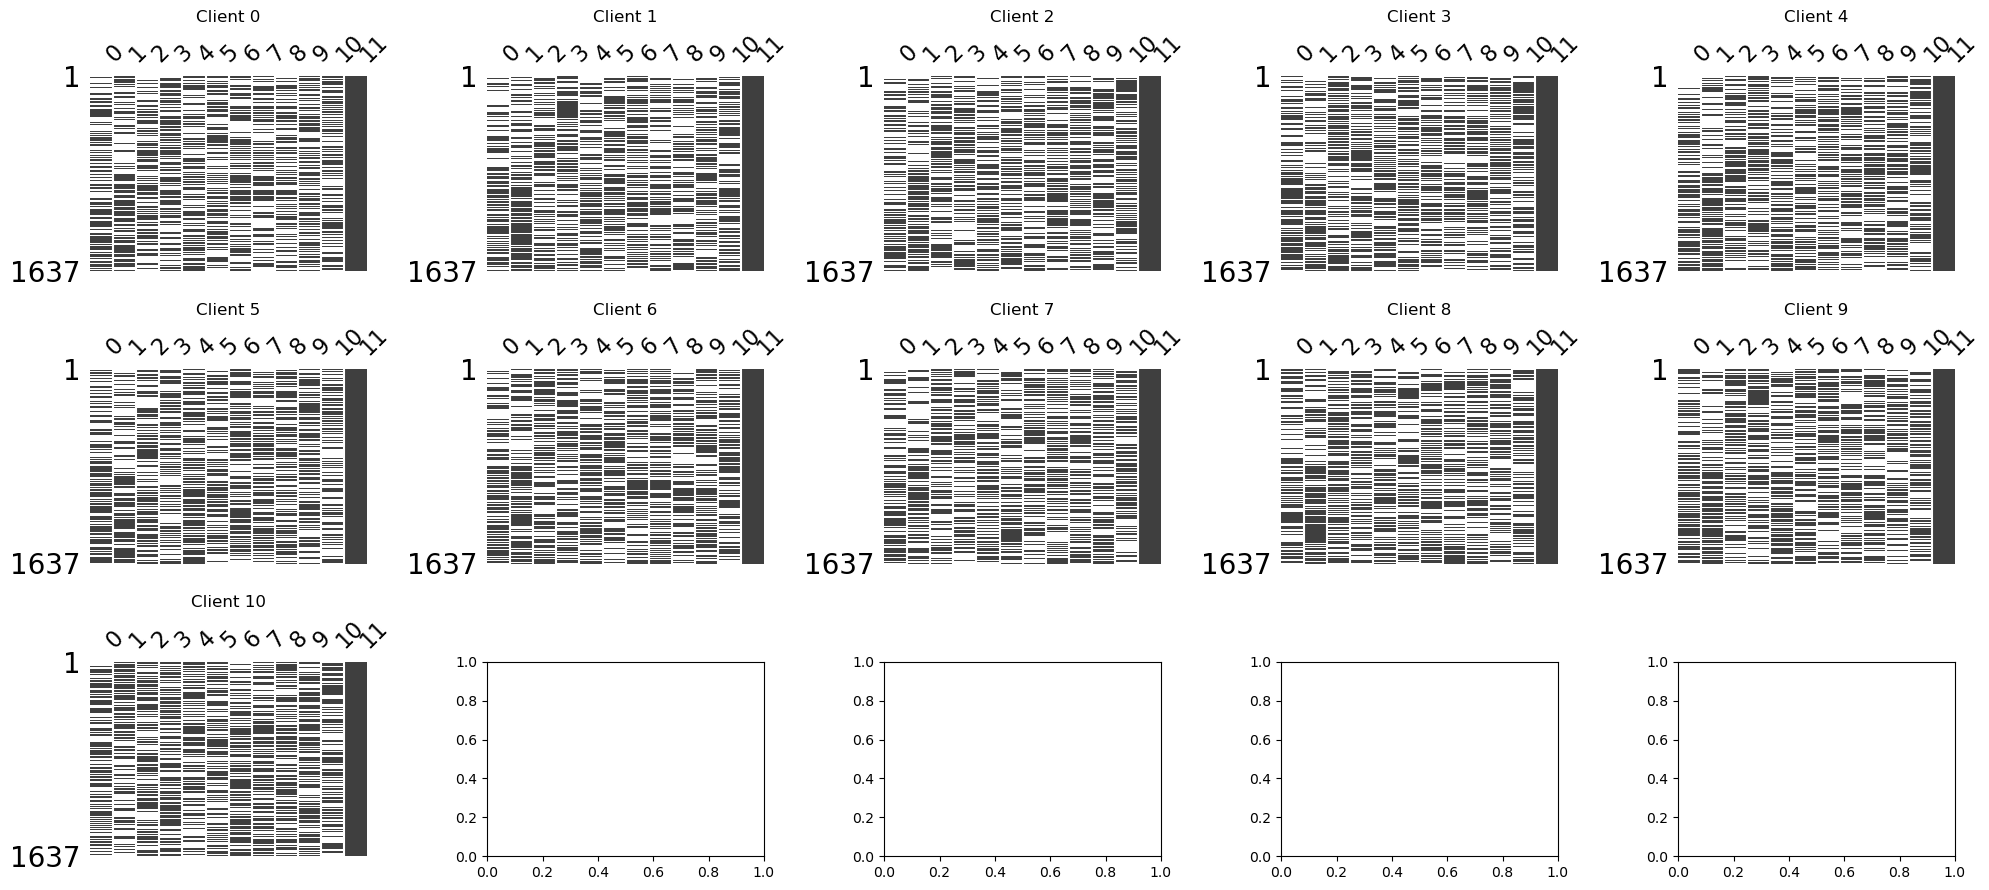

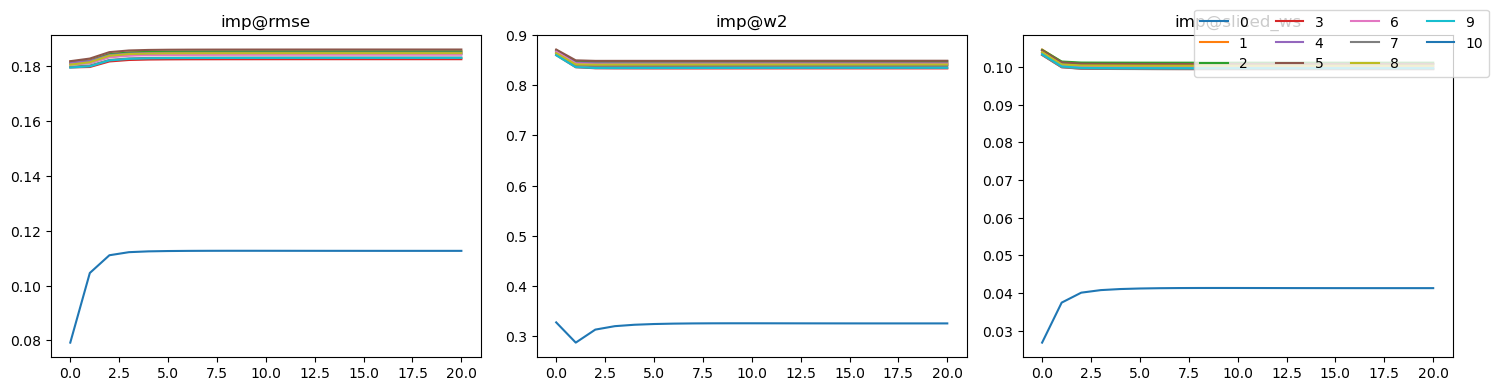

{'imp@rmse': 0.17795875628492033, 'imp@ws': 0.7944499369117158, 'imp@sliced_ws': 0.0949492538761867}


In [49]:
name = 'mnar_rl_cardio_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [50]:
pred_ret = NN_evaluation(
    rets['mnar_rl_cardio_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:29:42.958 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.5970, test_f1: 0.5701 test_auroc: 0.6067 train_loss: 0.6906 val_accu: 0.6247 val_f1: 0.6176
2023-08-03 19:29:50.591 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.6730, test_f1: 0.6728 test_auroc: 0.7311 train_loss: 0.6363 val_accu: 0.6610 val_f1: 0.6571
2023-08-03 19:29:57.859 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.6820, test_f1: 0.6820 test_auroc: 0.7392 train_loss: 0.6270 val_accu: 0.6655 val_f1: 0.6607
2023-08-03 19:30:05.200 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.6800, test_f1: 0.6799 test_auroc: 0.7245 train_loss: 0.6230 val_accu: 0.6727 val_f1: 0.6693
2023-08-03 19:30:12.549 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.688 0.745974245974246 0.6879472630874618


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:32:56.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:32:56.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:33:59.802 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:33:59.803 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:35:14.830 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:35:14.831 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:35:22.460 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 150.49200660001952


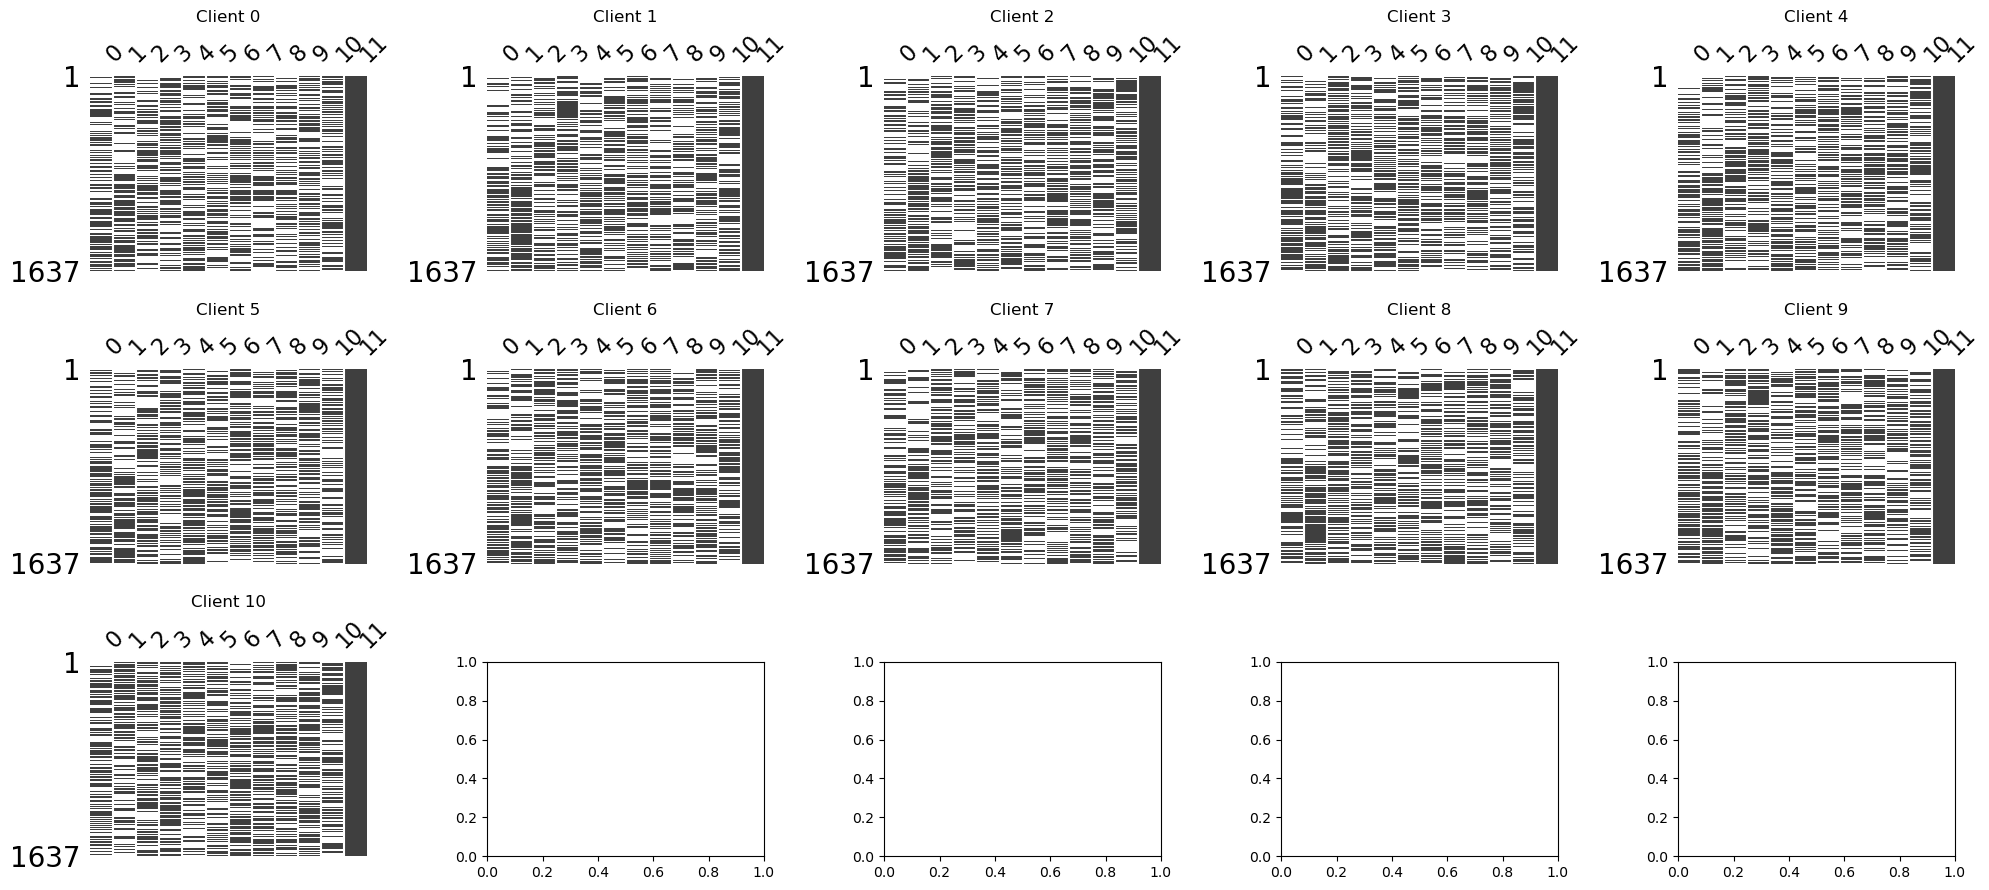

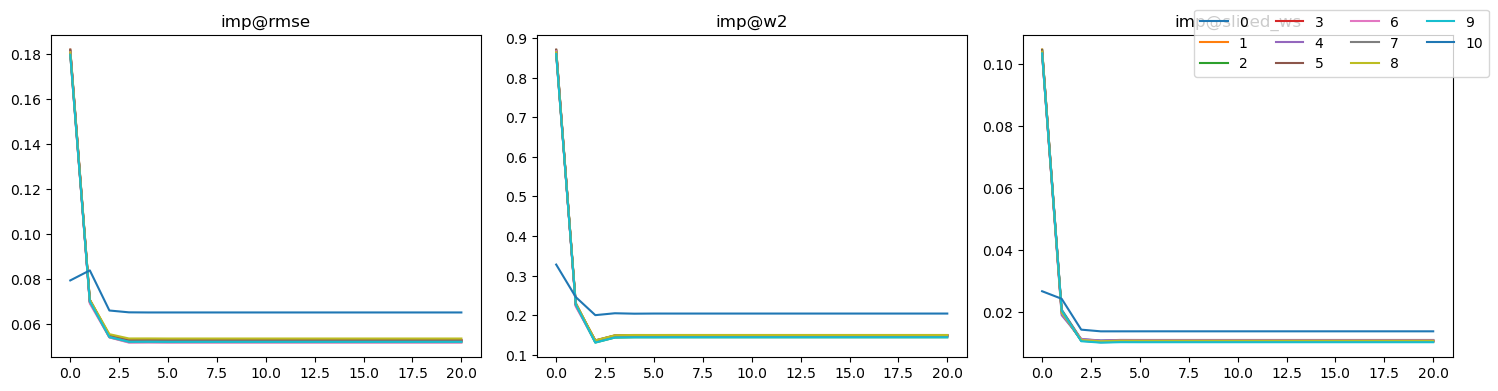

{'imp@rmse': 0.053483969634496406, 'imp@ws': 0.15272740569858834, 'imp@sliced_ws': 0.011088363895667294}


In [51]:
name = 'mnar_rl_cardio_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [52]:
pred_ret = NN_evaluation(
    rets['mnar_rl_cardio_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:35:25.497 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.6895, test_f1: 0.6881 test_auroc: 0.7636 train_loss: 0.6305 val_accu: 0.7043 val_f1: 0.7042
2023-08-03 19:35:32.399 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.7160, test_f1: 0.7147 test_auroc: 0.7826 train_loss: 0.5654 val_accu: 0.7226 val_f1: 0.7201
2023-08-03 19:35:40.070 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.7130, test_f1: 0.7106 test_auroc: 0.7831 train_loss: 0.5600 val_accu: 0.7201 val_f1: 0.7161
2023-08-03 19:35:48.517 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.7170, test_f1: 0.7144 test_auroc: 0.7876 train_loss: 0.5635 val_accu: 0.7192 val_f1: 0.7151


# MIMIC III MORTALITY

(20000, 51)
mortality
0    14556
1     5444
Name: count, dtype: int64
(18000, 51) (2000, 51)
(18000, 51)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 51)


2023-08-17 00:47:31.743 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-17 00:47:31.744 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1


KeyboardInterrupt: 

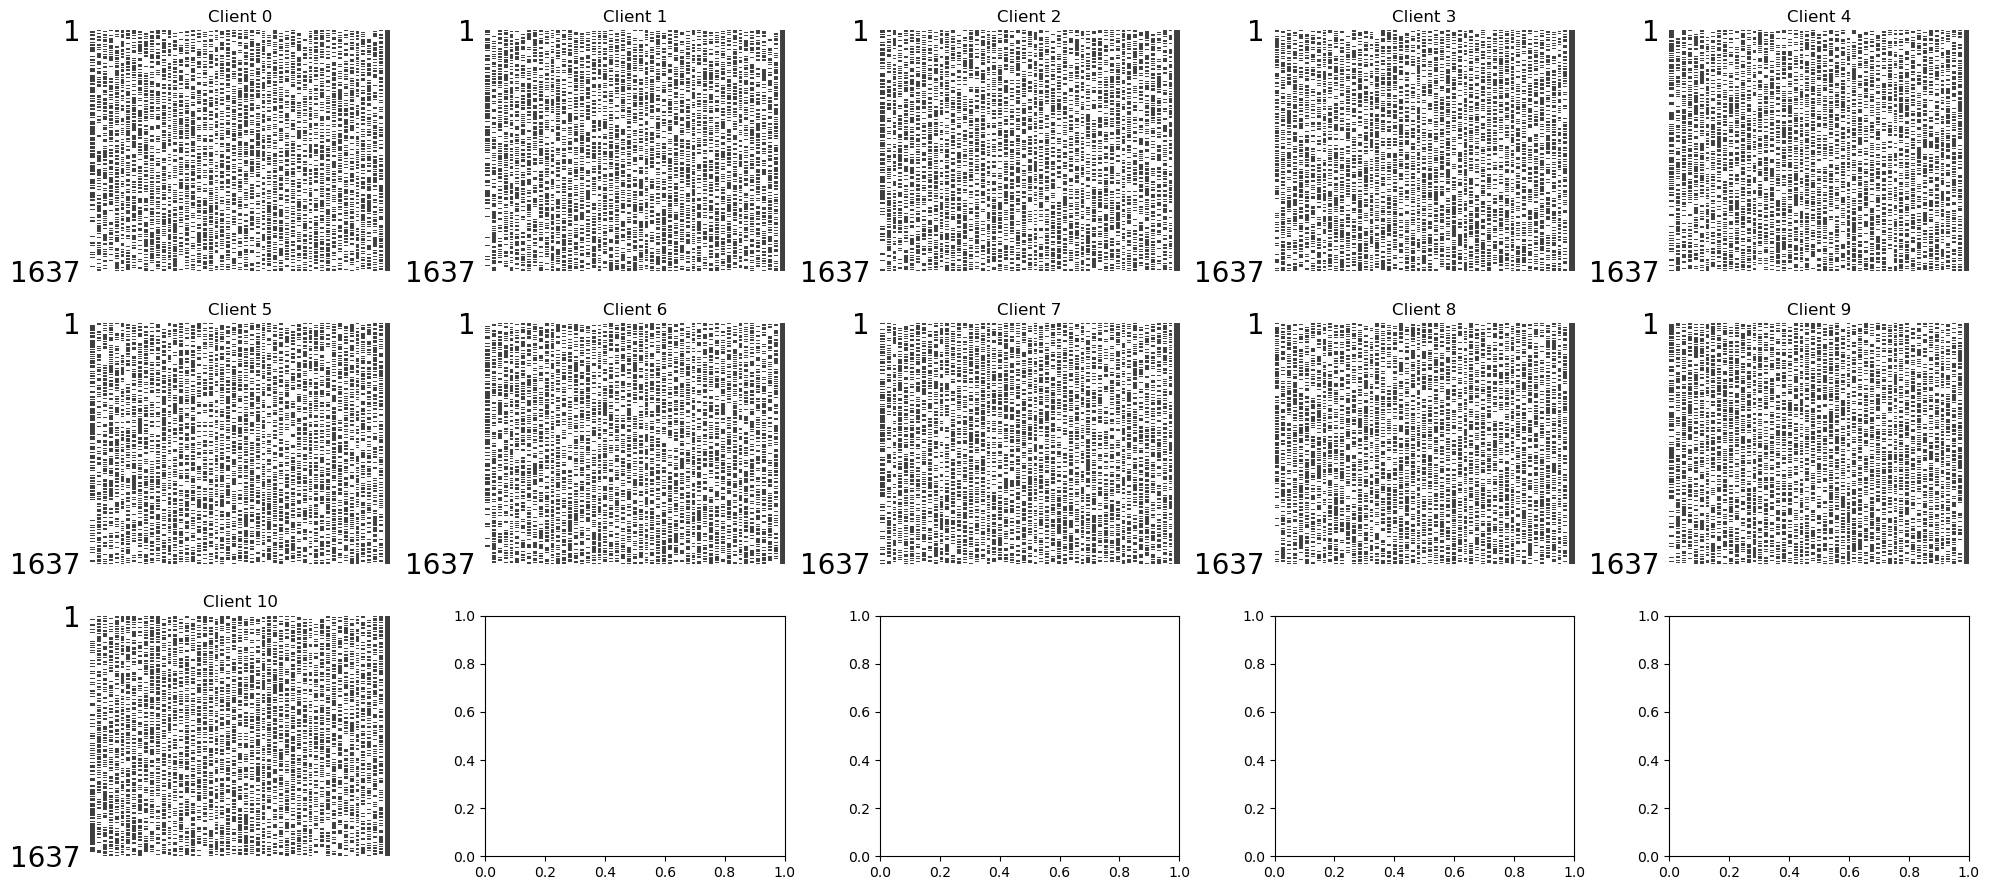

In [63]:
name = 'mnar_rl_mimicmo_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'mimiciii_mo2'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

(20000, 41)
ICD9_GROUP
5     7991
7     2449
1     2082
4     1308
2     1126
0     1022
3      891
8      847
11     719
9      702
6      451
10     412
Name: count, dtype: int64
(18000, 41) (2000, 41)
(18000, 41)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 41)


2023-08-17 00:47:48.844 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-17 00:47:48.844 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1


KeyboardInterrupt: 

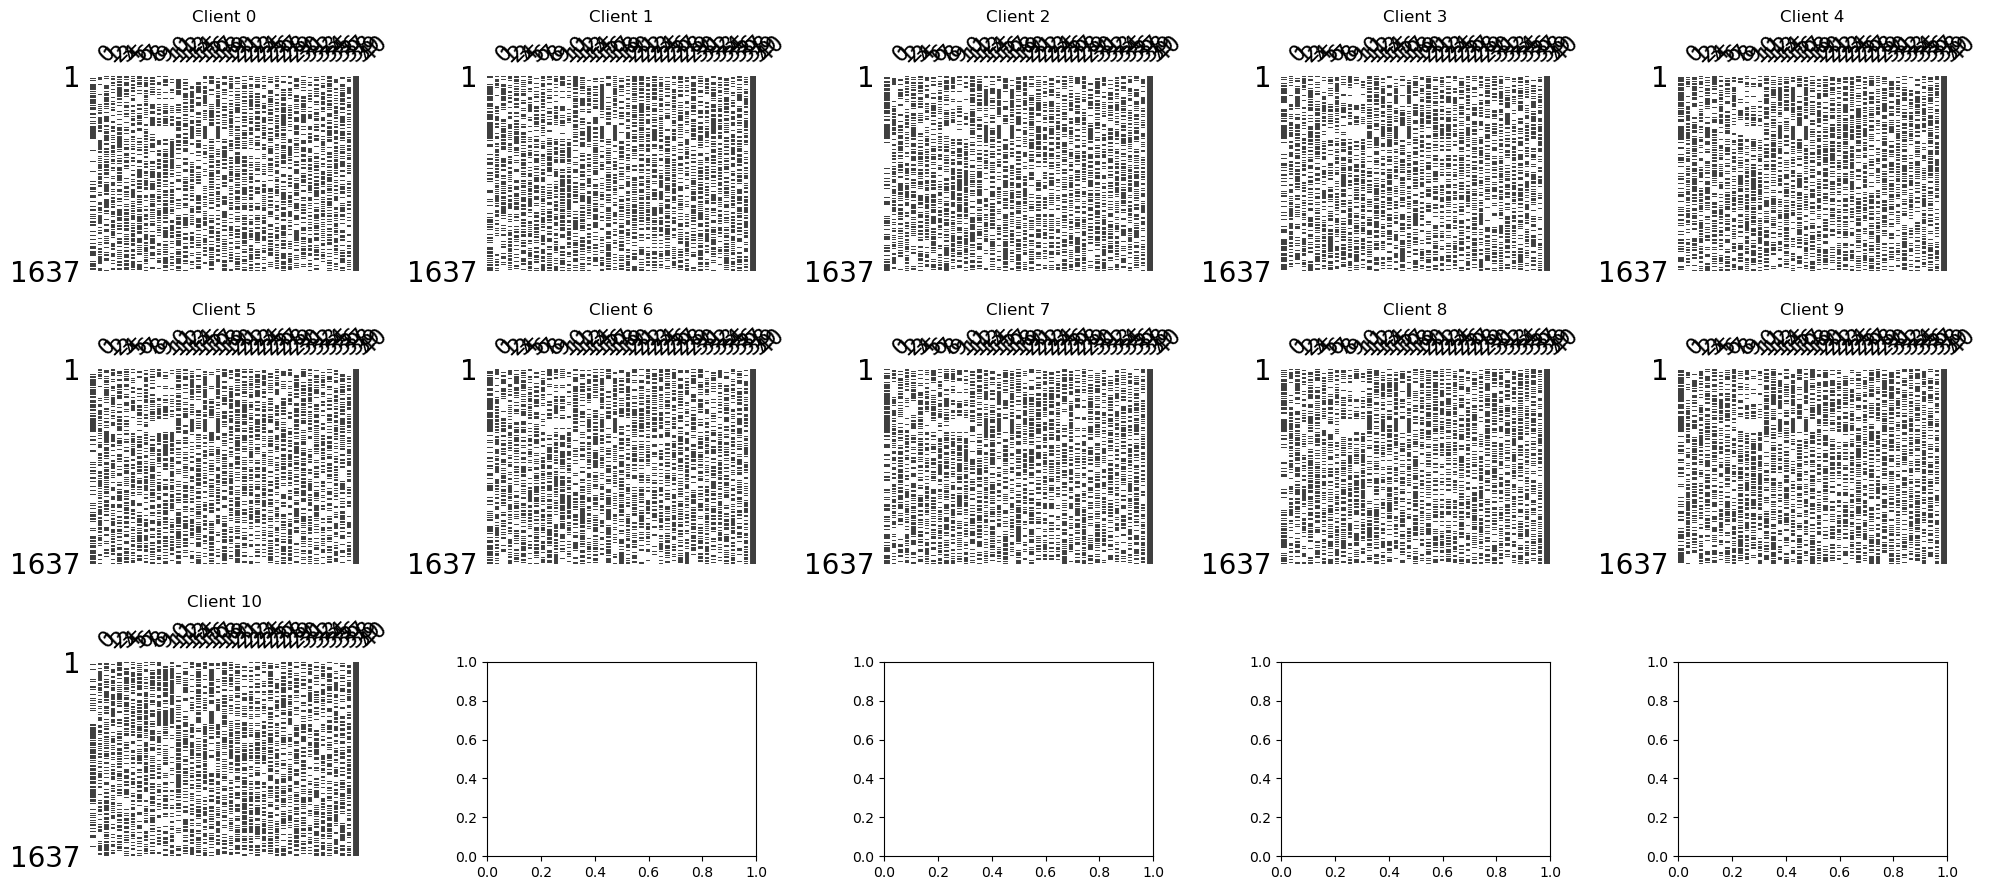

In [64]:
name = 'mnar_rl_mimicmo_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'mimiciii_icd'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [61]:
pred_ret = NN_evaluation(
    rets['mnar_rl_mimicmo_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = None
)

ValueError: multiclass format is not supported

(4156450, 19)
(58976, 22)
(46491, 18)
(46491, 96)
(38857, 41)
(38857, 61)
(20000, 61)
mortality
0    14142
1     5858
Name: count, dtype: int64
(18000, 61) (2000, 61)
(18000, 61)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 61)


2023-08-16 09:34:29.123 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:34:29.124 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-16 09:37:22.275 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:37:22.275 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-16 09:40:36.103 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:40:36.103 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-16 09:40:54.470 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 387.95476370002143


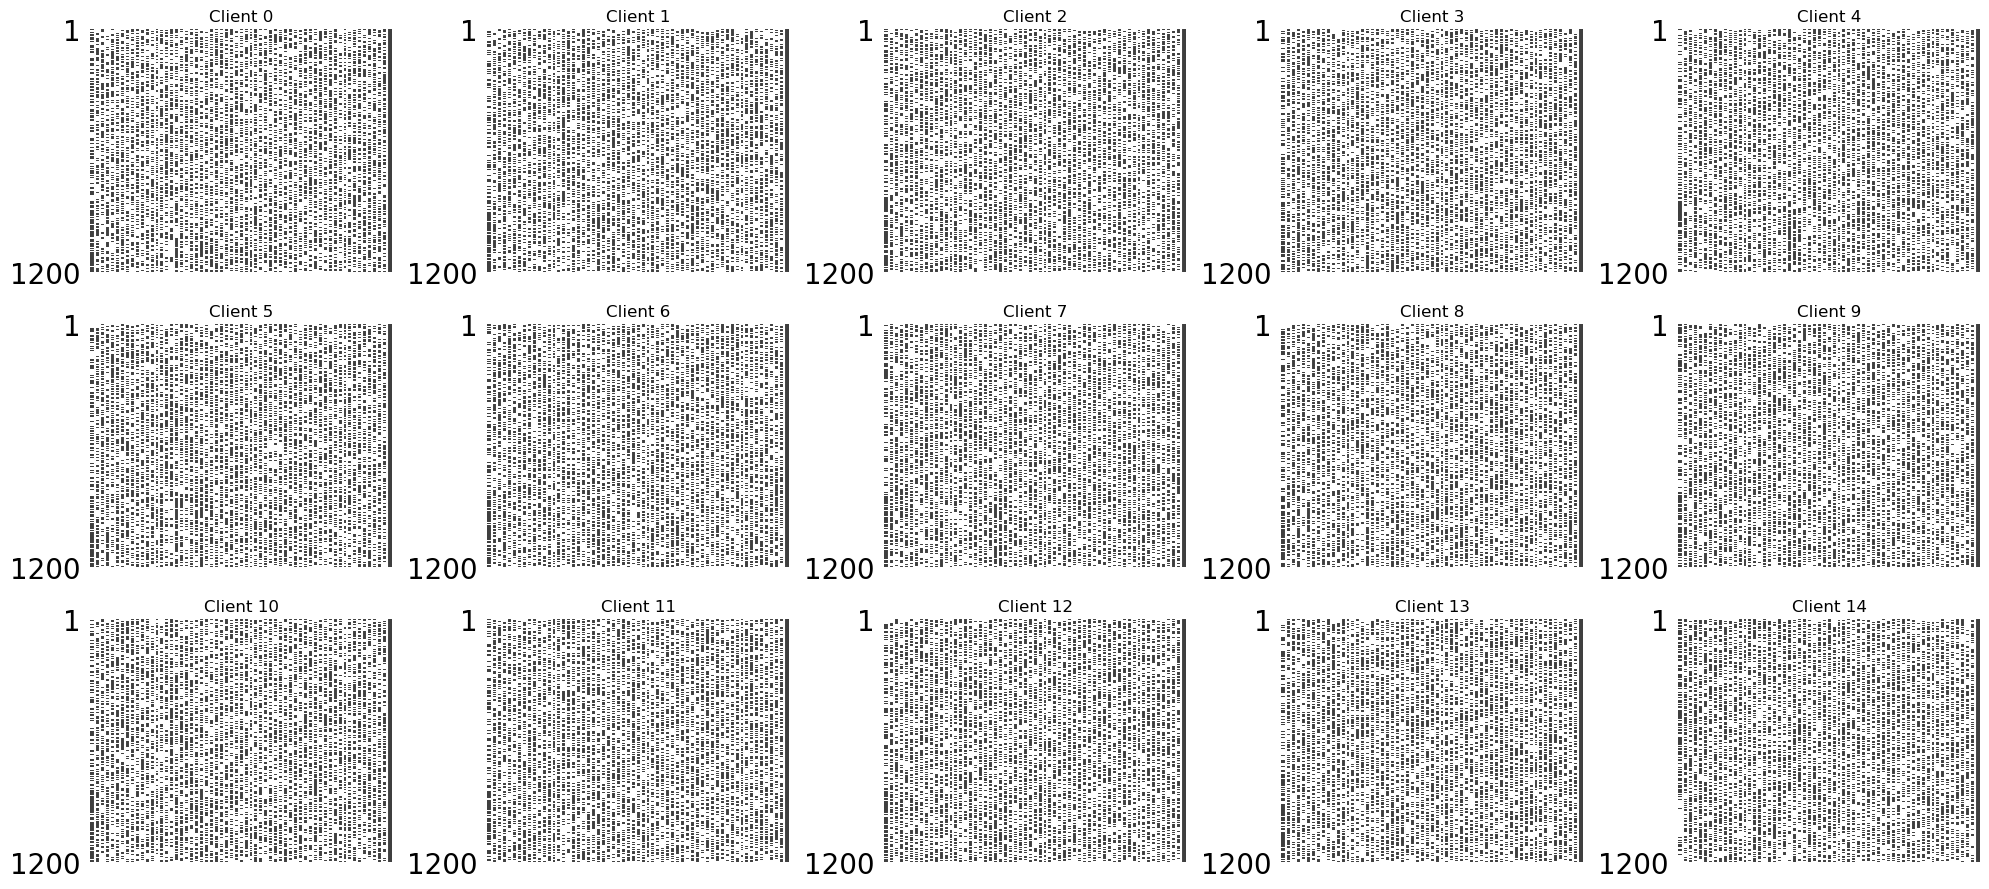

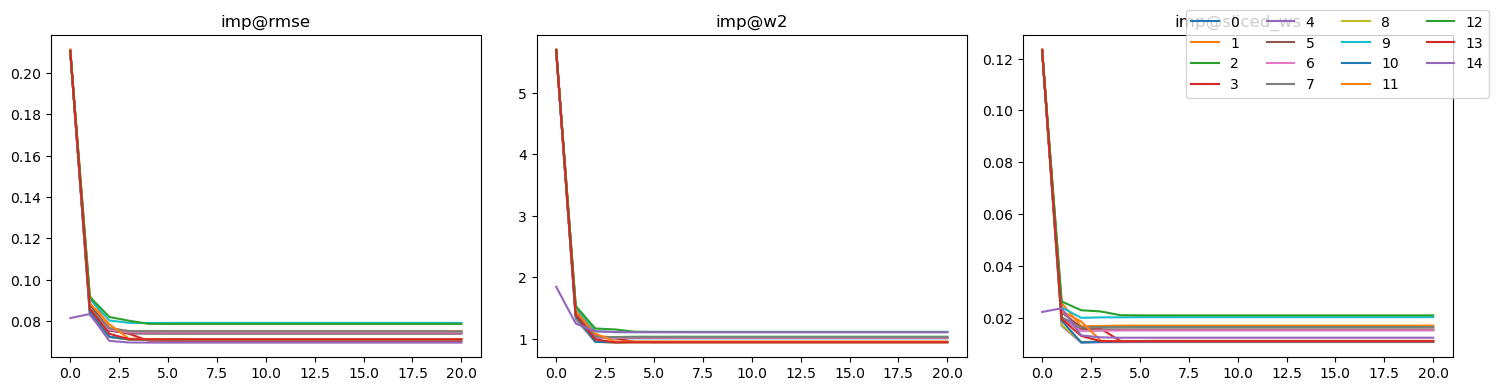

{'imp@rmse': 0.07341203876768884, 'imp@ws': 1.009889162306651, 'imp@sliced_ws': 0.014199697993315595}


In [117]:
name = 'mnar_rl_mimicmo_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'mimiciii_mo'
config2['handle_imbalance'] = None
config2['num_clients'] = 15
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [118]:
pred_ret = NN_evaluation(
    rets['mnar_rl_mimicmo_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = None
)

m:\miniconda3\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-08-16 09:40:55.643 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.7070, test_f1: 0.0000 test_auroc: 0.8284 train_loss: 0.6032 val_accu: 0.7083 val_f1: 0.4146 test recall 0.0000 precision 0.0000 b-accu 0.5000
2023-08-16 09:40:55.778 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 1, test_accu: 0.7745, test_f1: 0.3762 test_auroc: 0.8754 train_loss: 0.5263 val_accu: 0.7711 val_f1: 0.6100 test recall 0.2321 precision 0.9927 b-accu 0.6157
2023-08-16 09:40:55.906 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.8380, test_f

0.858 0.9047928805557299 0.7269372693726937


# MIMICIII LOS

(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 51)


2023-08-20 19:54:38.254 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-20 19:54:38.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-20 19:57:33.172 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-20 19:57:33.172 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-20 20:00:47.720 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-20 20:00:47.721 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-20 20:01:01.971 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 386.39866740000434


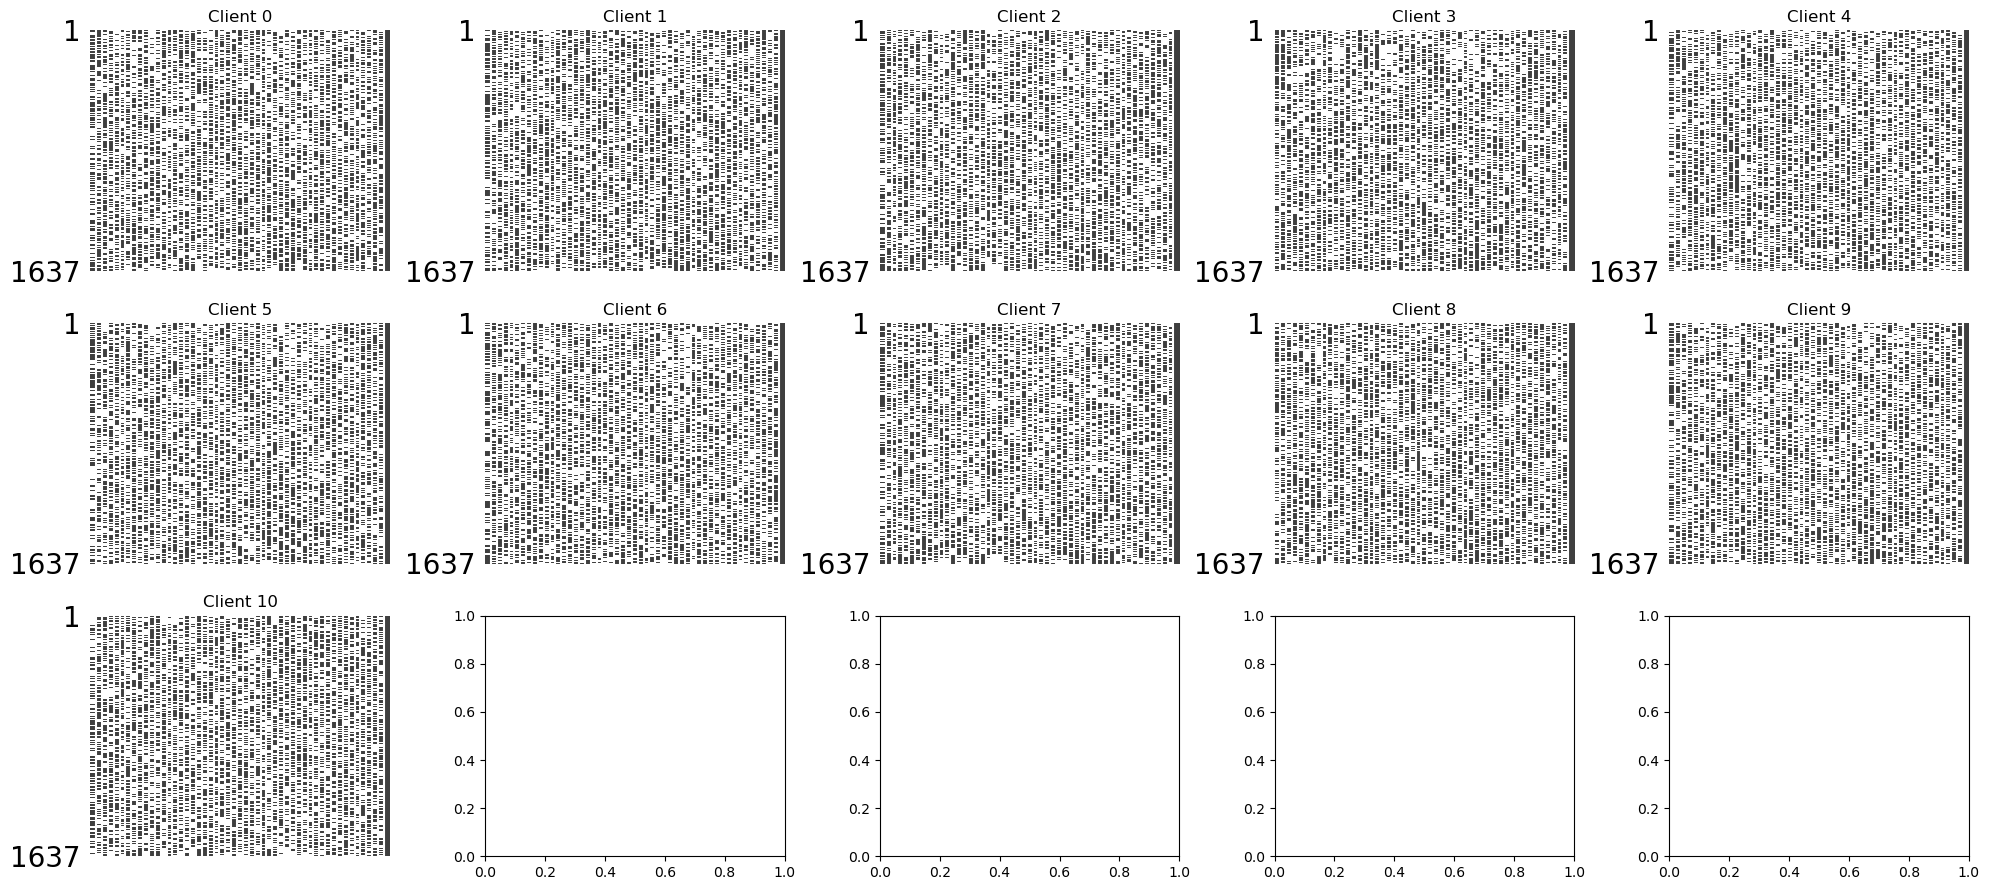

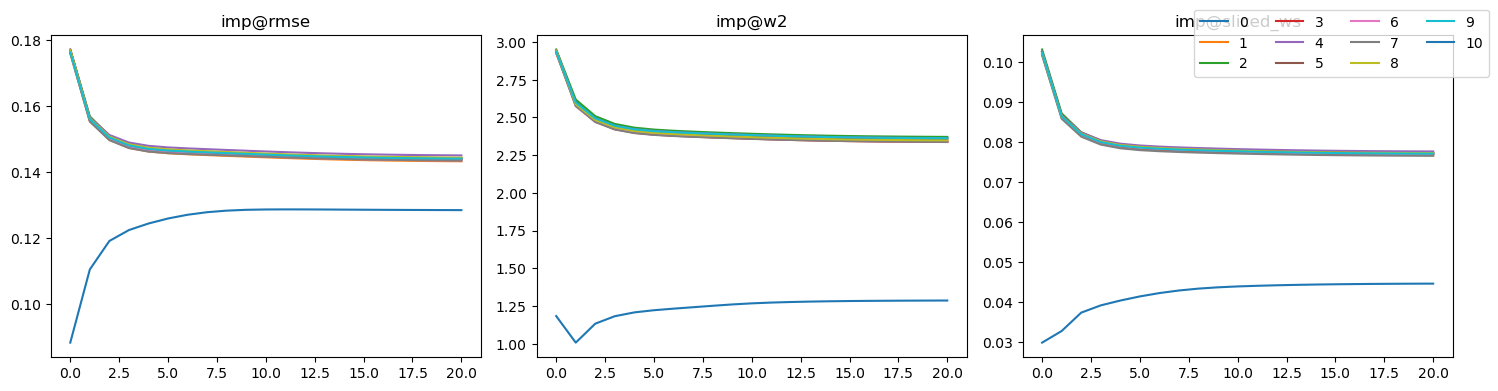

{'imp@rmse': 0.14269867194717897, 'imp@ws': 2.2563689936082825, 'imp@sliced_ws': 0.07414163390828002}


In [6]:
name = 'mnar_rl_mimiclos_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'mimiciii_los'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 51)


2023-08-20 20:01:32.508 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-20 20:01:32.509 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-20 20:03:44.886 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-20 20:03:44.887 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-20 20:06:06.307 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-20 20:06:06.307 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-20 20:06:20.189 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 290.579703800031


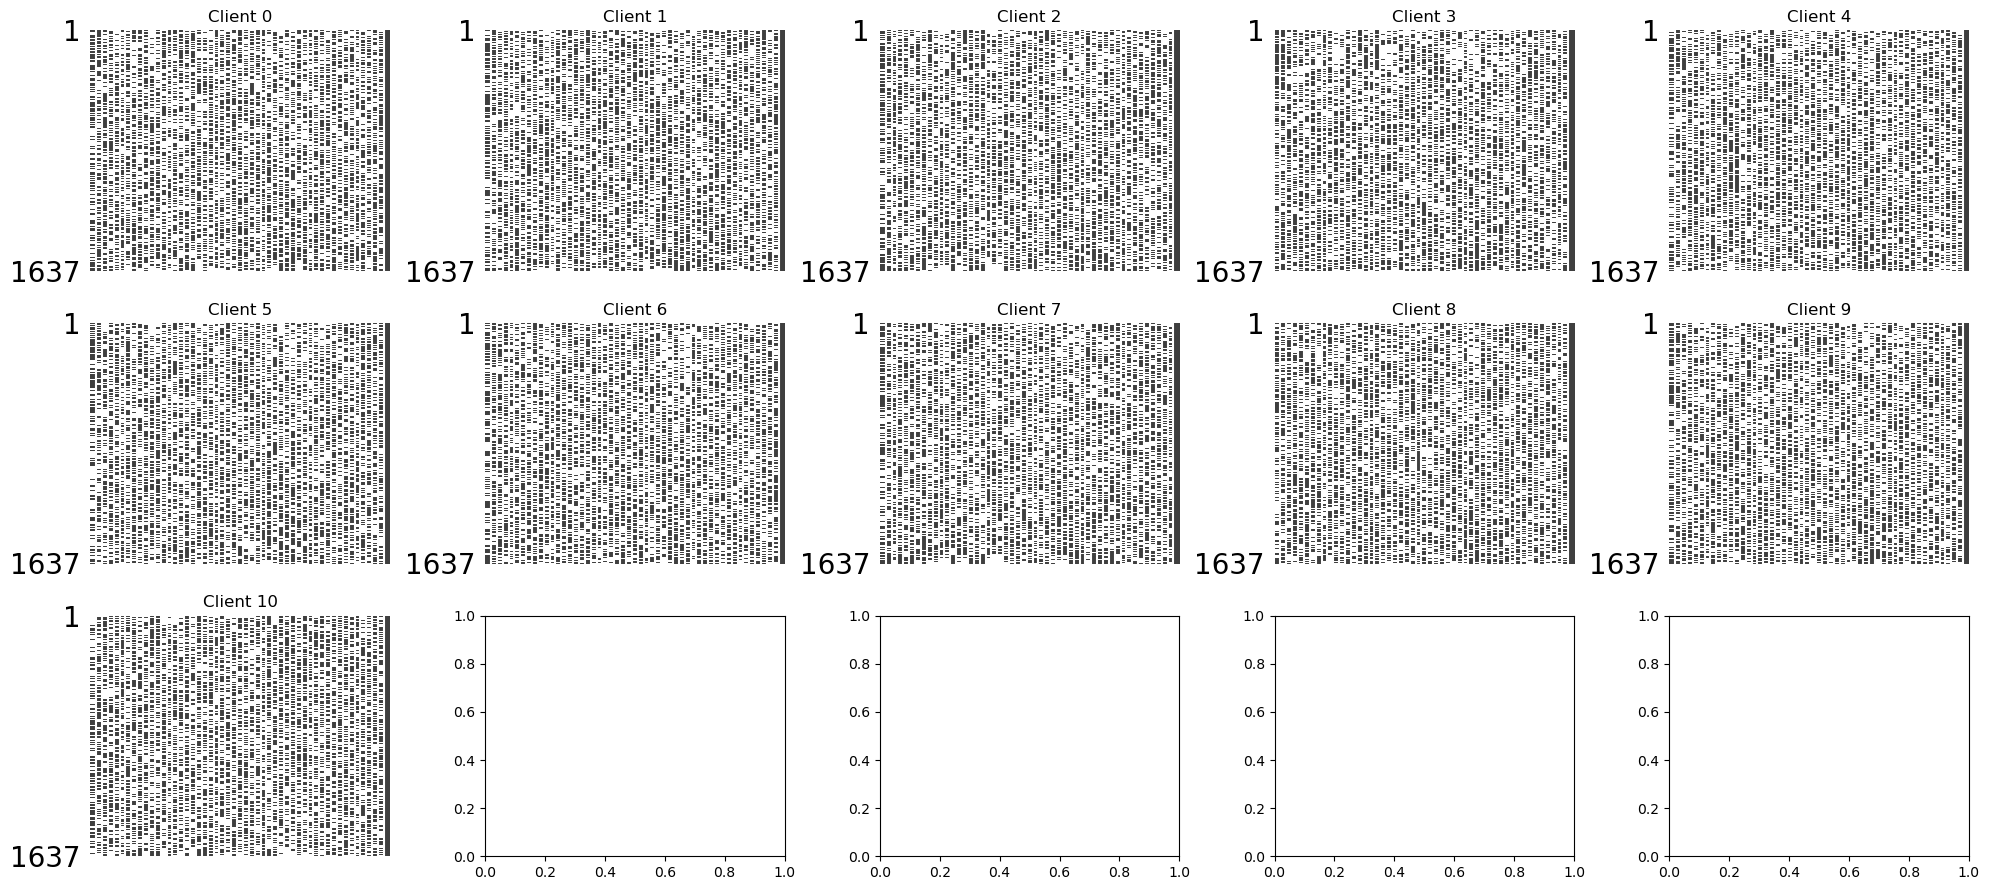

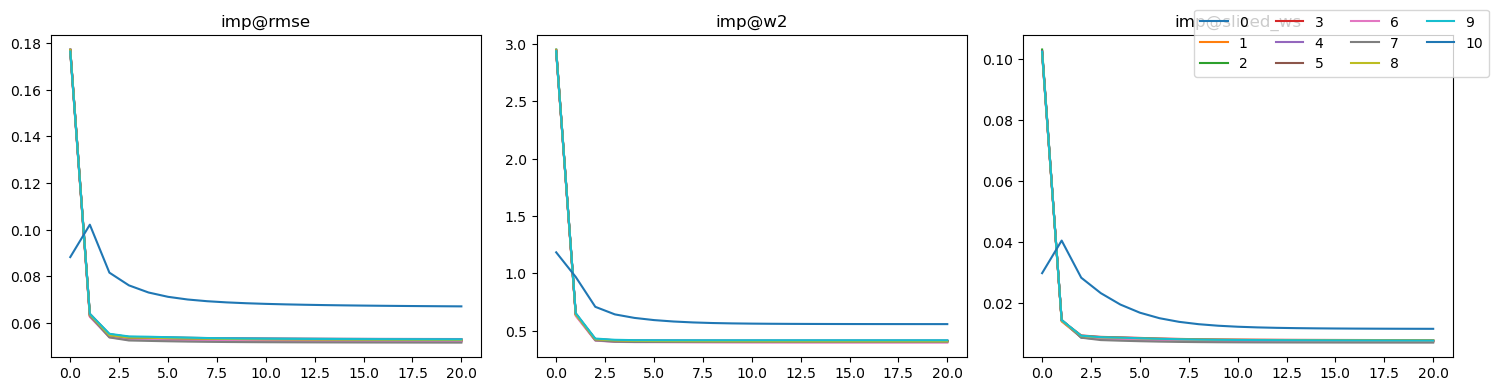

{'imp@rmse': 0.05380920966955938, 'imp@ws': 0.42096792122636717, 'imp@sliced_ws': 0.007984998409465961}


In [7]:
name = 'mnar_rl_mimiclos_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'mimiciii_los'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

# Genetic

Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 33)


2023-08-16 09:48:55.589 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:48:55.590 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-16 09:50:10.815 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:50:10.815 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-16 09:51:28.889 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:51:28.889 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-16 09:51:36.726 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 163.8380214999779


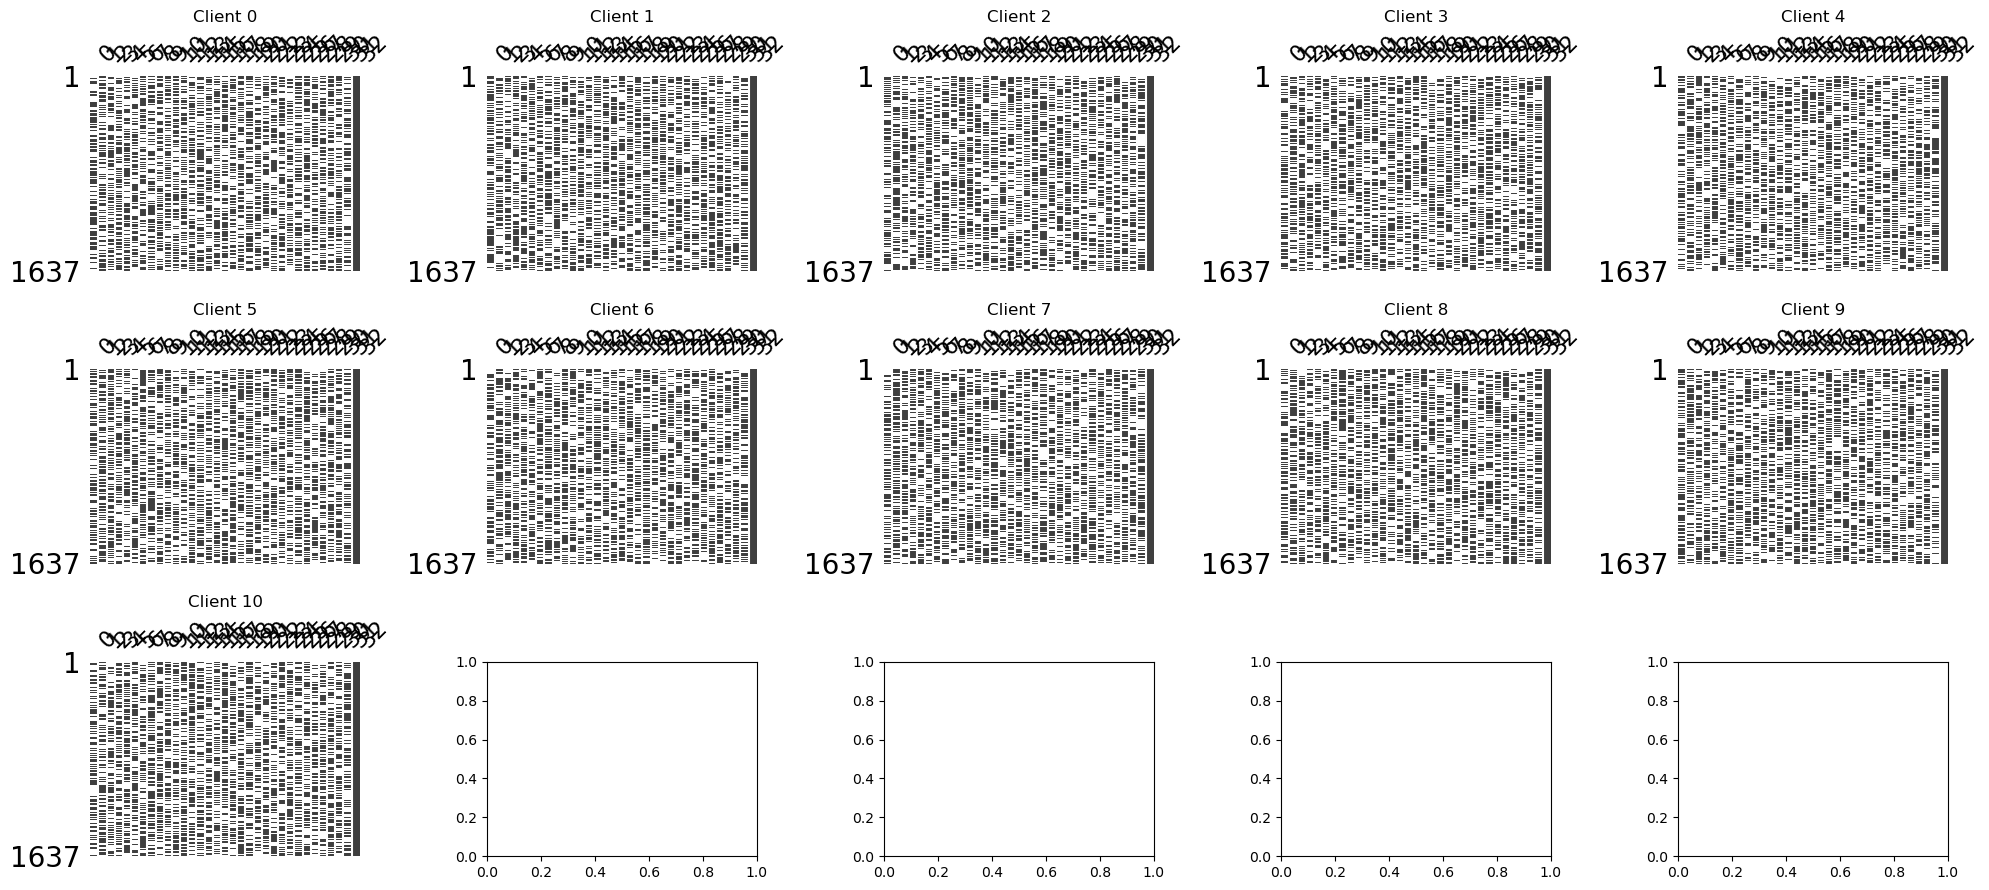

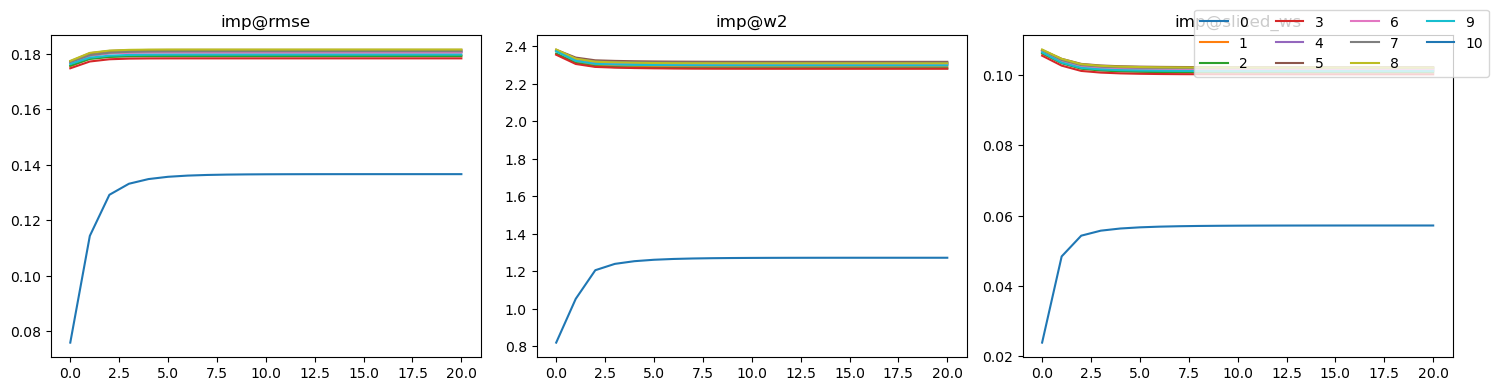

{'imp@rmse': 0.17629010620295868, 'imp@ws': 2.2071112336612475, 'imp@sliced_ws': 0.09742176082373848}


In [6]:
name = 'mnar_rl_genetic_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'genetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [54]:
pred_ret = NN_evaluation(
    rets['mnar_rl_genetic_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = None
)

2023-08-16 17:05:36.891 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.4993 test_auprc: 0.2515 train_loss: 0.5755 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:05:37.046 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 1, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5315 test_auprc: 0.2692 train_loss: 0.5617 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:05:37.187 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 2, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5568 test_auprc: 0.2860 train_loss: 0.5615 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:05:37.332 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 3, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5842 test_auprc: 0.3067 train_loss: 0.5607 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 1

0.753 0.2566137566137566 0.653776573800499 0.3788621721596042


Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 33)


2023-08-16 09:51:45.166 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:51:45.166 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-16 09:52:57.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:52:57.853 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-16 09:54:19.223 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:54:19.224 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-16 09:54:27.353 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 164.76211860001786


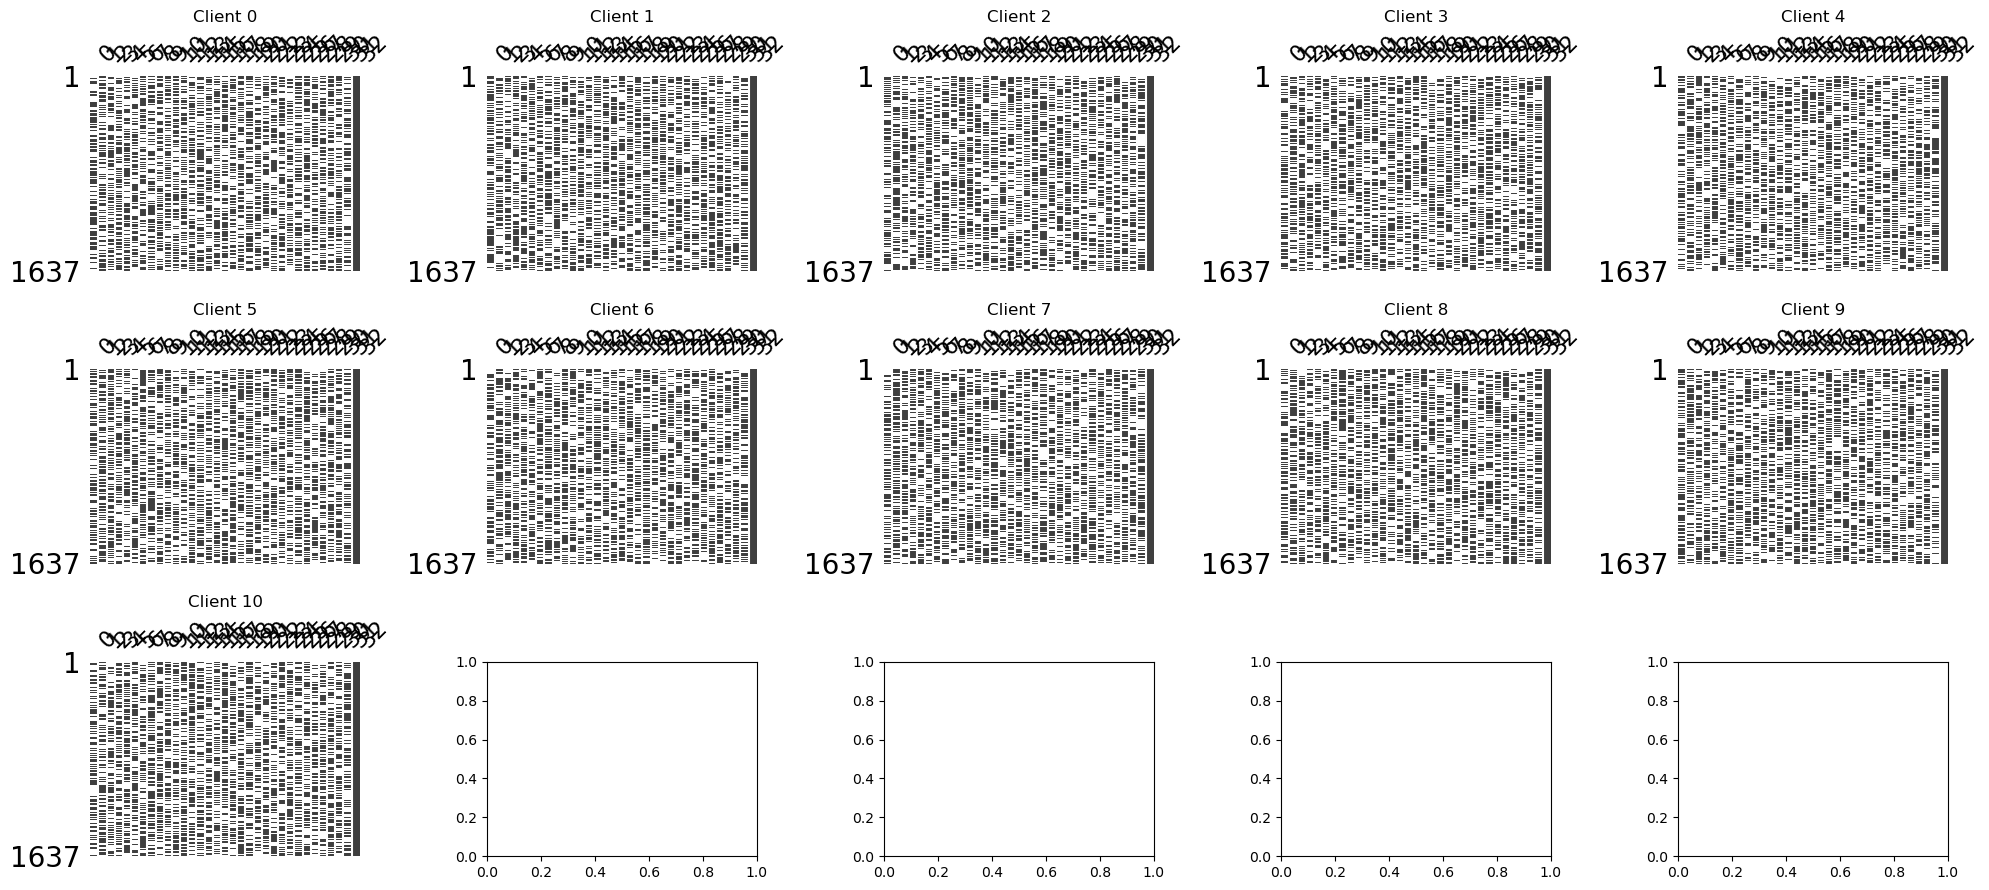

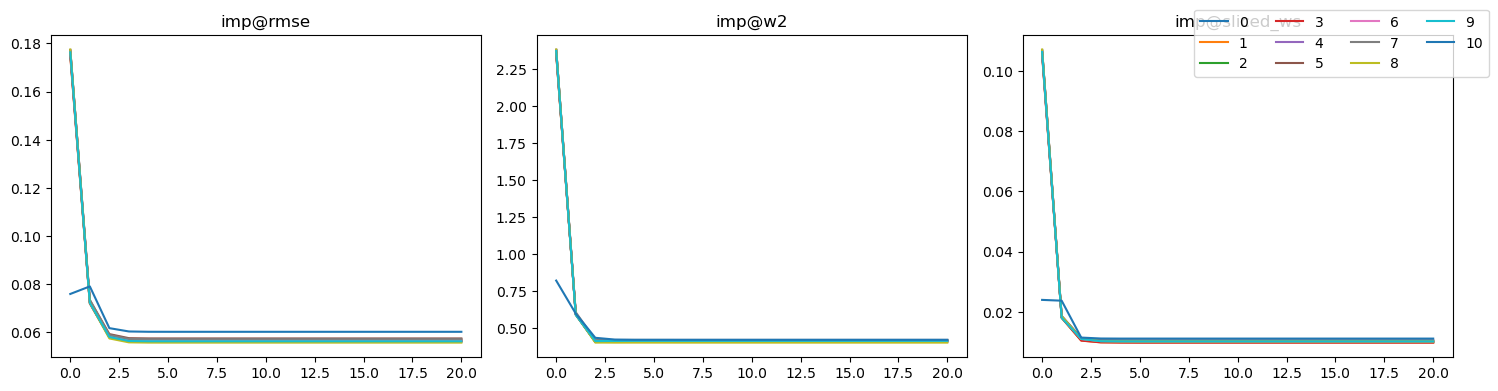

{'imp@rmse': 0.05683915396535701, 'imp@ws': 0.41200755567497166, 'imp@sliced_ws': 0.010124558245875855}


In [7]:
name = 'mnar_rl_genetic_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'genetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [55]:
pred_ret = NN_evaluation(
    rets['mnar_rl_genetic_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = None
)

2023-08-16 17:06:12.556 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5426 test_auprc: 0.2762 train_loss: 0.5757 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:06:12.670 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 1, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.6116 test_auprc: 0.3255 train_loss: 0.5588 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:06:12.779 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 2, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.6446 test_auprc: 0.3574 train_loss: 0.5533 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:06:12.888 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 3, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.6529 test_auprc: 0.3651 train_loss: 0.5445 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 1

0.7555 0.39679715302491103 0.6701317358234123 0.3816156290790693


Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 33)


2023-08-16 09:54:35.991 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:54:35.991 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-16 09:55:41.313 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:55:41.314 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-16 09:56:57.006 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:56:57.007 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-16 09:57:04.776 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 151.45910480001476


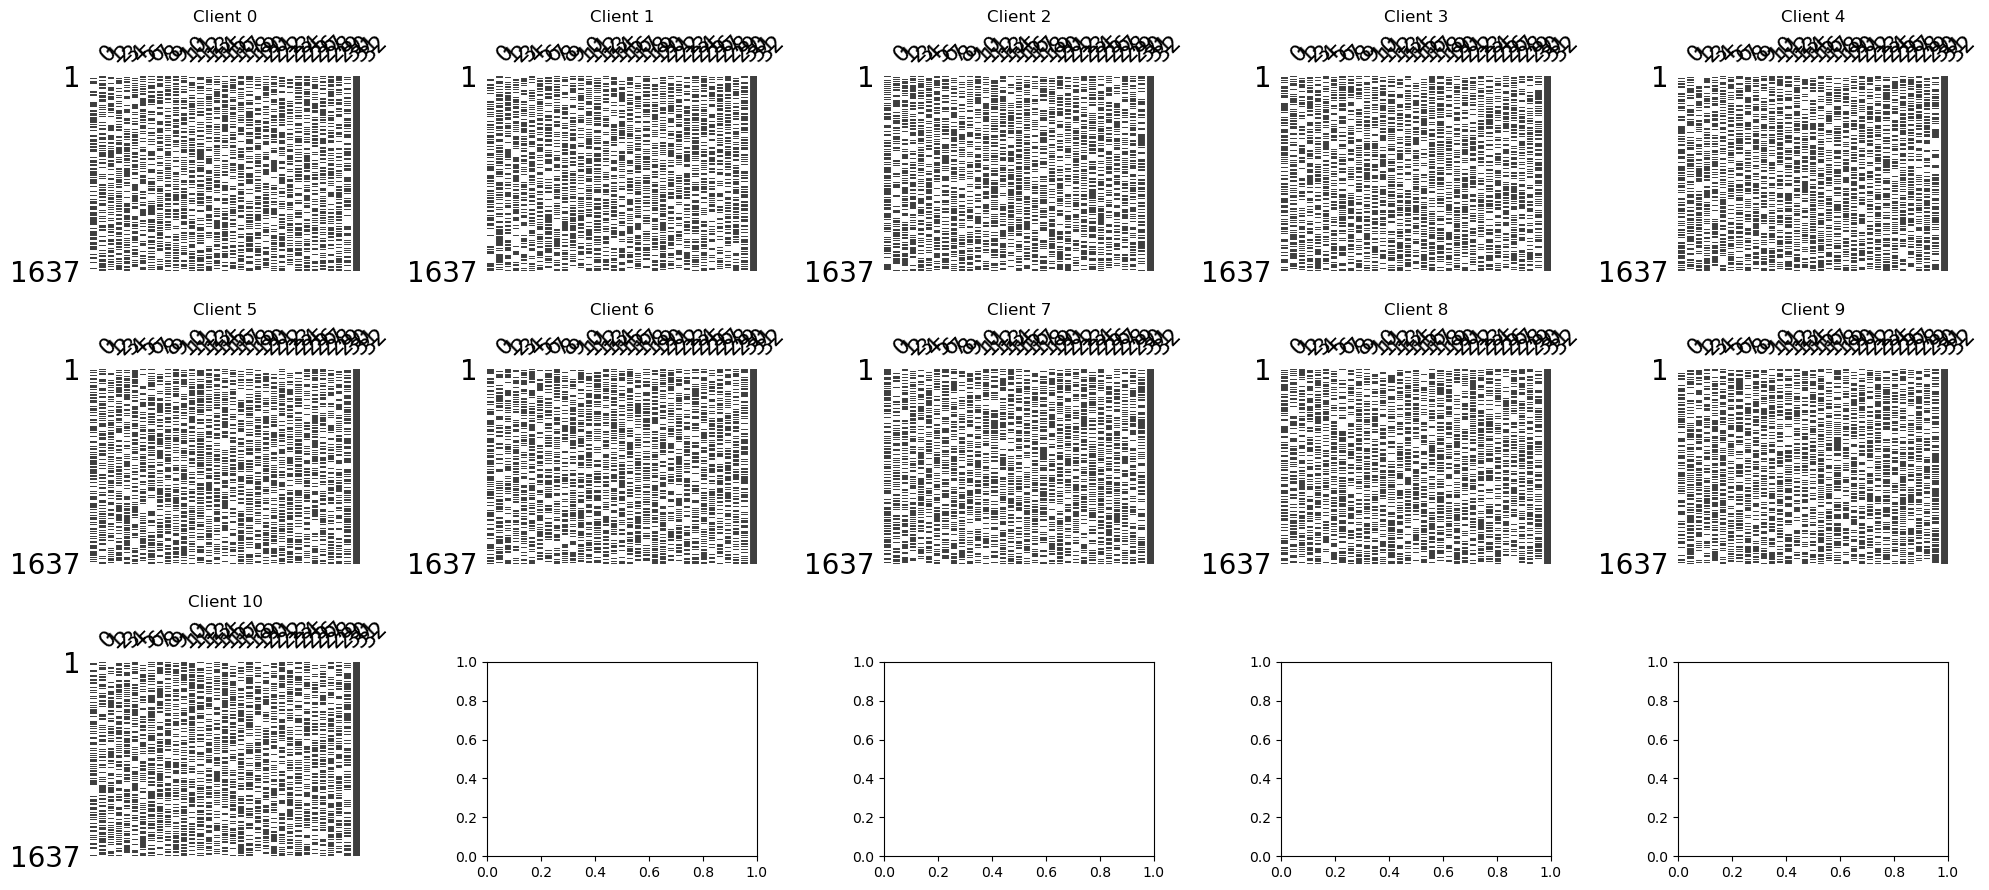

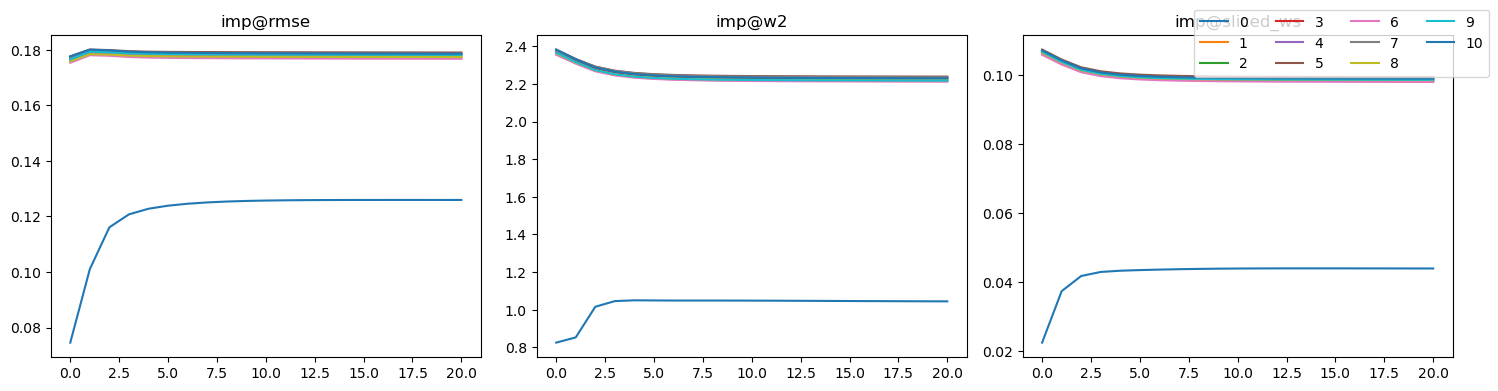

{'imp@rmse': 0.17323219195260878, 'imp@ws': 2.1175038781347433, 'imp@sliced_ws': 0.09374673964282788}


In [8]:
name = 'mnar_lr_genetic_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'genetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [56]:
pred_ret = NN_evaluation(
    rets['mnar_lr_genetic_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = None
)

2023-08-16 17:06:47.231 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.4892 test_auprc: 0.2391 train_loss: 0.5778 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:06:47.345 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 1, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5242 test_auprc: 0.2599 train_loss: 0.5628 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:06:47.456 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 2, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5491 test_auprc: 0.2783 train_loss: 0.5619 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:06:47.566 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 3, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5635 test_auprc: 0.2899 train_loss: 0.5605 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 1

0.7525 0.31739572736520855 0.630966129460787 0.34453231830756986


Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 33)


2023-08-16 09:57:13.601 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:57:13.601 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-16 09:58:30.076 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:58:30.076 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-16 09:59:56.533 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-16 09:59:56.533 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-16 10:00:05.356 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 174.45900879998226


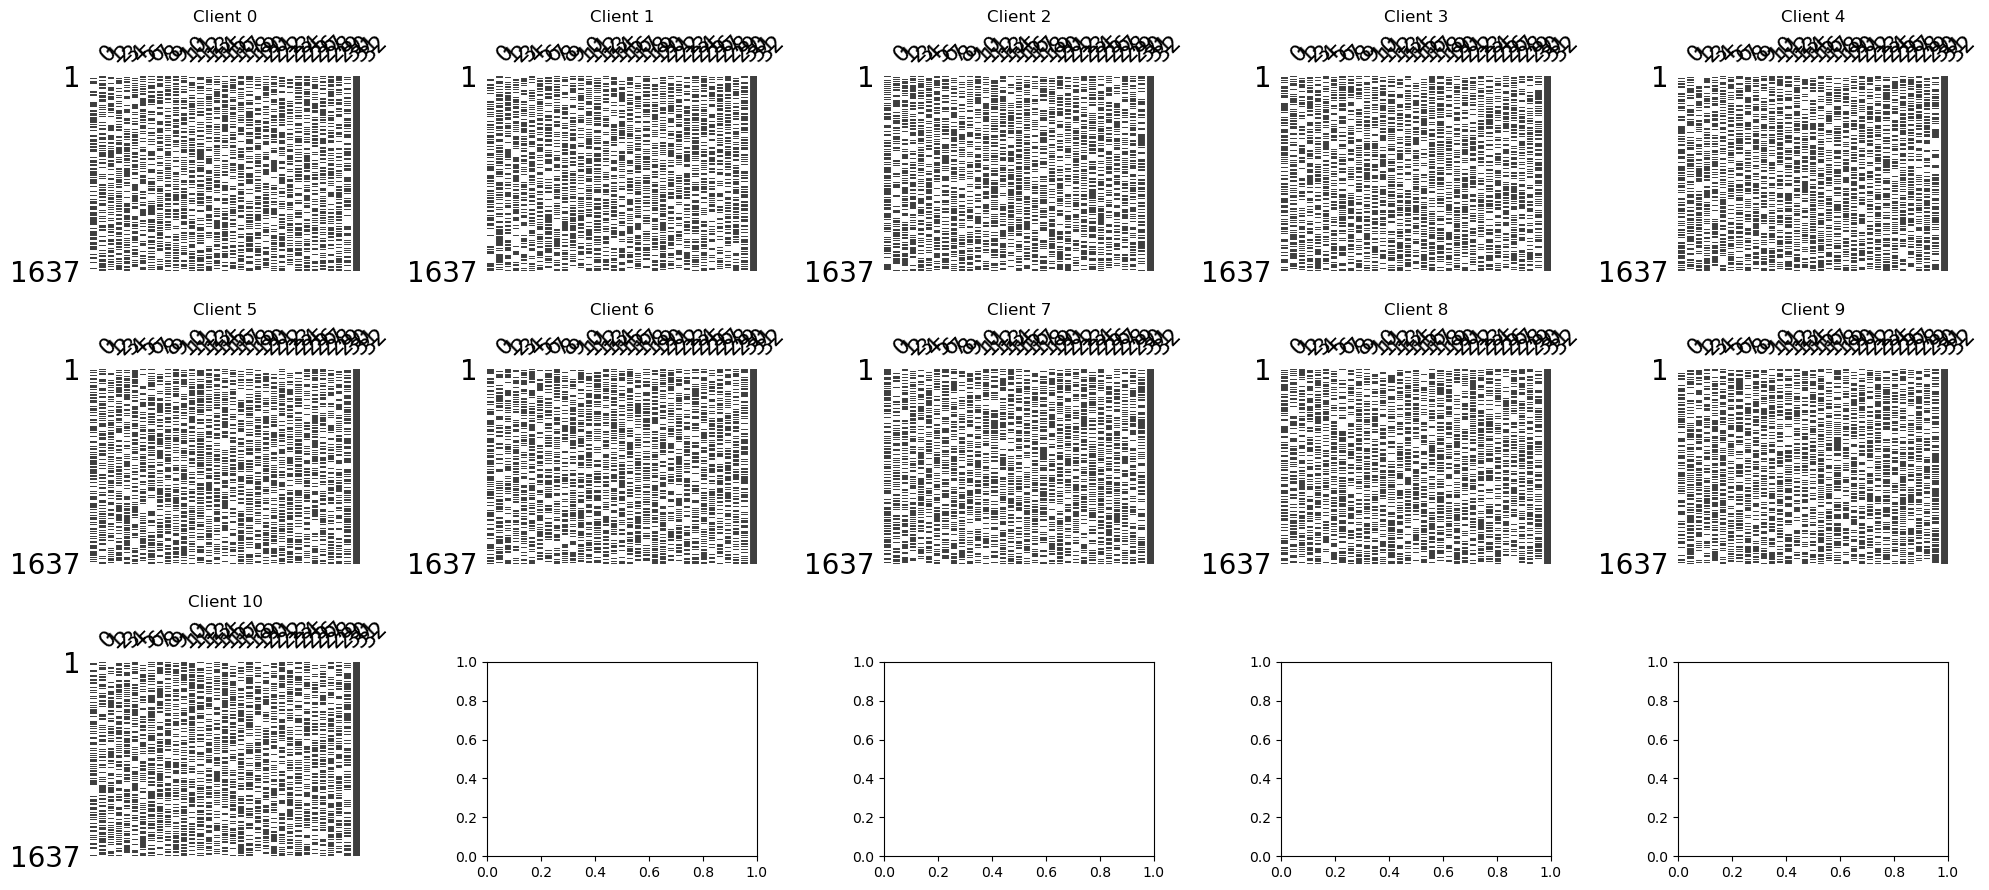

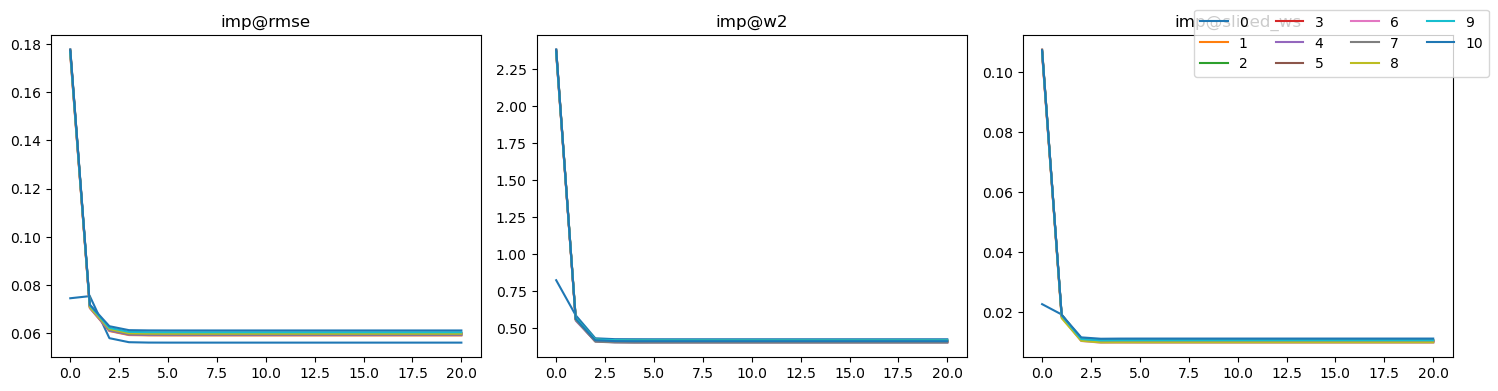

{'imp@rmse': 0.059586867172133684, 'imp@ws': 0.4136522421771314, 'imp@sliced_ws': 0.010196954033889441}


In [9]:
name = 'mnar_lr_genetic_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'genetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [57]:
pred_ret = NN_evaluation(
    rets['mnar_lr_genetic_fedmechw'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl, imbalance = None
)

2023-08-16 17:07:21.984 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.5515 test_auprc: 0.2790 train_loss: 0.5760 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:07:22.091 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 1, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.6231 test_auprc: 0.3327 train_loss: 0.5587 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:07:22.340 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 2, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.6458 test_auprc: 0.3563 train_loss: 0.5530 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 17:07:22.456 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 3, test_accu: 0.7505, test_f1: 0.0000 test_auroc: 0.6523 test_auprc: 0.3665 train_loss: 0.5444 val_accu: 0.7500 val_f1: 0.4286
2023-08-16 1

0.7545 0.39065108514190316 0.6818500425234213 0.3927096190113667
